**Chapter 11 – Deep Learning**

_This notebook contains all the sample code and solutions to the exercises in chapter 11._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Vanishing/Exploding Gradients Problem

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


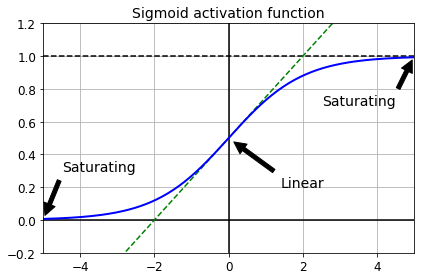

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier and He Initialization

Note: the book uses `tensorflow.contrib.layers.fully_connected()` rather than `tf.layers.dense()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dense()`, because anything in the contrib module may change or be deleted without notice. The `dense()` function is almost identical to the `fully_connected()` function. The main differences relevant to this chapter are:
* several parameters are renamed: `scope` becomes `name`, `activation_fn` becomes `activation` (and similarly the `_fn` suffix is removed from other parameters such as `normalizer_fn`), `weights_initializer` becomes `kernel_initializer`, etc.
* the default `activation` is now `None` rather than `tf.nn.relu`.
* it does not support `tensorflow.contrib.framework.arg_scope()` (introduced later in chapter 11).
* it does not support regularizer params (introduced later in chapter 11).

In [4]:
import tensorflow as tf

In [5]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [6]:
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")

## Nonsaturating Activation Functions

### Leaky ReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


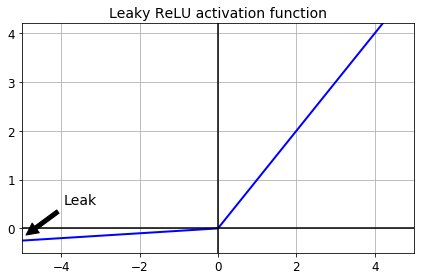

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

Implementing Leaky ReLU in TensorFlow:

In [9]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [10]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

Let's train a neural network on MNIST using the Leaky ReLU. First let's create the graph:

In [11]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [12]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [13]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [14]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [15]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [16]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [17]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Let's load the data:

**Warning**: `tf.examples.tutorials.mnist` is deprecated. We will use `tf.keras.datasets.mnist` instead.

In [18]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [19]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [20]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.86 Validation accuracy: 0.9048
5 Batch accuracy: 0.94 Validation accuracy: 0.9494
10 Batch accuracy: 0.92 Validation accuracy: 0.9656
15 Batch accuracy: 0.94 Validation accuracy: 0.9712
20 Batch accuracy: 1.0 Validation accuracy: 0.9764
25 Batch accuracy: 1.0 Validation accuracy: 0.9772
30 Batch accuracy: 0.98 Validation accuracy: 0.9782
35 Batch accuracy: 1.0 Validation accuracy: 0.9786


### ELU

In [21]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


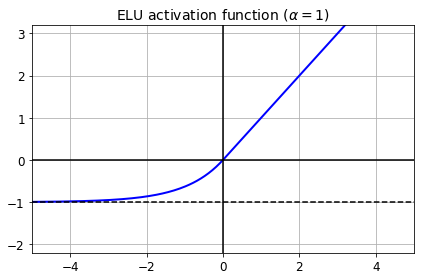

In [22]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [23]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [24]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

### SELU

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017 (I will definitely add it to the book). During training, a neural network composed of a stack of dense layers using the SELU activation function will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out.

In [25]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * elu(z, alpha)

Saving figure selu_plot


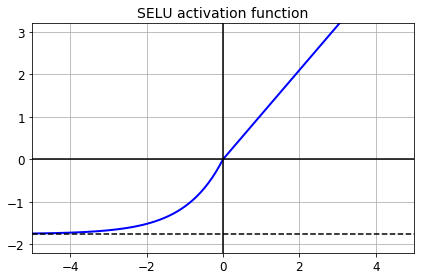

In [26]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 100 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [27]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100))
for layer in range(100):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1/100))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=1)
    stds = np.std(Z, axis=1)
    if layer % 10 == 0:
        print("Layer {}: {:.2f} < mean < {:.2f}, {:.2f} < std deviation < {:.2f}".format(
            layer, means.min(), means.max(), stds.min(), stds.max()))

Layer 0: -0.26 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 10: -0.24 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 20: -0.17 < mean < 0.18, 0.74 < std deviation < 1.24
Layer 30: -0.27 < mean < 0.24, 0.78 < std deviation < 1.20
Layer 40: -0.38 < mean < 0.39, 0.74 < std deviation < 1.25
Layer 50: -0.27 < mean < 0.31, 0.73 < std deviation < 1.27
Layer 60: -0.26 < mean < 0.43, 0.74 < std deviation < 1.35
Layer 70: -0.19 < mean < 0.21, 0.75 < std deviation < 1.21
Layer 80: -0.18 < mean < 0.16, 0.72 < std deviation < 1.19
Layer 90: -0.19 < mean < 0.16, 0.75 < std deviation < 1.20


The `tf.nn.selu()` function was added in TensorFlow 1.4. For earlier versions, you can use the following implementation:

In [28]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))

However, the SELU activation function cannot be used along with regular Dropout (this would cancel the SELU activation function's self-normalizing property). Fortunately, there is a Dropout variant called Alpha Dropout proposed in the same paper. It is available in `tf.contrib.nn.alpha_dropout()` since TF 1.4 (or check out [this implementation](https://github.com/bioinf-jku/SNNs/blob/master/selu.py) by the Institute of Bioinformatics, Johannes Kepler University Linz).

Let's create a neural net for MNIST using the SELU activation function:

In [29]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [30]:
means = X_train.mean(axis=0, keepdims=True)
stds = X_train.std(axis=0, keepdims=True) + 1e-10
X_val_scaled = (X_valid - means) / stds

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_val_scaled, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final_selu.ckpt")

0 Batch accuracy: 0.88 Validation accuracy: 0.9232
5 Batch accuracy: 0.98 Validation accuracy: 0.9576
10 Batch accuracy: 1.0 Validation accuracy: 0.9662
15 Batch accuracy: 0.96 Validation accuracy: 0.968
20 Batch accuracy: 1.0 Validation accuracy: 0.9694
25 Batch accuracy: 1.0 Validation accuracy: 0.9688
30 Batch accuracy: 1.0 Validation accuracy: 0.969
35 Batch accuracy: 1.0 Validation accuracy: 0.9696


# Batch Normalization

Note: the book uses `tensorflow.contrib.layers.batch_norm()` rather than `tf.layers.batch_normalization()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.batch_normalization()`, because anything in the contrib module may change or be deleted without notice. Instead of using the `batch_norm()` function as a regularizer parameter to the `fully_connected()` function, we now use `batch_normalization()` and we explicitly create a distinct layer. The parameters are a bit different, in particular:
* `decay` is renamed to `momentum`,
* `is_training` is renamed to `training`,
* `updates_collections` is removed: the update operations needed by batch normalization are added to the `UPDATE_OPS` collection and you need to explicity run these operations during training (see the execution phase below),
* we don't need to specify `scale=True`, as that is the default.

Also note that in order to run batch norm just _before_ each hidden layer's activation function, we apply the ELU activation function manually, right after the batch norm layer.

Note: since the `tf.layers.dense()` function is incompatible with `tf.contrib.layers.arg_scope()` (which is used in the book), we now use python's `functools.partial()` function instead. It makes it easy to create a `my_dense_layer()` function that just calls `tf.layers.dense()` with the desired parameters automatically set (unless they are overridden when calling `my_dense_layer()`). As you can see, the code remains very similar.

In [31]:
reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

In [32]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

To avoid repeating the same parameters over and over again, we can use Python's `partial()` function:

In [33]:
from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

Let's build a neural net for MNIST, using the ELU activation function and Batch Normalization at each layer:

In [34]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Note: since we are using `tf.layers.batch_normalization()` rather than `tf.contrib.layers.batch_norm()` (as in the book), we need to explicitly run the extra update operations needed by batch normalization (`sess.run([training_op, extra_update_ops],...`).

In [35]:
n_epochs = 20
batch_size = 200

In [36]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.9042
1 Validation accuracy: 0.928
2 Validation accuracy: 0.9374
3 Validation accuracy: 0.9474
4 Validation accuracy: 0.9532
5 Validation accuracy: 0.9572
6 Validation accuracy: 0.9626
7 Validation accuracy: 0.9628
8 Validation accuracy: 0.9664
9 Validation accuracy: 0.968
10 Validation accuracy: 0.9694
11 Validation accuracy: 0.9696
12 Validation accuracy: 0.971
13 Validation accuracy: 0.971
14 Validation accuracy: 0.9728
15 Validation accuracy: 0.9734
16 Validation accuracy: 0.9728
17 Validation accuracy: 0.975
18 Validation accuracy: 0.9752
19 Validation accuracy: 0.976


What!? That's not a great accuracy for MNIST. Of course, if you train for longer it will get much better accuracy, but with such a shallow network, Batch Norm and ELU are unlikely to have very positive impact: they shine mostly for much deeper nets.

Note that you could also make the training operation depend on the update operations:

```python
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        training_op = optimizer.minimize(loss)
```

This way, you would just have to evaluate the `training_op` during training, TensorFlow would automatically run the update operations as well:

```python
sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
```

One more thing: notice that the list of trainable variables is shorter than the list of all global variables. This is because the moving averages are non-trainable variables. If you want to reuse a pretrained neural network (see below), you must not forget these non-trainable variables.

In [37]:
[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [38]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

## Gradient Clipping

Let's create a simple neural net for MNIST and add gradient clipping. The first part is the same as earlier (except we added a few more layers to demonstrate reusing pretrained models, see below):

In [39]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [40]:
learning_rate = 0.01

Now we apply gradient clipping. For this, we need to get the gradients, use the `clip_by_value()` function to clip them, then apply them:

In [41]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

The rest is the same as usual:

In [42]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [43]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [44]:
n_epochs = 20
batch_size = 200

In [45]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.2876
1 Validation accuracy: 0.7944
2 Validation accuracy: 0.8796
3 Validation accuracy: 0.906
4 Validation accuracy: 0.9162
5 Validation accuracy: 0.9216
6 Validation accuracy: 0.9292
7 Validation accuracy: 0.9356
8 Validation accuracy: 0.938
9 Validation accuracy: 0.9416
10 Validation accuracy: 0.9458
11 Validation accuracy: 0.947
12 Validation accuracy: 0.9476
13 Validation accuracy: 0.9534
14 Validation accuracy: 0.9562
15 Validation accuracy: 0.9566
16 Validation accuracy: 0.9576
17 Validation accuracy: 0.9588
18 Validation accuracy: 0.9624
19 Validation accuracy: 0.961


## Reusing Pretrained Layers

## Reusing a TensorFlow Model

First you need to load the graph's structure. The `import_meta_graph()` function does just that, loading the graph's operations into the default graph, and returning a `Saver` that you can then use to restore the model's state. Note that by default, a `Saver` saves the structure of the graph into a `.meta` file, so that's the file you should load:

In [46]:
reset_graph()

In [47]:
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

Next you need to get a handle on all the operations you will need for training. If you don't know the graph's structure, you can list all the operations:

In [48]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

save/RestoreV2/shape_and_slices
save/RestoreV2/tensor_names
save/SaveV2/shape_and_slices
save/SaveV2/tensor_names
save/Const
save/RestoreV2
eval/Const
eval/in_top_k/InTopKV2/k
GradientDescent/learning_rate
clip_by_value_11/clip_value_max
clip_by_value_11/clip_value_min
clip_by_value_10/clip_value_max
clip_by_value_10/clip_value_min
clip_by_value_9/clip_value_max
clip_by_value_9/clip_value_min
clip_by_value_8/clip_value_max
clip_by_value_8/clip_value_min
clip_by_value_7/clip_value_max
clip_by_value_7/clip_value_min
clip_by_value_6/clip_value_max
clip_by_value_6/clip_value_min
clip_by_value_5/clip_value_max
clip_by_value_5/clip_value_min
clip_by_value_4/clip_value_max
clip_by_value_4/clip_value_min
clip_by_value_3/clip_value_max
clip_by_value_3/clip_value_min
clip_by_value_2/clip_value_max
clip_by_value_2/clip_value_min
clip_by_value_1/clip_value_max
clip_by_value_1/clip_value_min
clip_by_value/clip_value_max
clip_by_value/clip_value_min
gradients/loss/SparseSoftmaxCrossEntropyWithLogits

Oops, that's a lot of operations! It's much easier to use TensorBoard to visualize the graph. The following hack will allow you to visualize the graph within Jupyter (if it does not work with your browser, you will need to use a `FileWriter` to save the graph and then visualize it in TensorBoard):

In [49]:
from tensorflow_graph_in_jupyter import show_graph

In [50]:
show_graph(tf.get_default_graph())

Once you know which operations you need, you can get a handle on them using the graph's `get_operation_by_name()` or `get_tensor_by_name()` methods:

In [51]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

If you are the author of the original model, you could make things easier for people who will reuse your model by giving operations very clear names and documenting them. Another approach is to create a collection containing all the important operations that people will want to get a handle on:

In [52]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

This way people who reuse your model will be able to simply write:

In [53]:
X, y, accuracy, training_op = tf.get_collection("my_important_ops")

Now you can start a session, restore the model's state and continue training on your data:

In [54]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    # continue training the model...

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


Actually, let's test this for real!

In [55]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9644
1 Validation accuracy: 0.9646
2 Validation accuracy: 0.9624
3 Validation accuracy: 0.9658
4 Validation accuracy: 0.9668
5 Validation accuracy: 0.9652
6 Validation accuracy: 0.9678
7 Validation accuracy: 0.9676
8 Validation accuracy: 0.9676
9 Validation accuracy: 0.969
10 Validation accuracy: 0.97
11 Validation accuracy: 0.9706
12 Validation accuracy: 0.9676
13 Validation accuracy: 0.9688
14 Validation accuracy: 0.9708
15 Validation accuracy: 0.9696
16 Validation accuracy: 0.9712
17 Validation accuracy: 0.9696
18 Validation accuracy: 0.9688
19 Validation accuracy: 0.9724


Alternatively, if you have access to the Python code that built the original graph, you can use it instead of `import_meta_graph()`:

In [56]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

And continue training:

In [57]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.964
1 Validation accuracy: 0.9644
2 Validation accuracy: 0.9626
3 Validation accuracy: 0.965
4 Validation accuracy: 0.9668
5 Validation accuracy: 0.9656
6 Validation accuracy: 0.968
7 Validation accuracy: 0.9678
8 Validation accuracy: 0.9676
9 Validation accuracy: 0.9686
10 Validation accuracy: 0.9698
11 Validation accuracy: 0.9708
12 Validation accuracy: 0.9678
13 Validation accuracy: 0.9688
14 Validation accuracy: 0.9708
15 Validation accuracy: 0.9694
16 Validation accuracy: 0.9714
17 Validation accuracy: 0.9696
18 Validation accuracy: 0.969
19 Validation accuracy: 0.9724


In general you will want to reuse only the lower layers. If you are using `import_meta_graph()` it will load the whole graph, but you can simply ignore the parts you do not need. In this example, we add a new 4th hidden layer on top of the pretrained 3rd layer (ignoring the old 4th hidden layer). We also build a new output layer, the loss for this new output, and a new optimizer to minimize it. We also need another saver to save the whole graph (containing both the entire old graph plus the new operations), and an initialization operation to initialize all the new variables:

In [58]:
reset_graph()

n_hidden4 = 20  # new layer
n_outputs = 10  # new layer

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden4/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

And we can train this new model:

In [59]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = new_saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.924
1 Validation accuracy: 0.9424
2 Validation accuracy: 0.9512
3 Validation accuracy: 0.9562
4 Validation accuracy: 0.9606
5 Validation accuracy: 0.9568
6 Validation accuracy: 0.9622
7 Validation accuracy: 0.9638
8 Validation accuracy: 0.9632
9 Validation accuracy: 0.9644
10 Validation accuracy: 0.966
11 Validation accuracy: 0.9666
12 Validation accuracy: 0.9636
13 Validation accuracy: 0.9676
14 Validation accuracy: 0.9694
15 Validation accuracy: 0.968
16 Validation accuracy: 0.9692
17 Validation accuracy: 0.968
18 Validation accuracy: 0.9698
19 Validation accuracy: 0.9692


If you have access to the Python code that built the original graph, you can just reuse the parts you need and drop the rest:

In [60]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

However, you must create one `Saver` to restore the pretrained model (giving it the list of variables to restore, or else it will complain that the graphs don't match), and another `Saver` to save the new model, once it is trained:

In [61]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):                                            # not shown in the book
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})        # not shown
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})     # not shown
        print(epoch, "Validation accuracy:", accuracy_val)                   # not shown

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9132
1 Validation accuracy: 0.9318
2 Validation accuracy: 0.9442
3 Validation accuracy: 0.95
4 Validation accuracy: 0.9524
5 Validation accuracy: 0.9544
6 Validation accuracy: 0.9558
7 Validation accuracy: 0.9606
8 Validation accuracy: 0.9616
9 Validation accuracy: 0.9604
10 Validation accuracy: 0.962
11 Validation accuracy: 0.9648
12 Validation accuracy: 0.9604
13 Validation accuracy: 0.968
14 Validation accuracy: 0.9664
15 Validation accuracy: 0.9676
16 Validation accuracy: 0.9692
17 Validation accuracy: 0.9694
18 Validation accuracy: 0.969
19 Validation accuracy: 0.9674


## Reusing Models from Other Frameworks

In this example, for each variable we want to reuse, we find its initializer's assignment operation, and we get its second input, which corresponds to the initialization value. When we run the initializer, we replace the initialization values with the ones we want, using a `feed_dict`:

In [62]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

In [63]:
original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the assignment nodes for the hidden1 variables
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))  # not shown in the book

[[ 61.  83. 105.]]


Note: the weights variable created by the `tf.layers.dense()` function is called `"kernel"` (instead of `"weights"` when using the `tf.contrib.layers.fully_connected()`, as in the book), and the biases variable is called `bias` instead of `biases`.

Another approach (initially used in the book) would be to create dedicated assignment nodes and dedicated placeholders. This is more verbose and less efficient, but you may find this more explicit:

In [64]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the variables of layer hidden1
with tf.variable_scope("", default_name="", reuse=True):  # root scope
    hidden1_weights = tf.get_variable("hidden1/kernel")
    hidden1_biases = tf.get_variable("hidden1/bias")

# Create dedicated placeholders and assignment nodes
original_weights = tf.placeholder(tf.float32, shape=(n_inputs, n_hidden1))
original_biases = tf.placeholder(tf.float32, shape=n_hidden1)
assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_hidden1_weights, feed_dict={original_weights: original_w})
    sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[ 61.  83. 105.]]


Note that we could also get a handle on the variables using `get_collection()` and specifying the `scope`:

In [65]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden1")

[<tf.Variable 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(3,) dtype=float32_ref>]

Or we could use the graph's `get_tensor_by_name()` method:

In [66]:
tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")

<tf.Tensor 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>

In [67]:
tf.get_default_graph().get_tensor_by_name("hidden1/bias:0")

<tf.Tensor 'hidden1/bias:0' shape=(3,) dtype=float32_ref>

### Freezing the Lower Layers

In [68]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [69]:
with tf.name_scope("train"):                                         # not shown in the book
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)     # not shown
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss, var_list=train_vars)

In [70]:
init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [71]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.903
1 Validation accuracy: 0.9302
2 Validation accuracy: 0.939
3 Validation accuracy: 0.9406
4 Validation accuracy: 0.9458
5 Validation accuracy: 0.9486
6 Validation accuracy: 0.95
7 Validation accuracy: 0.9528
8 Validation accuracy: 0.9532
9 Validation accuracy: 0.953
10 Validation accuracy: 0.9552
11 Validation accuracy: 0.9558
12 Validation accuracy: 0.9546
13 Validation accuracy: 0.9548
14 Validation accuracy: 0.9558
15 Validation accuracy: 0.9578
16 Validation accuracy: 0.9576
17 Validation accuracy: 0.9586
18 Validation accuracy: 0.9586
19 Validation accuracy: 0.958


In [72]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [73]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

In [74]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

The training code is exactly the same as earlier:

In [75]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9184
1 Validation accuracy: 0.9406
2 Validation accuracy: 0.9468
3 Validation accuracy: 0.9508
4 Validation accuracy: 0.951
5 Validation accuracy: 0.953
6 Validation accuracy: 0.9534
7 Validation accuracy: 0.9554
8 Validation accuracy: 0.9562
9 Validation accuracy: 0.9574
10 Validation accuracy: 0.957
11 Validation accuracy: 0.9582
12 Validation accuracy: 0.9574
13 Validation accuracy: 0.96
14 Validation accuracy: 0.9596
15 Validation accuracy: 0.9582
16 Validation accuracy: 0.9592
17 Validation accuracy: 0.9602
18 Validation accuracy: 0.9606
19 Validation accuracy: 0.9598


### Caching the Frozen Layers

In [76]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen & cached
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [77]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [78]:
import numpy as np

n_batches = len(X_train) // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    h2_cache = sess.run(hidden2, feed_dict={X: X_train})
    h2_cache_valid = sess.run(hidden2, feed_dict={X: X_valid}) # not shown in the book

    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(len(X_train))
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(y_train[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2:hidden2_batch, y:y_batch})

        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_valid, # not shown
                                                y: y_valid})             # not shown
        print(epoch, "Validation accuracy:", accuracy_val)               # not shown

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9184
1 Validation accuracy: 0.9406
2 Validation accuracy: 0.9468
3 Validation accuracy: 0.9508
4 Validation accuracy: 0.951
5 Validation accuracy: 0.953
6 Validation accuracy: 0.9534
7 Validation accuracy: 0.9554
8 Validation accuracy: 0.9562
9 Validation accuracy: 0.9574
10 Validation accuracy: 0.957
11 Validation accuracy: 0.9582
12 Validation accuracy: 0.9574
13 Validation accuracy: 0.96
14 Validation accuracy: 0.9596
15 Validation accuracy: 0.9582
16 Validation accuracy: 0.9592
17 Validation accuracy: 0.9602
18 Validation accuracy: 0.9606
19 Validation accuracy: 0.9598


# Faster Optimizers

## Momentum optimization

In [79]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

## Nesterov Accelerated Gradient

In [80]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9, use_nesterov=True)

## AdaGrad

In [81]:
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

## RMSProp

In [82]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,
                                      momentum=0.9, decay=0.9, epsilon=1e-10)

## Adam Optimization

In [83]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Learning Rate Scheduling

In [84]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [85]:
with tf.name_scope("train"):       # not shown in the book
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

In [86]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [87]:
n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.963
1 Validation accuracy: 0.9712
2 Validation accuracy: 0.9758
3 Validation accuracy: 0.9802
4 Validation accuracy: 0.9814


# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

Let's implement $\ell_1$ regularization manually. First, we create the model, as usual (with just one hidden layer this time, for simplicity):

In [88]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

Next, we get a handle on the layer weights, and we compute the total loss, which is equal to the sum of the usual cross entropy loss and the $\ell_1$ loss (i.e., the absolute values of the weights):

In [89]:
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.001 # l1 regularization hyperparameter

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")

The rest is just as usual:

In [90]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [91]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.8282
1 Validation accuracy: 0.8642
2 Validation accuracy: 0.8822
3 Validation accuracy: 0.8898
4 Validation accuracy: 0.8946
5 Validation accuracy: 0.898
6 Validation accuracy: 0.9022
7 Validation accuracy: 0.9044
8 Validation accuracy: 0.9054
9 Validation accuracy: 0.9072
10 Validation accuracy: 0.9076
11 Validation accuracy: 0.9098
12 Validation accuracy: 0.9088
13 Validation accuracy: 0.9088
14 Validation accuracy: 0.9104
15 Validation accuracy: 0.909
16 Validation accuracy: 0.9086
17 Validation accuracy: 0.908
18 Validation accuracy: 0.9082
19 Validation accuracy: 0.9062


Alternatively, we can pass a regularization function to the `tf.layers.dense()` function, which will use it to create operations that will compute the regularization loss, and it adds these operations to the collection of regularization losses. The beginning is the same as above:

In [92]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

Next, we will use Python's `partial()` function to avoid repeating the same arguments over and over again. Note that we set the `kernel_regularizer` argument:

In [93]:
scale = 0.001

In [94]:
my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                            name="outputs")

Instructions for updating:
Use the retry module or similar alternatives.


Next we must add the regularization losses to the base loss:

In [95]:
with tf.name_scope("loss"):                                     # not shown in the book
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(  # not shown
        labels=y, logits=logits)                                # not shown
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   # not shown
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

And the rest is the same as usual:

In [96]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [97]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.8126
1 Validation accuracy: 0.8702
2 Validation accuracy: 0.8884
3 Validation accuracy: 0.8982
4 Validation accuracy: 0.902
5 Validation accuracy: 0.9074
6 Validation accuracy: 0.9088
7 Validation accuracy: 0.9118
8 Validation accuracy: 0.9126
9 Validation accuracy: 0.9148
10 Validation accuracy: 0.916
11 Validation accuracy: 0.9162
12 Validation accuracy: 0.9158
13 Validation accuracy: 0.917
14 Validation accuracy: 0.9174
15 Validation accuracy: 0.9174
16 Validation accuracy: 0.9172
17 Validation accuracy: 0.9186
18 Validation accuracy: 0.9186
19 Validation accuracy: 0.9182


## Dropout

Note: the book uses `tf.contrib.layers.dropout()` rather than `tf.layers.dropout()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dropout()`, because anything in the contrib module may change or be deleted without notice. The `tf.layers.dropout()` function is almost identical to the `tf.contrib.layers.dropout()` function, except for a few minor differences. Most importantly:
* you must specify the dropout rate (`rate`) rather than the keep probability (`keep_prob`), where `rate` is simply equal to `1 - keep_prob`,
* the `is_training` parameter is renamed to `training`.

In [98]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [99]:
training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                              name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,
                              name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

In [100]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [101]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.9602
1 Validation accuracy: 0.9712
2 Validation accuracy: 0.9712
3 Validation accuracy: 0.975
4 Validation accuracy: 0.976
5 Validation accuracy: 0.9782
6 Validation accuracy: 0.981
7 Validation accuracy: 0.9808
8 Validation accuracy: 0.982
9 Validation accuracy: 0.9816
10 Validation accuracy: 0.9824
11 Validation accuracy: 0.9836
12 Validation accuracy: 0.9798
13 Validation accuracy: 0.9832
14 Validation accuracy: 0.982
15 Validation accuracy: 0.9834
16 Validation accuracy: 0.9832
17 Validation accuracy: 0.9842
18 Validation accuracy: 0.9832
19 Validation accuracy: 0.984


## Max norm

Let's go back to a plain and simple neural net for MNIST with just 2 hidden layers:

In [102]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

Next, let's get a handle on the first hidden layer's weight and create an operation that will compute the clipped weights using the `clip_by_norm()` function. Then we create an assignment operation to assign the clipped weights to the weights variable:

In [103]:
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clip_weights = tf.assign(weights, clipped_weights)

We can do this as well for the second hidden layer:

In [104]:
weights2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

Let's add an initializer and a saver:

In [105]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

And now we can train the model. It's pretty much as usual, except that right after running the `training_op`, we run the `clip_weights` and `clip_weights2` operations:

In [106]:
n_epochs = 20
batch_size = 50

In [107]:
with tf.Session() as sess:                                              # not shown in the book
    init.run()                                                          # not shown
    for epoch in range(n_epochs):                                       # not shown
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights.eval()
            clip_weights2.eval()                                        # not shown
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})   # not shown
        print(epoch, "Validation accuracy:", acc_valid)                 # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt")               # not shown

0 Validation accuracy: 0.9578
1 Validation accuracy: 0.9696
2 Validation accuracy: 0.97
3 Validation accuracy: 0.9786
4 Validation accuracy: 0.978
5 Validation accuracy: 0.9792
6 Validation accuracy: 0.9822
7 Validation accuracy: 0.9814
8 Validation accuracy: 0.9796
9 Validation accuracy: 0.9792
10 Validation accuracy: 0.9814
11 Validation accuracy: 0.9826
12 Validation accuracy: 0.9812
13 Validation accuracy: 0.9838
14 Validation accuracy: 0.9818
15 Validation accuracy: 0.9824
16 Validation accuracy: 0.9824
17 Validation accuracy: 0.982
18 Validation accuracy: 0.983
19 Validation accuracy: 0.9828


The implementation above is straightforward and it works fine, but it is a bit messy. A better approach is to define a `max_norm_regularizer()` function:

In [108]:
def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # there is no regularization loss term
    return max_norm

Then you can call this function to get a max norm regularizer (with the threshold you want). When you create a hidden layer, you can pass this regularizer to the `kernel_regularizer` argument:

In [109]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [110]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [111]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Training is as usual, except you must run the weights clipping operations after each training operation:

In [112]:
n_epochs = 20
batch_size = 50

In [113]:
clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) # not shown
        print(epoch, "Validation accuracy:", acc_valid)               # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt")             # not shown

0 Validation accuracy: 0.9588
1 Validation accuracy: 0.9718
2 Validation accuracy: 0.9708
3 Validation accuracy: 0.977
4 Validation accuracy: 0.9744
5 Validation accuracy: 0.98
6 Validation accuracy: 0.981
7 Validation accuracy: 0.9814
8 Validation accuracy: 0.981
9 Validation accuracy: 0.9808
10 Validation accuracy: 0.9828
11 Validation accuracy: 0.9838
12 Validation accuracy: 0.982
13 Validation accuracy: 0.9836
14 Validation accuracy: 0.9828
15 Validation accuracy: 0.9842
16 Validation accuracy: 0.9838
17 Validation accuracy: 0.9832
18 Validation accuracy: 0.9844
19 Validation accuracy: 0.9842


# Exercise solutions

## 1. to 7.

See appendix A.

## 8. Deep Learning

### 8.1.

_Exercise: Build a DNN with five hidden layers of 100 neurons each, He initialization, and the ELU activation function._

We will need similar DNNs in the next exercises, so let's create a function to build this DNN:

In [114]:
he_init = tf.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
        activation=tf.nn.elu, initializer=he_init):
    with tf.variable_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=initializer,
                                     name="hidden%d" % (layer + 1))
        return inputs

In [115]:
n_inputs = 28 * 28 # MNIST
n_outputs = 5

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

### 8.2.

_Exercise: Using Adam optimization and early stopping, try training it on MNIST but only on digits 0 to 4, as we will use transfer learning for digits 5 to 9 in the next exercise. You will need a softmax output layer with five neurons, and as always make sure to save checkpoints at regular intervals and save the final model so you can reuse it later._

Let's complete the graph with the cost function, the training op, and all the other usual components:

In [116]:
learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Now let's create the training set, validation and test set (we need the validation set to implement early stopping):

In [117]:
X_train1 = X_train[y_train < 5]
y_train1 = y_train[y_train < 5]
X_valid1 = X_valid[y_valid < 5]
y_valid1 = y_valid[y_valid < 5]
X_test1 = X_test[y_test < 5]
y_test1 = y_test[y_test < 5]

In [118]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        if loss_val < best_loss:
            save_path = saver.save(sess, "./my_mnist_model_0_to_4.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_model_0_to_4.ckpt")
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

0	Validation loss: 0.466011	Best loss: 0.466011	Accuracy: 77.76%
1	Validation loss: 0.100298	Best loss: 0.100298	Accuracy: 97.77%
2	Validation loss: 1.603312	Best loss: 0.100298	Accuracy: 18.73%
3	Validation loss: 1.759563	Best loss: 0.100298	Accuracy: 19.08%
4	Validation loss: 1.640234	Best loss: 0.100298	Accuracy: 22.01%
5	Validation loss: 1.640949	Best loss: 0.100298	Accuracy: 22.01%
6	Validation loss: 1.670187	Best loss: 0.100298	Accuracy: 18.73%
7	Validation loss: 1.764533	Best loss: 0.100298	Accuracy: 22.01%
8	Validation loss: 1.700626	Best loss: 0.100298	Accuracy: 19.27%
9	Validation loss: 1.767139	Best loss: 0.100298	Accuracy: 20.91%
10	Validation loss: 1.629366	Best loss: 0.100298	Accuracy: 22.01%
11	Validation loss: 1.812608	Best loss: 0.100298	Accuracy: 22.01%
12	Validation loss: 1.675928	Best loss: 0.100298	Accuracy: 18.73%
13	Validation loss: 1.633258	Best loss: 0.100298	Accuracy: 20.91%
14	Validation loss: 1.652906	Best loss: 0.100298	Accuracy: 20.91%
15	Validation loss: 

We get 98.05% accuracy on the test set. That's not too bad, but let's see if we can do better by tuning the hyperparameters.

### 8.3.

_Exercise: Tune the hyperparameters using cross-validation and see what precision you can achieve._

Let's create a `DNNClassifier` class, compatible with Scikit-Learn's `RandomizedSearchCV` class, to perform hyperparameter tuning. Here are the key points of this implementation:
* the `__init__()` method (constructor) does nothing more than create instance variables for each of the hyperparameters.
* the `fit()` method creates the graph, starts a session and trains the model:
  * it calls the `_build_graph()` method to build the graph (much lile the graph we defined earlier). Once this method is done creating the graph, it saves all the important operations as instance variables for easy access by other methods.
  * the `_dnn()` method builds the hidden layers, just like the `dnn()` function above, but also with support for batch normalization and dropout (for the next exercises).
  * if the `fit()` method is given a validation set (`X_valid` and `y_valid`), then it implements early stopping. This implementation does not save the best model to disk, but rather to memory: it uses the `_get_model_params()` method to get all the graph's variables and their values, and the `_restore_model_params()` method to restore the variable values (of the best model found). This trick helps speed up training.
  * After the `fit()` method has finished training the model, it keeps the session open so that predictions can be made quickly, without having to save a model to disk and restore it for every prediction. You can close the session by calling the `close_session()` method.
* the `predict_proba()` method uses the trained model to predict the class probabilities.
* the `predict()` method calls `predict_proba()` and returns the class with the highest probability, for each instance.

In [119]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """Initialize the DNNClassifier by simply storing all the hyperparameters."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """Build the hidden layers, with support for batch normalization and dropout."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """Build the same model as earlier"""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # Make the important operations available easily through instance variables
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """Get all variable values (used for early stopping, faster than saving to disk)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """Set all variables to the given values (for early stopping, faster than loading from disk)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """Fit the model to the training set. If X_valid and y_valid are provided, use early stopping."""
        self.close_session()

        # infer n_inputs and n_outputs from the training set.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # Translate the labels vector to a vector of sorted class indices, containing
        # integers from 0 to n_outputs - 1.
        # For example, if y is equal to [8, 8, 9, 5, 7, 6, 6, 6], then the sorted class
        # labels (self.classes_) will be equal to [5, 6, 7, 8, 9], and the labels vector
        # will be translated to [3, 3, 4, 0, 2, 1, 1, 1]
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # extra ops for batch normalization
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # needed in case of early stopping
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # Now train the model!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\tLast training batch loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # If we used early stopping then rollback to the best model found
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

Let's see if we get the exact same accuracy as earlier using this class (without dropout or batch norm):

In [120]:
dnn_clf = DNNClassifier(random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.183419	Best loss: 0.183419	Accuracy: 96.64%
1	Validation loss: 1.649454	Best loss: 0.183419	Accuracy: 19.27%
2	Validation loss: 1.670295	Best loss: 0.183419	Accuracy: 20.91%
3	Validation loss: 1.785215	Best loss: 0.183419	Accuracy: 22.01%
4	Validation loss: 1.667377	Best loss: 0.183419	Accuracy: 22.01%
5	Validation loss: 1.654941	Best loss: 0.183419	Accuracy: 22.01%
6	Validation loss: 1.681062	Best loss: 0.183419	Accuracy: 18.73%
7	Validation loss: 1.779103	Best loss: 0.183419	Accuracy: 22.01%
8	Validation loss: 1.699479	Best loss: 0.183419	Accuracy: 19.27%
9	Validation loss: 1.767774	Best loss: 0.183419	Accuracy: 20.91%
10	Validation loss: 1.629342	Best loss: 0.183419	Accuracy: 22.01%
11	Validation loss: 1.812649	Best loss: 0.183419	Accuracy: 22.01%
12	Validation loss: 1.675937	Best loss: 0.183419	Accuracy: 18.73%
13	Validation loss: 1.633258	Best loss: 0.183419	Accuracy: 20.91%
14	Validation loss: 1.652906	Best loss: 0.183419	Accuracy: 20.91%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x7f95d738dbf8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f94ce9dd390>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

The model is trained, let's see if it gets the same accuracy as earlier:

In [121]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9710060323020043

Yep! Working fine. Now we can use Scikit-Learn's `RandomizedSearchCV` class to search for better hyperparameters (this may take over an hour, depending on your system):

In [122]:
from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}

rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                random_state=42, verbose=2)
rnd_search.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

# If you have Scikit-Learn 0.18 or earlier, you should upgrade, or use the fit_params argument:
# fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
# rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
#                                 fit_params=fit_params, random_state=42, verbose=2)
# rnd_search.fit(X_train1, y_train1)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] activation=<function elu at 0x7f95d738dbf8>, n_neurons=10, batch_size=100, learning_rate=0.05 
0	Validation loss: 0.228535	Best loss: 0.228535	Accuracy: 94.21%
1	Validation loss: 0.178857	Best loss: 0.178857	Accuracy: 94.21%
2	Validation loss: 0.169731	Best loss: 0.169731	Accuracy: 95.50%
3	Validation loss: 0.124046	Best loss: 0.124046	Accuracy: 96.36%
4	Validation loss: 0.122978	Best loss: 0.122978	Accuracy: 96.52%
5	Validation loss: 0.165714	Best loss: 0.122978	Accuracy: 96.33%
6	Validation loss: 0.162516	Best loss: 0.122978	Accuracy: 96.21%
7	Validation loss: 0.949882	Best loss: 0.122978	Accuracy: 60.79%
8	Validation loss: 1.071238	Best loss: 0.122978	Accuracy: 50.86%
9	Validation loss: 0.982995	Best loss: 0.122978	Accuracy: 58.60%
10	Validation loss: 1.095278	Best loss: 0.122978	Accuracy: 48.12%
11	Validation loss: 0.925425	Best loss: 0.122978	Accuracy: 52.66%
12	Validation loss: 1.038524	Best loss: 0.122978	Accurac

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s remaining:    0.0s


0	Validation loss: 0.157979	Best loss: 0.157979	Accuracy: 95.35%
1	Validation loss: 0.166130	Best loss: 0.157979	Accuracy: 96.05%
2	Validation loss: 0.136959	Best loss: 0.136959	Accuracy: 96.09%
3	Validation loss: 0.668840	Best loss: 0.136959	Accuracy: 86.86%
4	Validation loss: 1.629821	Best loss: 0.136959	Accuracy: 22.01%
5	Validation loss: 1.615475	Best loss: 0.136959	Accuracy: 22.01%
6	Validation loss: 1.630031	Best loss: 0.136959	Accuracy: 18.73%
7	Validation loss: 1.648450	Best loss: 0.136959	Accuracy: 18.73%
8	Validation loss: 1.610620	Best loss: 0.136959	Accuracy: 22.01%
9	Validation loss: 1.616665	Best loss: 0.136959	Accuracy: 22.01%
10	Validation loss: 1.615181	Best loss: 0.136959	Accuracy: 22.01%
11	Validation loss: 1.610208	Best loss: 0.136959	Accuracy: 22.01%
12	Validation loss: 1.622679	Best loss: 0.136959	Accuracy: 19.27%
13	Validation loss: 1.613467	Best loss: 0.136959	Accuracy: 19.27%
14	Validation loss: 1.610566	Best loss: 0.136959	Accuracy: 22.01%
15	Validation loss: 

9	Validation loss: 0.067042	Best loss: 0.062449	Accuracy: 98.51%
10	Validation loss: 0.069242	Best loss: 0.062449	Accuracy: 98.24%
11	Validation loss: 0.079013	Best loss: 0.062449	Accuracy: 98.48%
12	Validation loss: 0.069915	Best loss: 0.062449	Accuracy: 98.75%
13	Validation loss: 0.152470	Best loss: 0.062449	Accuracy: 98.05%
14	Validation loss: 0.088409	Best loss: 0.062449	Accuracy: 98.01%
15	Validation loss: 0.083567	Best loss: 0.062449	Accuracy: 98.44%
16	Validation loss: 0.078005	Best loss: 0.062449	Accuracy: 98.48%
17	Validation loss: 0.088683	Best loss: 0.062449	Accuracy: 98.36%
18	Validation loss: 0.077004	Best loss: 0.062449	Accuracy: 98.48%
19	Validation loss: 0.072912	Best loss: 0.062449	Accuracy: 98.48%
20	Validation loss: 0.099815	Best loss: 0.062449	Accuracy: 98.44%
21	Validation loss: 0.082009	Best loss: 0.062449	Accuracy: 98.36%
22	Validation loss: 0.076940	Best loss: 0.062449	Accuracy: 98.59%
23	Validation loss: 0.070097	Best loss: 0.062449	Accuracy: 98.75%
24	Validati

6	Validation loss: 0.906262	Best loss: 0.665015	Accuracy: 94.45%
7	Validation loss: 0.731274	Best loss: 0.665015	Accuracy: 91.75%
8	Validation loss: 0.486407	Best loss: 0.486407	Accuracy: 95.50%
9	Validation loss: 0.517267	Best loss: 0.486407	Accuracy: 93.98%
10	Validation loss: 0.362084	Best loss: 0.362084	Accuracy: 95.82%
11	Validation loss: 159932.500000	Best loss: 0.362084	Accuracy: 81.90%
12	Validation loss: 125742.562500	Best loss: 0.362084	Accuracy: 68.37%
13	Validation loss: 50368.472656	Best loss: 0.362084	Accuracy: 79.05%
14	Validation loss: 10966.552734	Best loss: 0.362084	Accuracy: 94.14%
15	Validation loss: 14481.068359	Best loss: 0.362084	Accuracy: 94.57%
16	Validation loss: 12213.264648	Best loss: 0.362084	Accuracy: 95.07%
17	Validation loss: 11498.218750	Best loss: 0.362084	Accuracy: 93.71%
18	Validation loss: 10797.661133	Best loss: 0.362084	Accuracy: 93.98%
19	Validation loss: 16932.236328	Best loss: 0.362084	Accuracy: 87.14%
20	Validation loss: 19205.242188	Best loss

0	Validation loss: 0.100772	Best loss: 0.100772	Accuracy: 97.26%
1	Validation loss: 0.061683	Best loss: 0.061683	Accuracy: 98.28%
2	Validation loss: 0.046005	Best loss: 0.046005	Accuracy: 98.48%
3	Validation loss: 0.070749	Best loss: 0.046005	Accuracy: 98.05%
4	Validation loss: 0.053079	Best loss: 0.046005	Accuracy: 98.55%
5	Validation loss: 0.064340	Best loss: 0.046005	Accuracy: 98.59%
6	Validation loss: 0.055064	Best loss: 0.046005	Accuracy: 98.40%
7	Validation loss: 0.050467	Best loss: 0.046005	Accuracy: 98.59%
8	Validation loss: 0.054381	Best loss: 0.046005	Accuracy: 98.79%
9	Validation loss: 0.046008	Best loss: 0.046005	Accuracy: 98.79%
10	Validation loss: 0.043847	Best loss: 0.043847	Accuracy: 98.91%
11	Validation loss: 0.049128	Best loss: 0.043847	Accuracy: 98.94%
12	Validation loss: 0.037903	Best loss: 0.037903	Accuracy: 98.94%
13	Validation loss: 0.050760	Best loss: 0.037903	Accuracy: 98.71%
14	Validation loss: 0.057986	Best loss: 0.037903	Accuracy: 98.91%
15	Validation loss: 

14	Validation loss: 0.056901	Best loss: 0.046553	Accuracy: 98.59%
15	Validation loss: 0.044412	Best loss: 0.044412	Accuracy: 99.14%
16	Validation loss: 0.057306	Best loss: 0.044412	Accuracy: 98.87%
17	Validation loss: 0.060575	Best loss: 0.044412	Accuracy: 98.63%
18	Validation loss: 0.043678	Best loss: 0.043678	Accuracy: 98.91%
19	Validation loss: 0.061811	Best loss: 0.043678	Accuracy: 98.98%
20	Validation loss: 0.051677	Best loss: 0.043678	Accuracy: 98.83%
21	Validation loss: 0.057105	Best loss: 0.043678	Accuracy: 99.06%
22	Validation loss: 0.052398	Best loss: 0.043678	Accuracy: 98.91%
23	Validation loss: 0.059367	Best loss: 0.043678	Accuracy: 99.18%
24	Validation loss: 0.069751	Best loss: 0.043678	Accuracy: 99.06%
25	Validation loss: 0.063301	Best loss: 0.043678	Accuracy: 99.10%
26	Validation loss: 0.101344	Best loss: 0.043678	Accuracy: 98.63%
27	Validation loss: 0.069793	Best loss: 0.043678	Accuracy: 98.67%
28	Validation loss: 0.044817	Best loss: 0.043678	Accuracy: 99.06%
29	Validat

0	Validation loss: 0.115145	Best loss: 0.115145	Accuracy: 96.56%
1	Validation loss: 0.074679	Best loss: 0.074679	Accuracy: 97.81%
2	Validation loss: 0.059059	Best loss: 0.059059	Accuracy: 97.97%
3	Validation loss: 0.062662	Best loss: 0.059059	Accuracy: 98.24%
4	Validation loss: 0.054455	Best loss: 0.054455	Accuracy: 98.48%
5	Validation loss: 0.052157	Best loss: 0.052157	Accuracy: 98.28%
6	Validation loss: 0.053113	Best loss: 0.052157	Accuracy: 98.36%
7	Validation loss: 0.042578	Best loss: 0.042578	Accuracy: 98.67%
8	Validation loss: 0.054133	Best loss: 0.042578	Accuracy: 98.63%
9	Validation loss: 0.045164	Best loss: 0.042578	Accuracy: 98.55%
10	Validation loss: 0.076807	Best loss: 0.042578	Accuracy: 98.59%
11	Validation loss: 0.060775	Best loss: 0.042578	Accuracy: 98.71%
12	Validation loss: 0.058802	Best loss: 0.042578	Accuracy: 98.67%
13	Validation loss: 0.048951	Best loss: 0.042578	Accuracy: 98.98%
14	Validation loss: 0.067934	Best loss: 0.042578	Accuracy: 98.94%
15	Validation loss: 

26	Validation loss: 1.614127	Best loss: 1.608595	Accuracy: 19.08%
27	Validation loss: 1.638544	Best loss: 1.608595	Accuracy: 19.27%
28	Validation loss: 1.656266	Best loss: 1.608595	Accuracy: 22.01%
29	Validation loss: 1.617746	Best loss: 1.608595	Accuracy: 18.73%
30	Validation loss: 1.641872	Best loss: 1.608595	Accuracy: 19.27%
31	Validation loss: 1.631482	Best loss: 1.608595	Accuracy: 18.73%
32	Validation loss: 1.641180	Best loss: 1.608595	Accuracy: 18.73%
33	Validation loss: 1.647448	Best loss: 1.608595	Accuracy: 19.08%
34	Validation loss: 1.610285	Best loss: 1.608595	Accuracy: 22.01%
35	Validation loss: 1.624696	Best loss: 1.608595	Accuracy: 19.08%
36	Validation loss: 1.630856	Best loss: 1.608595	Accuracy: 18.73%
37	Validation loss: 1.632279	Best loss: 1.608595	Accuracy: 18.73%
38	Validation loss: 1.631023	Best loss: 1.608595	Accuracy: 22.01%
Early stopping!
[CV]  activation=<function relu at 0x7f95d7315f28>, n_neurons=50, batch_size=10, learning_rate=0.1, total= 2.2min
[CV] activat

43	Validation loss: 1.617777	Best loss: 1.609064	Accuracy: 19.08%
44	Validation loss: 1.626857	Best loss: 1.609064	Accuracy: 22.01%
45	Validation loss: 1.613780	Best loss: 1.609064	Accuracy: 22.01%
46	Validation loss: 1.618689	Best loss: 1.609064	Accuracy: 22.01%
47	Validation loss: 1.610631	Best loss: 1.609064	Accuracy: 22.01%
48	Validation loss: 1.614393	Best loss: 1.609064	Accuracy: 18.73%
49	Validation loss: 1.612179	Best loss: 1.609064	Accuracy: 19.27%
50	Validation loss: 1.623882	Best loss: 1.609064	Accuracy: 19.27%
51	Validation loss: 1.616773	Best loss: 1.609064	Accuracy: 22.01%
52	Validation loss: 1.620595	Best loss: 1.609064	Accuracy: 18.73%
53	Validation loss: 1.617682	Best loss: 1.609064	Accuracy: 22.01%
Early stopping!
[CV]  activation=<function relu at 0x7f95d7315f28>, n_neurons=50, batch_size=10, learning_rate=0.1, total= 2.9min
[CV] activation=<function relu at 0x7f95d7315f28>, n_neurons=30, batch_size=100, learning_rate=0.02 
0	Validation loss: 0.105630	Best loss: 0.10

6	Validation loss: 0.072396	Best loss: 0.063588	Accuracy: 98.16%
7	Validation loss: 0.104660	Best loss: 0.063588	Accuracy: 97.15%
8	Validation loss: 0.108871	Best loss: 0.063588	Accuracy: 97.65%
9	Validation loss: 0.083605	Best loss: 0.063588	Accuracy: 98.01%
10	Validation loss: 0.075325	Best loss: 0.063588	Accuracy: 98.12%
11	Validation loss: 0.083171	Best loss: 0.063588	Accuracy: 98.48%
12	Validation loss: 0.080781	Best loss: 0.063588	Accuracy: 98.16%
13	Validation loss: 0.096771	Best loss: 0.063588	Accuracy: 98.20%
14	Validation loss: 0.081002	Best loss: 0.063588	Accuracy: 98.20%
15	Validation loss: 0.093805	Best loss: 0.063588	Accuracy: 98.24%
16	Validation loss: 0.080396	Best loss: 0.063588	Accuracy: 98.44%
17	Validation loss: 0.173369	Best loss: 0.063588	Accuracy: 97.11%
18	Validation loss: 0.091176	Best loss: 0.063588	Accuracy: 98.24%
19	Validation loss: 0.081581	Best loss: 0.063588	Accuracy: 98.40%
20	Validation loss: 0.120644	Best loss: 0.063588	Accuracy: 97.73%
21	Validation 

1	Validation loss: 0.091316	Best loss: 0.088623	Accuracy: 97.77%
2	Validation loss: 0.083109	Best loss: 0.083109	Accuracy: 97.89%
3	Validation loss: 0.084447	Best loss: 0.083109	Accuracy: 97.54%
4	Validation loss: 0.073347	Best loss: 0.073347	Accuracy: 98.12%
5	Validation loss: 0.067175	Best loss: 0.067175	Accuracy: 98.20%
6	Validation loss: 0.150697	Best loss: 0.067175	Accuracy: 96.40%
7	Validation loss: 0.099371	Best loss: 0.067175	Accuracy: 97.50%
8	Validation loss: 0.091203	Best loss: 0.067175	Accuracy: 98.01%
9	Validation loss: 0.076368	Best loss: 0.067175	Accuracy: 98.32%
10	Validation loss: 0.123249	Best loss: 0.067175	Accuracy: 97.69%
11	Validation loss: 0.071085	Best loss: 0.067175	Accuracy: 98.59%
12	Validation loss: 0.097651	Best loss: 0.067175	Accuracy: 97.69%
13	Validation loss: 0.242061	Best loss: 0.067175	Accuracy: 95.78%
14	Validation loss: 0.124799	Best loss: 0.067175	Accuracy: 97.93%
15	Validation loss: 0.098963	Best loss: 0.067175	Accuracy: 98.05%
16	Validation loss:

6	Validation loss: 713.716492	Best loss: 16.002684	Accuracy: 96.79%
7	Validation loss: 646.197876	Best loss: 16.002684	Accuracy: 94.92%
8	Validation loss: 263.925629	Best loss: 16.002684	Accuracy: 97.11%
9	Validation loss: 3297.005859	Best loss: 16.002684	Accuracy: 89.48%
10	Validation loss: 1239.920044	Best loss: 16.002684	Accuracy: 95.35%
11	Validation loss: 2979.242188	Best loss: 16.002684	Accuracy: 95.97%
12	Validation loss: 901.591064	Best loss: 16.002684	Accuracy: 97.30%
13	Validation loss: 610.036682	Best loss: 16.002684	Accuracy: 95.82%
14	Validation loss: 3353.314697	Best loss: 16.002684	Accuracy: 97.65%
15	Validation loss: 7475.214844	Best loss: 16.002684	Accuracy: 96.01%
16	Validation loss: 5848.258301	Best loss: 16.002684	Accuracy: 97.38%
17	Validation loss: 11151.689453	Best loss: 16.002684	Accuracy: 97.54%
18	Validation loss: 5717.995117	Best loss: 16.002684	Accuracy: 96.76%
19	Validation loss: 4425.187012	Best loss: 16.002684	Accuracy: 97.34%
20	Validation loss: 24611.51

29	Validation loss: 0.112633	Best loss: 0.073575	Accuracy: 97.62%
30	Validation loss: 0.103648	Best loss: 0.073575	Accuracy: 97.30%
31	Validation loss: 0.096751	Best loss: 0.073575	Accuracy: 98.05%
32	Validation loss: 0.117350	Best loss: 0.073575	Accuracy: 97.50%
33	Validation loss: 0.132025	Best loss: 0.073575	Accuracy: 97.77%
34	Validation loss: 0.132988	Best loss: 0.073575	Accuracy: 97.46%
35	Validation loss: 0.134534	Best loss: 0.073575	Accuracy: 97.85%
36	Validation loss: 0.112088	Best loss: 0.073575	Accuracy: 97.73%
37	Validation loss: 0.105948	Best loss: 0.073575	Accuracy: 97.73%
Early stopping!
[CV]  activation=<function elu at 0x7f95d738dbf8>, n_neurons=50, batch_size=500, learning_rate=0.1, total=   4.7s
[CV] activation=<function elu at 0x7f95d738dbf8>, n_neurons=50, batch_size=500, learning_rate=0.1 
0	Validation loss: 1.018099	Best loss: 1.018099	Accuracy: 60.56%
1	Validation loss: 0.280845	Best loss: 0.280845	Accuracy: 91.63%
2	Validation loss: 0.180065	Best loss: 0.180065

8	Validation loss: 39251.718750	Best loss: 13.454128	Accuracy: 70.99%
9	Validation loss: 36852.910156	Best loss: 13.454128	Accuracy: 80.18%
10	Validation loss: 56535.042969	Best loss: 13.454128	Accuracy: 65.32%
11	Validation loss: 20727.515625	Best loss: 13.454128	Accuracy: 75.88%
12	Validation loss: 14919.879883	Best loss: 13.454128	Accuracy: 82.53%
13	Validation loss: 8673.616211	Best loss: 13.454128	Accuracy: 86.75%
14	Validation loss: 17487.046875	Best loss: 13.454128	Accuracy: 85.34%
15	Validation loss: 5263.507324	Best loss: 13.454128	Accuracy: 89.48%
16	Validation loss: 6145.155762	Best loss: 13.454128	Accuracy: 89.05%
17	Validation loss: 14014.296875	Best loss: 13.454128	Accuracy: 76.90%
18	Validation loss: 5244.583496	Best loss: 13.454128	Accuracy: 91.16%
19	Validation loss: 8027.081543	Best loss: 13.454128	Accuracy: 78.58%
20	Validation loss: 3581.462158	Best loss: 13.454128	Accuracy: 89.48%
21	Validation loss: 2632.108398	Best loss: 13.454128	Accuracy: 91.05%
22	Validation l

18	Validation loss: 21050.390625	Best loss: 0.092869	Accuracy: 85.14%
19	Validation loss: 12107.888672	Best loss: 0.092869	Accuracy: 92.34%
20	Validation loss: 9849.708984	Best loss: 0.092869	Accuracy: 93.16%
21	Validation loss: 14809.724609	Best loss: 0.092869	Accuracy: 89.21%
22	Validation loss: 5561.022461	Best loss: 0.092869	Accuracy: 94.64%
23	Validation loss: 7122.050781	Best loss: 0.092869	Accuracy: 94.72%
24	Validation loss: 7649.153809	Best loss: 0.092869	Accuracy: 93.67%
25	Validation loss: 15467.032227	Best loss: 0.092869	Accuracy: 91.67%
26	Validation loss: 8609.334961	Best loss: 0.092869	Accuracy: 93.67%
27	Validation loss: 6122.954590	Best loss: 0.092869	Accuracy: 94.49%
28	Validation loss: 5223.626465	Best loss: 0.092869	Accuracy: 95.93%
29	Validation loss: 7824.312012	Best loss: 0.092869	Accuracy: 93.67%
30	Validation loss: 19139.787109	Best loss: 0.092869	Accuracy: 88.55%
31	Validation loss: 5059.013672	Best loss: 0.092869	Accuracy: 95.31%
32	Validation loss: 19361.988

27	Validation loss: 1.997834	Best loss: 1.700588	Accuracy: 18.73%
28	Validation loss: 2.451638	Best loss: 1.700588	Accuracy: 19.08%
29	Validation loss: 2.782292	Best loss: 1.700588	Accuracy: 20.91%
Early stopping!
[CV]  activation=<function elu at 0x7f95d738dbf8>, n_neurons=100, batch_size=10, learning_rate=0.05, total= 1.5min
[CV] activation=<function elu at 0x7f95d738dbf8>, n_neurons=90, batch_size=500, learning_rate=0.02 
0	Validation loss: 0.136604	Best loss: 0.136604	Accuracy: 95.39%
1	Validation loss: 0.085477	Best loss: 0.085477	Accuracy: 97.34%
2	Validation loss: 0.075440	Best loss: 0.075440	Accuracy: 97.73%
3	Validation loss: 0.085036	Best loss: 0.075440	Accuracy: 97.19%
4	Validation loss: 0.058059	Best loss: 0.058059	Accuracy: 98.48%
5	Validation loss: 0.060840	Best loss: 0.058059	Accuracy: 98.08%
6	Validation loss: 0.057152	Best loss: 0.057152	Accuracy: 98.40%
7	Validation loss: 0.076500	Best loss: 0.057152	Accuracy: 98.20%
8	Validation loss: 0.053095	Best loss: 0.053095	Acc

[CV]  activation=<function elu at 0x7f95d738dbf8>, n_neurons=90, batch_size=500, learning_rate=0.02, total=   3.3s
[CV] activation=<function relu at 0x7f95d7315f28>, n_neurons=30, batch_size=50, learning_rate=0.05 
0	Validation loss: 0.489212	Best loss: 0.489212	Accuracy: 80.41%
1	Validation loss: 0.185602	Best loss: 0.185602	Accuracy: 95.50%
2	Validation loss: 0.236737	Best loss: 0.185602	Accuracy: 94.88%
3	Validation loss: 0.238084	Best loss: 0.185602	Accuracy: 94.37%
4	Validation loss: 0.391449	Best loss: 0.185602	Accuracy: 89.25%
5	Validation loss: 0.450904	Best loss: 0.185602	Accuracy: 88.86%
6	Validation loss: 0.604302	Best loss: 0.185602	Accuracy: 72.32%
7	Validation loss: 1.110277	Best loss: 0.185602	Accuracy: 61.77%
8	Validation loss: 0.473778	Best loss: 0.185602	Accuracy: 86.32%
9	Validation loss: 0.717169	Best loss: 0.185602	Accuracy: 74.67%
10	Validation loss: 0.675704	Best loss: 0.185602	Accuracy: 75.96%
11	Validation loss: 0.773403	Best loss: 0.185602	Accuracy: 68.26%
12	

14	Validation loss: 1.338648	Best loss: 0.114154	Accuracy: 93.35%
15	Validation loss: 1.045516	Best loss: 0.114154	Accuracy: 93.94%
16	Validation loss: 0.970758	Best loss: 0.114154	Accuracy: 95.23%
17	Validation loss: 0.998510	Best loss: 0.114154	Accuracy: 94.61%
18	Validation loss: 1.075223	Best loss: 0.114154	Accuracy: 94.84%
19	Validation loss: 2.470094	Best loss: 0.114154	Accuracy: 94.88%
20	Validation loss: 1.332176	Best loss: 0.114154	Accuracy: 95.90%
21	Validation loss: 2.149577	Best loss: 0.114154	Accuracy: 94.88%
22	Validation loss: 3.552390	Best loss: 0.114154	Accuracy: 94.76%
Early stopping!
[CV]  activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f950b07b620>, n_neurons=50, batch_size=100, learning_rate=0.05, total=  11.0s
[CV] activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f950b07b620>, n_neurons=50, batch_size=100, learning_rate=0.05 
0	Validation loss: 0.167633	Best loss: 0.167633	Accuracy: 96.56%
1	Validation loss: 0.176932	Be

2	Validation loss: 0.216949	Best loss: 0.216949	Accuracy: 94.45%
3	Validation loss: 4747.051758	Best loss: 0.216949	Accuracy: 21.81%
4	Validation loss: 7768.334473	Best loss: 0.216949	Accuracy: 34.99%
5	Validation loss: 207.870255	Best loss: 0.216949	Accuracy: 72.83%
6	Validation loss: 81.004395	Best loss: 0.216949	Accuracy: 74.24%
7	Validation loss: 39.101643	Best loss: 0.216949	Accuracy: 87.80%
8	Validation loss: 32.653088	Best loss: 0.216949	Accuracy: 88.58%
9	Validation loss: 19.054646	Best loss: 0.216949	Accuracy: 90.81%
10	Validation loss: 29.044310	Best loss: 0.216949	Accuracy: 84.25%
11	Validation loss: 18.254278	Best loss: 0.216949	Accuracy: 91.13%
12	Validation loss: 14.878347	Best loss: 0.216949	Accuracy: 91.32%
13	Validation loss: 17.447495	Best loss: 0.216949	Accuracy: 88.15%
14	Validation loss: 23.711472	Best loss: 0.216949	Accuracy: 87.49%
15	Validation loss: 16.486746	Best loss: 0.216949	Accuracy: 88.23%
16	Validation loss: 9.667856	Best loss: 0.216949	Accuracy: 93.98%


0	Validation loss: 0.272541	Best loss: 0.272541	Accuracy: 93.82%
1	Validation loss: 0.334694	Best loss: 0.272541	Accuracy: 91.95%
2	Validation loss: 0.215927	Best loss: 0.215927	Accuracy: 95.19%
3	Validation loss: 0.231539	Best loss: 0.215927	Accuracy: 92.69%
4	Validation loss: 0.182777	Best loss: 0.182777	Accuracy: 95.93%
5	Validation loss: 0.197816	Best loss: 0.182777	Accuracy: 94.72%
6	Validation loss: 0.260721	Best loss: 0.182777	Accuracy: 93.71%
7	Validation loss: 0.248328	Best loss: 0.182777	Accuracy: 93.90%
8	Validation loss: 0.206701	Best loss: 0.182777	Accuracy: 95.43%
9	Validation loss: 0.245235	Best loss: 0.182777	Accuracy: 95.15%
10	Validation loss: 0.218311	Best loss: 0.182777	Accuracy: 96.09%
11	Validation loss: 0.249565	Best loss: 0.182777	Accuracy: 94.25%
12	Validation loss: 0.217278	Best loss: 0.182777	Accuracy: 94.92%
13	Validation loss: 0.261426	Best loss: 0.182777	Accuracy: 95.39%
14	Validation loss: 0.250647	Best loss: 0.182777	Accuracy: 95.15%
15	Validation loss: 

0	Validation loss: 0.240080	Best loss: 0.240080	Accuracy: 93.35%
1	Validation loss: 0.114037	Best loss: 0.114037	Accuracy: 96.56%
2	Validation loss: 0.087474	Best loss: 0.087474	Accuracy: 97.50%
3	Validation loss: 0.083461	Best loss: 0.083461	Accuracy: 97.42%
4	Validation loss: 0.078342	Best loss: 0.078342	Accuracy: 97.73%
5	Validation loss: 0.093510	Best loss: 0.078342	Accuracy: 97.03%
6	Validation loss: 0.084399	Best loss: 0.078342	Accuracy: 97.46%
7	Validation loss: 0.087539	Best loss: 0.078342	Accuracy: 97.22%
8	Validation loss: 0.091221	Best loss: 0.078342	Accuracy: 97.42%
9	Validation loss: 0.079019	Best loss: 0.078342	Accuracy: 97.93%
10	Validation loss: 0.080337	Best loss: 0.078342	Accuracy: 98.05%
11	Validation loss: 0.077136	Best loss: 0.077136	Accuracy: 97.93%
12	Validation loss: 0.079500	Best loss: 0.077136	Accuracy: 98.05%
13	Validation loss: 0.132179	Best loss: 0.077136	Accuracy: 96.95%
14	Validation loss: 0.078672	Best loss: 0.077136	Accuracy: 97.93%
15	Validation loss: 

15	Validation loss: 1.619790	Best loss: 0.090135	Accuracy: 19.08%
16	Validation loss: 1.625546	Best loss: 0.090135	Accuracy: 19.27%
17	Validation loss: 1.644742	Best loss: 0.090135	Accuracy: 20.91%
18	Validation loss: 1.672329	Best loss: 0.090135	Accuracy: 22.01%
19	Validation loss: 1.621137	Best loss: 0.090135	Accuracy: 19.27%
20	Validation loss: 1.629635	Best loss: 0.090135	Accuracy: 18.73%
21	Validation loss: 1.712916	Best loss: 0.090135	Accuracy: 18.73%
Early stopping!
[CV]  activation=<function elu at 0x7f95d738dbf8>, n_neurons=70, batch_size=100, learning_rate=0.02, total=   9.6s
[CV] activation=<function elu at 0x7f95d738dbf8>, n_neurons=70, batch_size=100, learning_rate=0.02 
0	Validation loss: 0.135077	Best loss: 0.135077	Accuracy: 96.48%
1	Validation loss: 0.135246	Best loss: 0.135077	Accuracy: 96.72%
2	Validation loss: 0.083968	Best loss: 0.083968	Accuracy: 98.01%
3	Validation loss: 0.106711	Best loss: 0.083968	Accuracy: 97.85%
4	Validation loss: 1.639282	Best loss: 0.083968

13	Validation loss: 0.142064	Best loss: 0.076569	Accuracy: 96.91%
14	Validation loss: 0.084360	Best loss: 0.076569	Accuracy: 97.89%
15	Validation loss: 0.149550	Best loss: 0.076569	Accuracy: 98.08%
16	Validation loss: 0.119191	Best loss: 0.076569	Accuracy: 97.93%
17	Validation loss: 0.708432	Best loss: 0.076569	Accuracy: 98.12%
18	Validation loss: 0.141218	Best loss: 0.076569	Accuracy: 96.76%
19	Validation loss: 10.140091	Best loss: 0.076569	Accuracy: 87.57%
20	Validation loss: 0.413241	Best loss: 0.076569	Accuracy: 94.92%
21	Validation loss: 0.300595	Best loss: 0.076569	Accuracy: 95.82%
22	Validation loss: 0.310090	Best loss: 0.076569	Accuracy: 94.64%
23	Validation loss: 0.218928	Best loss: 0.076569	Accuracy: 96.21%
Early stopping!
[CV]  activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f950b07b620>, n_neurons=30, batch_size=100, learning_rate=0.02, total=  12.1s
[CV] activation=<function elu at 0x7f95d738dbf8>, n_neurons=100, batch_size=10, learning_rate=0.1 
0	V

16	Validation loss: 1.644194	Best loss: 0.113504	Accuracy: 20.91%
17	Validation loss: 1.653985	Best loss: 0.113504	Accuracy: 19.27%
18	Validation loss: 1.663153	Best loss: 0.113504	Accuracy: 18.73%
19	Validation loss: 1.667054	Best loss: 0.113504	Accuracy: 20.91%
20	Validation loss: 1.730998	Best loss: 0.113504	Accuracy: 22.01%
21	Validation loss: 1.625564	Best loss: 0.113504	Accuracy: 22.01%
22	Validation loss: 1.678629	Best loss: 0.113504	Accuracy: 22.01%
23	Validation loss: 1.630871	Best loss: 0.113504	Accuracy: 22.01%
24	Validation loss: 1.721025	Best loss: 0.113504	Accuracy: 19.27%
25	Validation loss: 1.709783	Best loss: 0.113504	Accuracy: 22.01%
26	Validation loss: 1.728928	Best loss: 0.113504	Accuracy: 19.08%
27	Validation loss: 1.658524	Best loss: 0.113504	Accuracy: 18.73%
28	Validation loss: 1.837201	Best loss: 0.113504	Accuracy: 22.01%
29	Validation loss: 1.627250	Best loss: 0.113504	Accuracy: 18.73%
30	Validation loss: 1.891822	Best loss: 0.113504	Accuracy: 19.27%
31	Validat

0	Validation loss: 1.254347	Best loss: 1.254347	Accuracy: 44.76%
1	Validation loss: 0.496946	Best loss: 0.496946	Accuracy: 85.18%
2	Validation loss: 0.539125	Best loss: 0.496946	Accuracy: 81.35%
3	Validation loss: 121.926331	Best loss: 0.496946	Accuracy: 22.01%
4	Validation loss: 173.366699	Best loss: 0.496946	Accuracy: 15.25%
5	Validation loss: 1107.477661	Best loss: 0.496946	Accuracy: 18.73%
6	Validation loss: 111.301514	Best loss: 0.496946	Accuracy: 19.98%
7	Validation loss: 127.757462	Best loss: 0.496946	Accuracy: 26.62%
8	Validation loss: 19.767872	Best loss: 0.496946	Accuracy: 47.22%
9	Validation loss: 3.386102	Best loss: 0.496946	Accuracy: 63.45%
10	Validation loss: 1.791267	Best loss: 0.496946	Accuracy: 62.94%
11	Validation loss: 1.250653	Best loss: 0.496946	Accuracy: 66.89%
12	Validation loss: 1.427207	Best loss: 0.496946	Accuracy: 60.75%
13	Validation loss: 2.899854	Best loss: 0.496946	Accuracy: 54.57%
14	Validation loss: 0.966314	Best loss: 0.496946	Accuracy: 72.63%
15	Valid

22	Validation loss: 0.058381	Best loss: 0.045249	Accuracy: 98.91%
23	Validation loss: 0.072985	Best loss: 0.045249	Accuracy: 98.79%
24	Validation loss: 0.091483	Best loss: 0.045249	Accuracy: 98.40%
25	Validation loss: 0.069902	Best loss: 0.045249	Accuracy: 98.83%
26	Validation loss: 0.052421	Best loss: 0.045249	Accuracy: 99.02%
27	Validation loss: 0.078245	Best loss: 0.045249	Accuracy: 98.55%
28	Validation loss: 0.067997	Best loss: 0.045249	Accuracy: 98.55%
29	Validation loss: 0.061625	Best loss: 0.045249	Accuracy: 98.91%
30	Validation loss: 0.082193	Best loss: 0.045249	Accuracy: 98.36%
31	Validation loss: 0.064793	Best loss: 0.045249	Accuracy: 99.06%
32	Validation loss: 0.066582	Best loss: 0.045249	Accuracy: 98.71%
33	Validation loss: 0.061991	Best loss: 0.045249	Accuracy: 98.98%
34	Validation loss: 0.052146	Best loss: 0.045249	Accuracy: 98.94%
35	Validation loss: 0.077598	Best loss: 0.045249	Accuracy: 98.83%
36	Validation loss: 0.082148	Best loss: 0.045249	Accuracy: 98.75%
37	Validat

9	Validation loss: 0.092340	Best loss: 0.057551	Accuracy: 97.85%
10	Validation loss: 0.072435	Best loss: 0.057551	Accuracy: 98.40%
11	Validation loss: 0.071178	Best loss: 0.057551	Accuracy: 98.32%
12	Validation loss: 0.090600	Best loss: 0.057551	Accuracy: 98.05%
13	Validation loss: 0.072256	Best loss: 0.057551	Accuracy: 98.36%
14	Validation loss: 0.063353	Best loss: 0.057551	Accuracy: 98.71%
15	Validation loss: 0.063890	Best loss: 0.057551	Accuracy: 98.91%
16	Validation loss: 0.074101	Best loss: 0.057551	Accuracy: 98.71%
17	Validation loss: 0.058423	Best loss: 0.057551	Accuracy: 98.83%
18	Validation loss: 0.070752	Best loss: 0.057551	Accuracy: 98.91%
19	Validation loss: 0.069582	Best loss: 0.057551	Accuracy: 98.71%
20	Validation loss: 0.078232	Best loss: 0.057551	Accuracy: 98.40%
21	Validation loss: 0.112293	Best loss: 0.057551	Accuracy: 98.32%
22	Validation loss: 0.092560	Best loss: 0.057551	Accuracy: 98.36%
23	Validation loss: 0.098389	Best loss: 0.057551	Accuracy: 98.79%
24	Validati

16	Validation loss: 0.086162	Best loss: 0.076208	Accuracy: 97.89%
17	Validation loss: 0.081447	Best loss: 0.076208	Accuracy: 97.97%
18	Validation loss: 0.055434	Best loss: 0.055434	Accuracy: 98.55%
19	Validation loss: 0.116258	Best loss: 0.055434	Accuracy: 97.07%
20	Validation loss: 0.085095	Best loss: 0.055434	Accuracy: 98.01%
21	Validation loss: 0.093456	Best loss: 0.055434	Accuracy: 97.85%
22	Validation loss: 0.091369	Best loss: 0.055434	Accuracy: 97.97%
23	Validation loss: 0.097838	Best loss: 0.055434	Accuracy: 97.81%
24	Validation loss: 0.071135	Best loss: 0.055434	Accuracy: 98.59%
25	Validation loss: 0.077825	Best loss: 0.055434	Accuracy: 98.48%
26	Validation loss: 0.107212	Best loss: 0.055434	Accuracy: 97.77%
27	Validation loss: 0.097347	Best loss: 0.055434	Accuracy: 98.32%
28	Validation loss: 0.099860	Best loss: 0.055434	Accuracy: 98.28%
29	Validation loss: 0.098857	Best loss: 0.055434	Accuracy: 98.36%
30	Validation loss: 0.082407	Best loss: 0.055434	Accuracy: 98.44%
31	Validat

16	Validation loss: 15.182236	Best loss: 0.286473	Accuracy: 94.06%
17	Validation loss: 8.266023	Best loss: 0.286473	Accuracy: 95.70%
18	Validation loss: 19.708853	Best loss: 0.286473	Accuracy: 96.64%
19	Validation loss: 22.359173	Best loss: 0.286473	Accuracy: 94.53%
20	Validation loss: 51.983276	Best loss: 0.286473	Accuracy: 95.31%
21	Validation loss: 10.978294	Best loss: 0.286473	Accuracy: 97.77%
22	Validation loss: 62.488914	Best loss: 0.286473	Accuracy: 96.44%
Early stopping!
[CV]  activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f950b07b620>, n_neurons=90, batch_size=10, learning_rate=0.01, total= 1.7min
[CV] activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f950b07b620>, n_neurons=90, batch_size=10, learning_rate=0.01 
0	Validation loss: 0.193438	Best loss: 0.193438	Accuracy: 94.84%
1	Validation loss: 4.068196	Best loss: 0.193438	Accuracy: 82.45%
2	Validation loss: 0.184150	Best loss: 0.184150	Accuracy: 95.82%
3	Validation loss: 281.58877

2	Validation loss: 15.509095	Best loss: 15.509095	Accuracy: 90.42%
3	Validation loss: 31.631643	Best loss: 15.509095	Accuracy: 89.91%
4	Validation loss: 7.290944	Best loss: 7.290944	Accuracy: 95.23%
5	Validation loss: 12.959599	Best loss: 7.290944	Accuracy: 91.32%
6	Validation loss: 3.368996	Best loss: 3.368996	Accuracy: 96.33%
7	Validation loss: 2.038879	Best loss: 2.038879	Accuracy: 96.25%
8	Validation loss: 2.979335	Best loss: 2.038879	Accuracy: 95.58%
9	Validation loss: 2.955154	Best loss: 2.038879	Accuracy: 96.68%
10	Validation loss: 2.744008	Best loss: 2.038879	Accuracy: 96.01%
11	Validation loss: 4.531036	Best loss: 2.038879	Accuracy: 95.62%
12	Validation loss: 115945944.000000	Best loss: 2.038879	Accuracy: 19.08%
13	Validation loss: 1306821.375000	Best loss: 2.038879	Accuracy: 79.91%
14	Validation loss: 494617.906250	Best loss: 2.038879	Accuracy: 85.93%
15	Validation loss: 333539.625000	Best loss: 2.038879	Accuracy: 88.74%
16	Validation loss: 196147.359375	Best loss: 2.038879	A

4	Validation loss: 0.184912	Best loss: 0.096697	Accuracy: 95.97%
5	Validation loss: 0.117708	Best loss: 0.096697	Accuracy: 97.26%
6	Validation loss: 0.099796	Best loss: 0.096697	Accuracy: 97.65%
7	Validation loss: 0.109082	Best loss: 0.096697	Accuracy: 97.93%
8	Validation loss: 0.106203	Best loss: 0.096697	Accuracy: 97.89%
9	Validation loss: 0.107012	Best loss: 0.096697	Accuracy: 98.32%
10	Validation loss: 0.072560	Best loss: 0.072560	Accuracy: 98.28%
11	Validation loss: 0.122552	Best loss: 0.072560	Accuracy: 97.77%
12	Validation loss: 0.131580	Best loss: 0.072560	Accuracy: 97.69%
13	Validation loss: 1.634258	Best loss: 0.072560	Accuracy: 20.91%
14	Validation loss: 1.622727	Best loss: 0.072560	Accuracy: 19.08%
15	Validation loss: 1.630534	Best loss: 0.072560	Accuracy: 19.08%
16	Validation loss: 1.675099	Best loss: 0.072560	Accuracy: 18.73%
17	Validation loss: 1.624748	Best loss: 0.072560	Accuracy: 19.08%
18	Validation loss: 1.641751	Best loss: 0.072560	Accuracy: 22.01%
19	Validation lo

33	Validation loss: 0.098384	Best loss: 0.091289	Accuracy: 97.77%
34	Validation loss: 0.335006	Best loss: 0.091289	Accuracy: 97.77%
35	Validation loss: 0.100602	Best loss: 0.091289	Accuracy: 97.73%
36	Validation loss: 0.120759	Best loss: 0.091289	Accuracy: 97.03%
37	Validation loss: 0.105321	Best loss: 0.091289	Accuracy: 97.85%
38	Validation loss: 0.129511	Best loss: 0.091289	Accuracy: 97.54%
39	Validation loss: 0.115880	Best loss: 0.091289	Accuracy: 97.38%
40	Validation loss: 0.102763	Best loss: 0.091289	Accuracy: 97.69%
41	Validation loss: 0.101381	Best loss: 0.091289	Accuracy: 97.77%
42	Validation loss: 0.110730	Best loss: 0.091289	Accuracy: 97.62%
43	Validation loss: 0.107626	Best loss: 0.091289	Accuracy: 97.85%
44	Validation loss: 0.109769	Best loss: 0.091289	Accuracy: 97.93%
45	Validation loss: 0.098356	Best loss: 0.091289	Accuracy: 97.73%
46	Validation loss: 0.102387	Best loss: 0.091289	Accuracy: 97.85%
47	Validation loss: 0.113617	Best loss: 0.091289	Accuracy: 97.93%
48	Validat

22	Validation loss: 0.265774	Best loss: 0.064155	Accuracy: 98.01%
23	Validation loss: 0.174954	Best loss: 0.064155	Accuracy: 98.44%
24	Validation loss: 0.204148	Best loss: 0.064155	Accuracy: 97.77%
25	Validation loss: 0.164853	Best loss: 0.064155	Accuracy: 97.97%
26	Validation loss: 0.153206	Best loss: 0.064155	Accuracy: 95.66%
27	Validation loss: 0.152940	Best loss: 0.064155	Accuracy: 96.99%
28	Validation loss: 0.231583	Best loss: 0.064155	Accuracy: 98.55%
29	Validation loss: 0.100253	Best loss: 0.064155	Accuracy: 98.87%
30	Validation loss: 0.156060	Best loss: 0.064155	Accuracy: 98.48%
31	Validation loss: 0.080692	Best loss: 0.064155	Accuracy: 98.75%
32	Validation loss: 0.193663	Best loss: 0.064155	Accuracy: 98.59%
33	Validation loss: 0.102300	Best loss: 0.064155	Accuracy: 97.62%
Early stopping!
[CV]  activation=<function relu at 0x7f95d7315f28>, n_neurons=120, batch_size=100, learning_rate=0.01, total=  14.2s
[CV] activation=<function relu at 0x7f95d7315f28>, n_neurons=120, batch_siz

9	Validation loss: 0.335204	Best loss: 0.138834	Accuracy: 94.88%
10	Validation loss: 0.348460	Best loss: 0.138834	Accuracy: 88.94%
11	Validation loss: 0.565747	Best loss: 0.138834	Accuracy: 72.63%
12	Validation loss: 0.443494	Best loss: 0.138834	Accuracy: 79.32%
13	Validation loss: 0.459230	Best loss: 0.138834	Accuracy: 78.54%
14	Validation loss: 0.483367	Best loss: 0.138834	Accuracy: 77.95%
15	Validation loss: 0.472077	Best loss: 0.138834	Accuracy: 78.30%
16	Validation loss: 0.548676	Best loss: 0.138834	Accuracy: 79.36%
17	Validation loss: 0.397524	Best loss: 0.138834	Accuracy: 79.16%
18	Validation loss: 0.584018	Best loss: 0.138834	Accuracy: 78.46%
19	Validation loss: 0.419598	Best loss: 0.138834	Accuracy: 78.58%
20	Validation loss: 2.175684	Best loss: 0.138834	Accuracy: 58.60%
21	Validation loss: 1.061435	Best loss: 0.138834	Accuracy: 39.68%
22	Validation loss: 1.045573	Best loss: 0.138834	Accuracy: 37.57%
23	Validation loss: 1.043344	Best loss: 0.138834	Accuracy: 42.14%
24	Validati

6	Validation loss: 1.463994	Best loss: 1.463994	Accuracy: 95.93%
7	Validation loss: 2.309421	Best loss: 1.463994	Accuracy: 94.37%
8	Validation loss: 1.281925	Best loss: 1.281925	Accuracy: 96.05%
9	Validation loss: 1.151222	Best loss: 1.151222	Accuracy: 95.66%
10	Validation loss: 1.051753	Best loss: 1.051753	Accuracy: 96.48%
11	Validation loss: 0.922635	Best loss: 0.922635	Accuracy: 96.56%
12	Validation loss: 0.727884	Best loss: 0.727884	Accuracy: 96.48%
13	Validation loss: 0.836256	Best loss: 0.727884	Accuracy: 95.70%
14	Validation loss: 0.921362	Best loss: 0.727884	Accuracy: 95.58%
15	Validation loss: 0.787741	Best loss: 0.727884	Accuracy: 95.19%
16	Validation loss: 0.995767	Best loss: 0.727884	Accuracy: 94.25%
17	Validation loss: 1.086295	Best loss: 0.727884	Accuracy: 96.29%
18	Validation loss: 0.510853	Best loss: 0.510853	Accuracy: 97.30%
19	Validation loss: 0.701066	Best loss: 0.510853	Accuracy: 96.05%
20	Validation loss: 0.600601	Best loss: 0.510853	Accuracy: 96.13%
21	Validation 

6	Validation loss: 0.050565	Best loss: 0.050140	Accuracy: 98.83%
7	Validation loss: 0.069235	Best loss: 0.050140	Accuracy: 98.28%
8	Validation loss: 0.057245	Best loss: 0.050140	Accuracy: 98.83%
9	Validation loss: 0.051185	Best loss: 0.050140	Accuracy: 98.83%
10	Validation loss: 0.063084	Best loss: 0.050140	Accuracy: 98.55%
11	Validation loss: 0.060704	Best loss: 0.050140	Accuracy: 98.71%
12	Validation loss: 0.071098	Best loss: 0.050140	Accuracy: 98.75%
13	Validation loss: 0.060864	Best loss: 0.050140	Accuracy: 98.63%
14	Validation loss: 0.112166	Best loss: 0.050140	Accuracy: 98.20%
15	Validation loss: 0.063503	Best loss: 0.050140	Accuracy: 98.36%
16	Validation loss: 0.061291	Best loss: 0.050140	Accuracy: 98.59%
17	Validation loss: 0.070368	Best loss: 0.050140	Accuracy: 98.75%
18	Validation loss: 0.089017	Best loss: 0.050140	Accuracy: 98.40%
19	Validation loss: 0.064526	Best loss: 0.050140	Accuracy: 98.83%
20	Validation loss: 0.054551	Best loss: 0.050140	Accuracy: 98.83%
21	Validation 

0	Validation loss: 1.746754	Best loss: 1.746754	Accuracy: 20.91%
1	Validation loss: 1.648125	Best loss: 1.648125	Accuracy: 19.08%
2	Validation loss: 1.792024	Best loss: 1.648125	Accuracy: 19.08%
3	Validation loss: 1.838272	Best loss: 1.648125	Accuracy: 19.27%
4	Validation loss: 1.800162	Best loss: 1.648125	Accuracy: 19.08%
5	Validation loss: 1.669709	Best loss: 1.648125	Accuracy: 18.73%
6	Validation loss: 1.851122	Best loss: 1.648125	Accuracy: 19.08%
7	Validation loss: 1.649280	Best loss: 1.648125	Accuracy: 19.27%
8	Validation loss: 1.899553	Best loss: 1.648125	Accuracy: 20.91%
9	Validation loss: 1.914811	Best loss: 1.648125	Accuracy: 19.27%
10	Validation loss: 1.686124	Best loss: 1.648125	Accuracy: 22.01%
11	Validation loss: 1.647474	Best loss: 1.647474	Accuracy: 20.91%
12	Validation loss: 1.853963	Best loss: 1.647474	Accuracy: 20.91%
13	Validation loss: 1.669570	Best loss: 1.647474	Accuracy: 22.01%
14	Validation loss: 1.703601	Best loss: 1.647474	Accuracy: 19.27%
15	Validation loss: 

0	Validation loss: 0.220876	Best loss: 0.220876	Accuracy: 93.47%
1	Validation loss: 74.324799	Best loss: 0.220876	Accuracy: 19.08%
2	Validation loss: 3.601294	Best loss: 0.220876	Accuracy: 56.22%
3	Validation loss: 2.934201	Best loss: 0.220876	Accuracy: 56.65%
4	Validation loss: 1.176287	Best loss: 0.220876	Accuracy: 77.60%
5	Validation loss: 1.054417	Best loss: 0.220876	Accuracy: 75.61%
6	Validation loss: 0.915681	Best loss: 0.220876	Accuracy: 80.49%
7	Validation loss: 0.539913	Best loss: 0.220876	Accuracy: 86.90%
8	Validation loss: 0.695490	Best loss: 0.220876	Accuracy: 85.65%
9	Validation loss: 0.865160	Best loss: 0.220876	Accuracy: 83.74%
10	Validation loss: 0.548597	Best loss: 0.220876	Accuracy: 86.36%
11	Validation loss: 0.562550	Best loss: 0.220876	Accuracy: 89.44%
12	Validation loss: 0.774707	Best loss: 0.220876	Accuracy: 85.46%
13	Validation loss: 0.727909	Best loss: 0.220876	Accuracy: 82.72%
14	Validation loss: 71.641373	Best loss: 0.220876	Accuracy: 34.99%
15	Validation loss

25	Validation loss: 46.313206	Best loss: 0.101042	Accuracy: 92.57%
26	Validation loss: 4.116074	Best loss: 0.101042	Accuracy: 96.21%
27	Validation loss: 2.593573	Best loss: 0.101042	Accuracy: 97.22%
Early stopping!
[CV]  activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f95c998e950>, n_neurons=100, batch_size=50, learning_rate=0.02, total=  26.8s
[CV] activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f95c998e950>, n_neurons=100, batch_size=50, learning_rate=0.02 
0	Validation loss: 0.265487	Best loss: 0.265487	Accuracy: 96.05%
1	Validation loss: 0.155474	Best loss: 0.155474	Accuracy: 97.22%
2	Validation loss: 0.088441	Best loss: 0.088441	Accuracy: 97.38%
3	Validation loss: 0.442180	Best loss: 0.088441	Accuracy: 89.60%
4	Validation loss: 0.339502	Best loss: 0.088441	Accuracy: 91.87%
5	Validation loss: 0.254256	Best loss: 0.088441	Accuracy: 92.81%
6	Validation loss: 0.204413	Best loss: 0.088441	Accuracy: 95.23%
7	Validation loss: 0.197526	Best lo

16	Validation loss: 2.189536	Best loss: 1.733783	Accuracy: 18.73%
17	Validation loss: 1.943920	Best loss: 1.733783	Accuracy: 18.73%
18	Validation loss: 1.848899	Best loss: 1.733783	Accuracy: 19.08%
19	Validation loss: 1.984283	Best loss: 1.733783	Accuracy: 18.73%
20	Validation loss: 1.919440	Best loss: 1.733783	Accuracy: 19.27%
21	Validation loss: 2.156083	Best loss: 1.733783	Accuracy: 22.01%
22	Validation loss: 1.834820	Best loss: 1.733783	Accuracy: 19.27%
23	Validation loss: 2.444077	Best loss: 1.733783	Accuracy: 19.08%
24	Validation loss: 1.866027	Best loss: 1.733783	Accuracy: 19.27%
25	Validation loss: 1.884747	Best loss: 1.733783	Accuracy: 22.01%
26	Validation loss: 1.738111	Best loss: 1.733783	Accuracy: 18.73%
27	Validation loss: 1.679295	Best loss: 1.679295	Accuracy: 20.91%
28	Validation loss: 2.567139	Best loss: 1.679295	Accuracy: 19.08%
29	Validation loss: 2.661161	Best loss: 1.679295	Accuracy: 20.91%
30	Validation loss: 2.013063	Best loss: 1.679295	Accuracy: 19.27%
31	Validat

14	Validation loss: 0.053320	Best loss: 0.047036	Accuracy: 98.59%
15	Validation loss: 0.039512	Best loss: 0.039512	Accuracy: 99.02%
16	Validation loss: 0.076026	Best loss: 0.039512	Accuracy: 98.55%
17	Validation loss: 0.051254	Best loss: 0.039512	Accuracy: 98.94%
18	Validation loss: 0.044463	Best loss: 0.039512	Accuracy: 99.06%
19	Validation loss: 0.052321	Best loss: 0.039512	Accuracy: 98.94%
20	Validation loss: 0.059585	Best loss: 0.039512	Accuracy: 98.71%
21	Validation loss: 0.058153	Best loss: 0.039512	Accuracy: 98.75%
22	Validation loss: 0.061467	Best loss: 0.039512	Accuracy: 98.87%
23	Validation loss: 0.043991	Best loss: 0.039512	Accuracy: 98.83%
24	Validation loss: 0.056272	Best loss: 0.039512	Accuracy: 98.83%
25	Validation loss: 0.060454	Best loss: 0.039512	Accuracy: 98.63%
26	Validation loss: 0.067750	Best loss: 0.039512	Accuracy: 98.55%
27	Validation loss: 0.055525	Best loss: 0.039512	Accuracy: 98.94%
28	Validation loss: 0.058377	Best loss: 0.039512	Accuracy: 99.02%
29	Validat

13	Validation loss: 1.682296	Best loss: 0.111378	Accuracy: 20.91%
14	Validation loss: 1.683757	Best loss: 0.111378	Accuracy: 22.01%
15	Validation loss: 1.652447	Best loss: 0.111378	Accuracy: 22.01%
16	Validation loss: 1.762875	Best loss: 0.111378	Accuracy: 18.73%
17	Validation loss: 1.647073	Best loss: 0.111378	Accuracy: 19.27%
18	Validation loss: 1.696715	Best loss: 0.111378	Accuracy: 20.91%
19	Validation loss: 1.637325	Best loss: 0.111378	Accuracy: 22.01%
20	Validation loss: 1.662044	Best loss: 0.111378	Accuracy: 19.27%
21	Validation loss: 1.722755	Best loss: 0.111378	Accuracy: 19.27%
22	Validation loss: 1.673080	Best loss: 0.111378	Accuracy: 19.08%
Early stopping!
[CV]  activation=<function elu at 0x7f95d738dbf8>, n_neurons=120, batch_size=50, learning_rate=0.02, total=  17.6s
[CV] activation=<function elu at 0x7f95d738dbf8>, n_neurons=120, batch_size=50, learning_rate=0.02 
0	Validation loss: 1.710925	Best loss: 1.710925	Accuracy: 19.08%
1	Validation loss: 1.621659	Best loss: 1.621

16	Validation loss: 1.619876	Best loss: 0.275524	Accuracy: 22.01%
17	Validation loss: 1.614757	Best loss: 0.275524	Accuracy: 19.08%
18	Validation loss: 1.611550	Best loss: 0.275524	Accuracy: 22.01%
19	Validation loss: 1.609965	Best loss: 0.275524	Accuracy: 22.01%
20	Validation loss: 1.608912	Best loss: 0.275524	Accuracy: 22.01%
21	Validation loss: 1.629909	Best loss: 0.275524	Accuracy: 22.01%
22	Validation loss: 1.620675	Best loss: 0.275524	Accuracy: 22.01%
23	Validation loss: 1.622632	Best loss: 0.275524	Accuracy: 22.01%
24	Validation loss: 1.607977	Best loss: 0.275524	Accuracy: 22.01%
25	Validation loss: 1.610930	Best loss: 0.275524	Accuracy: 20.91%
Early stopping!
[CV]  activation=<function relu at 0x7f95d7315f28>, n_neurons=140, batch_size=50, learning_rate=0.1, total=  20.6s
[CV] activation=<function relu at 0x7f95d7315f28>, n_neurons=140, batch_size=50, learning_rate=0.1 
0	Validation loss: 1.611877	Best loss: 1.611877	Accuracy: 22.01%
1	Validation loss: 1.616043	Best loss: 1.611

24	Validation loss: 20.875706	Best loss: 18.902937	Accuracy: 91.99%
25	Validation loss: 16.206808	Best loss: 16.206808	Accuracy: 93.90%
26	Validation loss: 14.303451	Best loss: 14.303451	Accuracy: 93.39%
27	Validation loss: 1256.983398	Best loss: 14.303451	Accuracy: 49.26%
28	Validation loss: 60406032.000000	Best loss: 14.303451	Accuracy: 19.08%
29	Validation loss: 14858869.000000	Best loss: 14.303451	Accuracy: 18.73%
30	Validation loss: 777764.062500	Best loss: 14.303451	Accuracy: 63.49%
31	Validation loss: 64637.027344	Best loss: 14.303451	Accuracy: 74.28%
32	Validation loss: 69023.218750	Best loss: 14.303451	Accuracy: 73.85%
33	Validation loss: 25836.414062	Best loss: 14.303451	Accuracy: 81.39%
34	Validation loss: 20574.658203	Best loss: 14.303451	Accuracy: 81.27%
35	Validation loss: 20189.779297	Best loss: 14.303451	Accuracy: 82.13%
36	Validation loss: 19054.115234	Best loss: 14.303451	Accuracy: 83.11%
37	Validation loss: 23424.443359	Best loss: 14.303451	Accuracy: 78.81%
38	Valida

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 79.0min finished


0	Validation loss: 0.106986	Best loss: 0.106986	Accuracy: 96.52%
1	Validation loss: 0.075514	Best loss: 0.075514	Accuracy: 97.58%
2	Validation loss: 0.066724	Best loss: 0.066724	Accuracy: 97.85%
3	Validation loss: 0.077330	Best loss: 0.066724	Accuracy: 97.46%
4	Validation loss: 0.047736	Best loss: 0.047736	Accuracy: 98.40%
5	Validation loss: 0.089076	Best loss: 0.047736	Accuracy: 97.85%
6	Validation loss: 0.036265	Best loss: 0.036265	Accuracy: 98.94%
7	Validation loss: 0.037805	Best loss: 0.036265	Accuracy: 98.67%
8	Validation loss: 0.044360	Best loss: 0.036265	Accuracy: 98.63%
9	Validation loss: 0.040707	Best loss: 0.036265	Accuracy: 98.83%
10	Validation loss: 0.055964	Best loss: 0.036265	Accuracy: 98.67%
11	Validation loss: 0.053610	Best loss: 0.036265	Accuracy: 98.67%
12	Validation loss: 0.036851	Best loss: 0.036265	Accuracy: 99.14%
13	Validation loss: 0.059903	Best loss: 0.036265	Accuracy: 98.75%
14	Validation loss: 0.055655	Best loss: 0.036265	Accuracy: 98.87%
15	Validation loss: 

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x7f95d738dbf8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f94ce9dd390>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'activation': [<function relu at 0x7f95d7315f28>, <function elu at 0x7f95d738dbf8>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f95c998e950>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f950b07b620>], 'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_scor

In [123]:
rnd_search.best_params_

{'activation': <function tensorflow.python.ops.gen_nn_ops.elu(features, name=None)>,
 'batch_size': 500,
 'learning_rate': 0.01,
 'n_neurons': 140}

In [124]:
y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9881299863786729

Wonderful! Tuning the hyperparameters got us up to 99.32% accuracy! It may not sound like a great improvement to go from 98.05% to 99.32% accuracy, but consider the error rate: it went from roughly 2% to 0.7%. That's a 65% reduction of the number of errors this model will produce!

It's a good idea to save this model:

In [125]:
rnd_search.best_estimator_.save("./my_best_mnist_model_0_to_4")

### 8.4.

_Exercise: Now try adding Batch Normalization and compare the learning curves: is it converging faster than before? Does it produce a better model?_

Let's train the best model found, once again, to see how fast it converges (alternatively, you could tweak the code above to make it write summaries for TensorBoard, so you can visualize the learning curve):

In [126]:
dnn_clf = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                        n_neurons=140, random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.068706	Best loss: 0.068706	Accuracy: 97.93%
1	Validation loss: 0.057475	Best loss: 0.057475	Accuracy: 98.48%
2	Validation loss: 0.044445	Best loss: 0.044445	Accuracy: 98.87%
3	Validation loss: 0.068179	Best loss: 0.044445	Accuracy: 98.36%
4	Validation loss: 0.040568	Best loss: 0.040568	Accuracy: 98.79%
5	Validation loss: 0.048001	Best loss: 0.040568	Accuracy: 98.71%
6	Validation loss: 0.043450	Best loss: 0.040568	Accuracy: 98.79%
7	Validation loss: 0.040337	Best loss: 0.040337	Accuracy: 98.83%
8	Validation loss: 0.050506	Best loss: 0.040337	Accuracy: 98.79%
9	Validation loss: 0.055531	Best loss: 0.040337	Accuracy: 98.71%
10	Validation loss: 0.049579	Best loss: 0.040337	Accuracy: 98.79%
11	Validation loss: 0.043808	Best loss: 0.040337	Accuracy: 98.98%
12	Validation loss: 0.046910	Best loss: 0.040337	Accuracy: 98.91%
13	Validation loss: 0.049127	Best loss: 0.040337	Accuracy: 98.87%
14	Validation loss: 0.051375	Best loss: 0.040337	Accuracy: 98.91%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f9508fc7ea0>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f94ce9dd390>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=140,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

The best loss is reached at epoch 19, but it was already within 10% of that result at epoch 9.

Let's check that we do indeed get 99.32% accuracy on the test set:

In [127]:
y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9877408056042032

Good, now let's use the exact same model, but this time with batch normalization:

In [128]:
dnn_clf_bn = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                           n_neurons=90, random_state=42,
                           batch_norm_momentum=0.95)
dnn_clf_bn.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.050877	Best loss: 0.050877	Accuracy: 98.63%
1	Validation loss: 0.048369	Best loss: 0.048369	Accuracy: 98.48%
2	Validation loss: 0.045839	Best loss: 0.045839	Accuracy: 98.59%
3	Validation loss: 0.046061	Best loss: 0.045839	Accuracy: 98.75%
4	Validation loss: 0.062152	Best loss: 0.045839	Accuracy: 98.24%
5	Validation loss: 0.034786	Best loss: 0.034786	Accuracy: 98.94%
6	Validation loss: 0.034749	Best loss: 0.034749	Accuracy: 98.94%
7	Validation loss: 0.036506	Best loss: 0.034749	Accuracy: 98.98%
8	Validation loss: 0.049897	Best loss: 0.034749	Accuracy: 98.63%
9	Validation loss: 0.037980	Best loss: 0.034749	Accuracy: 98.94%
10	Validation loss: 0.040320	Best loss: 0.034749	Accuracy: 98.98%
11	Validation loss: 0.040401	Best loss: 0.034749	Accuracy: 98.87%
12	Validation loss: 0.039246	Best loss: 0.034749	Accuracy: 99.22%
13	Validation loss: 0.055425	Best loss: 0.034749	Accuracy: 98.55%
14	Validation loss: 0.042217	Best loss: 0.034749	Accuracy: 98.94%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f95039a00d0>,
       batch_norm_momentum=0.95, batch_size=500, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f94ce9dd390>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

The best params are reached during epoch 48, that's actually a slower convergence than earlier. Let's check the accuracy:

In [129]:
y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9902704806382565

Well, batch normalization did not improve accuracy. Let's see if we can find a good set of hyperparameters that will work well with batch normalization:

In [130]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "batch_norm_momentum": [0.9, 0.95, 0.98, 0.99, 0.999],
}

rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                   fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000},
                                   random_state=42, verbose=2)
rnd_search_bn.fit(X_train1, y_train1)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] activation=<function relu at 0x7f95d7315f28>, n_neurons=70, batch_size=50, batch_norm_momentum=0.99, learning_rate=0.01 


/home/ageron/.virtualenvs/ml/lib/python3.5/site-packages/sklearn/model_selection/_search.py:584: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


0	Validation loss: 0.083536	Best loss: 0.083536	Accuracy: 97.69%
1	Validation loss: 0.074428	Best loss: 0.074428	Accuracy: 98.16%
2	Validation loss: 0.053495	Best loss: 0.053495	Accuracy: 98.51%
3	Validation loss: 0.050038	Best loss: 0.050038	Accuracy: 98.55%
4	Validation loss: 0.049013	Best loss: 0.049013	Accuracy: 98.98%
5	Validation loss: 0.039150	Best loss: 0.039150	Accuracy: 98.98%
6	Validation loss: 0.038751	Best loss: 0.038751	Accuracy: 98.87%
7	Validation loss: 0.085989	Best loss: 0.038751	Accuracy: 98.01%
8	Validation loss: 0.038020	Best loss: 0.038020	Accuracy: 98.94%
9	Validation loss: 0.050611	Best loss: 0.038020	Accuracy: 98.59%
10	Validation loss: 0.049003	Best loss: 0.038020	Accuracy: 98.67%
11	Validation loss: 0.043646	Best loss: 0.038020	Accuracy: 98.79%
12	Validation loss: 0.048067	Best loss: 0.038020	Accuracy: 98.63%
13	Validation loss: 0.052451	Best loss: 0.038020	Accuracy: 98.87%
14	Validation loss: 0.037606	Best loss: 0.037606	Accuracy: 98.87%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


0	Validation loss: 0.137634	Best loss: 0.137634	Accuracy: 96.05%
1	Validation loss: 0.070076	Best loss: 0.070076	Accuracy: 98.01%
2	Validation loss: 0.073236	Best loss: 0.070076	Accuracy: 97.93%
3	Validation loss: 0.067610	Best loss: 0.067610	Accuracy: 98.16%
4	Validation loss: 0.057112	Best loss: 0.057112	Accuracy: 98.63%
5	Validation loss: 0.041931	Best loss: 0.041931	Accuracy: 98.67%
6	Validation loss: 0.043249	Best loss: 0.041931	Accuracy: 98.87%
7	Validation loss: 0.064665	Best loss: 0.041931	Accuracy: 98.12%
8	Validation loss: 0.047341	Best loss: 0.041931	Accuracy: 98.55%
9	Validation loss: 0.052787	Best loss: 0.041931	Accuracy: 98.55%
10	Validation loss: 0.052068	Best loss: 0.041931	Accuracy: 98.59%
11	Validation loss: 0.039048	Best loss: 0.039048	Accuracy: 98.98%
12	Validation loss: 0.038193	Best loss: 0.038193	Accuracy: 99.06%
13	Validation loss: 0.044616	Best loss: 0.038193	Accuracy: 98.98%
14	Validation loss: 0.034230	Best loss: 0.034230	Accuracy: 98.87%
15	Validation loss: 

0	Validation loss: 0.104367	Best loss: 0.104367	Accuracy: 96.79%
1	Validation loss: 0.104119	Best loss: 0.104119	Accuracy: 96.76%
2	Validation loss: 0.065189	Best loss: 0.065189	Accuracy: 97.85%
3	Validation loss: 0.072674	Best loss: 0.065189	Accuracy: 97.42%
4	Validation loss: 0.041901	Best loss: 0.041901	Accuracy: 98.71%
5	Validation loss: 0.055881	Best loss: 0.041901	Accuracy: 98.12%
6	Validation loss: 0.054379	Best loss: 0.041901	Accuracy: 98.55%
7	Validation loss: 0.050530	Best loss: 0.041901	Accuracy: 98.44%
8	Validation loss: 0.052540	Best loss: 0.041901	Accuracy: 98.40%
9	Validation loss: 0.053495	Best loss: 0.041901	Accuracy: 98.59%
10	Validation loss: 0.056523	Best loss: 0.041901	Accuracy: 98.28%
11	Validation loss: 0.049274	Best loss: 0.041901	Accuracy: 98.55%
12	Validation loss: 0.044716	Best loss: 0.041901	Accuracy: 98.79%
13	Validation loss: 0.050429	Best loss: 0.041901	Accuracy: 98.59%
14	Validation loss: 0.046766	Best loss: 0.041901	Accuracy: 98.79%
15	Validation loss: 

0	Validation loss: 0.106095	Best loss: 0.106095	Accuracy: 97.07%
1	Validation loss: 0.056068	Best loss: 0.056068	Accuracy: 98.24%
2	Validation loss: 0.067150	Best loss: 0.056068	Accuracy: 97.73%
3	Validation loss: 0.056616	Best loss: 0.056068	Accuracy: 97.97%
4	Validation loss: 0.081417	Best loss: 0.056068	Accuracy: 97.03%
5	Validation loss: 0.049733	Best loss: 0.049733	Accuracy: 98.32%
6	Validation loss: 0.063839	Best loss: 0.049733	Accuracy: 97.81%
7	Validation loss: 0.047131	Best loss: 0.047131	Accuracy: 98.63%
8	Validation loss: 0.037787	Best loss: 0.037787	Accuracy: 98.75%
9	Validation loss: 0.047984	Best loss: 0.037787	Accuracy: 98.32%
10	Validation loss: 0.047828	Best loss: 0.037787	Accuracy: 98.55%
11	Validation loss: 0.043582	Best loss: 0.037787	Accuracy: 98.51%
12	Validation loss: 0.030495	Best loss: 0.030495	Accuracy: 99.06%
13	Validation loss: 0.050945	Best loss: 0.030495	Accuracy: 98.51%
14	Validation loss: 0.049295	Best loss: 0.030495	Accuracy: 98.59%
15	Validation loss: 

1	Validation loss: 0.063839	Best loss: 0.063839	Accuracy: 97.97%
2	Validation loss: 0.053239	Best loss: 0.053239	Accuracy: 98.32%
3	Validation loss: 0.049002	Best loss: 0.049002	Accuracy: 98.63%
4	Validation loss: 0.043206	Best loss: 0.043206	Accuracy: 98.71%
5	Validation loss: 0.035472	Best loss: 0.035472	Accuracy: 98.71%
6	Validation loss: 0.038703	Best loss: 0.035472	Accuracy: 98.79%
7	Validation loss: 0.038140	Best loss: 0.035472	Accuracy: 98.83%
8	Validation loss: 0.053382	Best loss: 0.035472	Accuracy: 98.51%
9	Validation loss: 0.036055	Best loss: 0.035472	Accuracy: 98.91%
10	Validation loss: 0.060132	Best loss: 0.035472	Accuracy: 98.32%
11	Validation loss: 0.045723	Best loss: 0.035472	Accuracy: 98.83%
12	Validation loss: 0.040204	Best loss: 0.035472	Accuracy: 98.91%
13	Validation loss: 0.044850	Best loss: 0.035472	Accuracy: 98.71%
14	Validation loss: 0.059381	Best loss: 0.035472	Accuracy: 98.59%
15	Validation loss: 0.059510	Best loss: 0.035472	Accuracy: 98.48%
16	Validation loss:

41	Validation loss: 0.040186	Best loss: 0.032589	Accuracy: 99.06%
42	Validation loss: 0.055761	Best loss: 0.032589	Accuracy: 98.83%
43	Validation loss: 0.096384	Best loss: 0.032589	Accuracy: 98.71%
44	Validation loss: 0.039013	Best loss: 0.032589	Accuracy: 98.94%
45	Validation loss: 0.074751	Best loss: 0.032589	Accuracy: 98.36%
46	Validation loss: 0.044340	Best loss: 0.032589	Accuracy: 99.10%
Early stopping!
[CV]  activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f94c38b9400>, n_neurons=160, batch_size=10, batch_norm_momentum=0.95, learning_rate=0.02, total= 8.8min
[CV] activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f94c38b9400>, n_neurons=160, batch_size=10, batch_norm_momentum=0.95, learning_rate=0.02 
0	Validation loss: 0.090181	Best loss: 0.090181	Accuracy: 97.62%
1	Validation loss: 0.058239	Best loss: 0.058239	Accuracy: 98.28%
2	Validation loss: 0.093805	Best loss: 0.058239	Accuracy: 96.91%
3	Validation loss: 0.048987	Best loss: 0.04898

5	Validation loss: 0.053515	Best loss: 0.053515	Accuracy: 98.63%
6	Validation loss: 0.075468	Best loss: 0.053515	Accuracy: 98.12%
7	Validation loss: 0.049923	Best loss: 0.049923	Accuracy: 98.59%
8	Validation loss: 0.056249	Best loss: 0.049923	Accuracy: 98.63%
9	Validation loss: 0.069097	Best loss: 0.049923	Accuracy: 98.63%
10	Validation loss: 0.040973	Best loss: 0.040973	Accuracy: 98.79%
11	Validation loss: 0.085927	Best loss: 0.040973	Accuracy: 98.08%
12	Validation loss: 0.089379	Best loss: 0.040973	Accuracy: 98.32%
13	Validation loss: 0.057850	Best loss: 0.040973	Accuracy: 98.83%
14	Validation loss: 0.053549	Best loss: 0.040973	Accuracy: 98.71%
15	Validation loss: 0.052837	Best loss: 0.040973	Accuracy: 98.71%
16	Validation loss: 0.053639	Best loss: 0.040973	Accuracy: 98.94%
17	Validation loss: 0.072089	Best loss: 0.040973	Accuracy: 98.59%
18	Validation loss: 0.054469	Best loss: 0.040973	Accuracy: 98.67%
19	Validation loss: 0.051603	Best loss: 0.040973	Accuracy: 98.79%
20	Validation l

30	Validation loss: 0.153633	Best loss: 0.052497	Accuracy: 98.79%
31	Validation loss: 0.153754	Best loss: 0.052497	Accuracy: 98.75%
32	Validation loss: 0.141776	Best loss: 0.052497	Accuracy: 98.91%
33	Validation loss: 0.193727	Best loss: 0.052497	Accuracy: 98.83%
34	Validation loss: 0.178126	Best loss: 0.052497	Accuracy: 98.79%
35	Validation loss: 0.166841	Best loss: 0.052497	Accuracy: 98.71%
36	Validation loss: 0.162473	Best loss: 0.052497	Accuracy: 98.36%
37	Validation loss: 0.174592	Best loss: 0.052497	Accuracy: 98.63%
Early stopping!
[CV]  activation=<function elu at 0x7f95d738dbf8>, n_neurons=90, batch_size=100, batch_norm_momentum=0.99, learning_rate=0.1, total=  47.3s
[CV] activation=<function elu at 0x7f95d738dbf8>, n_neurons=90, batch_size=100, batch_norm_momentum=0.99, learning_rate=0.1 
0	Validation loss: 0.191507	Best loss: 0.191507	Accuracy: 95.66%
1	Validation loss: 0.092628	Best loss: 0.092628	Accuracy: 97.42%
2	Validation loss: 0.088270	Best loss: 0.088270	Accuracy: 97.

6	Validation loss: 0.066599	Best loss: 0.056392	Accuracy: 98.16%
7	Validation loss: 0.073543	Best loss: 0.056392	Accuracy: 98.12%
8	Validation loss: 0.070998	Best loss: 0.056392	Accuracy: 98.28%
9	Validation loss: 0.066846	Best loss: 0.056392	Accuracy: 98.48%
10	Validation loss: 0.081171	Best loss: 0.056392	Accuracy: 98.48%
11	Validation loss: 0.074845	Best loss: 0.056392	Accuracy: 98.32%
12	Validation loss: 0.069116	Best loss: 0.056392	Accuracy: 98.24%
13	Validation loss: 0.065804	Best loss: 0.056392	Accuracy: 98.40%
14	Validation loss: 0.056806	Best loss: 0.056392	Accuracy: 98.71%
15	Validation loss: 0.062326	Best loss: 0.056392	Accuracy: 98.32%
16	Validation loss: 0.057979	Best loss: 0.056392	Accuracy: 98.48%
17	Validation loss: 0.072600	Best loss: 0.056392	Accuracy: 98.48%
18	Validation loss: 0.073300	Best loss: 0.056392	Accuracy: 98.48%
19	Validation loss: 0.073644	Best loss: 0.056392	Accuracy: 98.40%
20	Validation loss: 0.068526	Best loss: 0.056392	Accuracy: 98.75%
21	Validation 

23	Validation loss: 0.057487	Best loss: 0.040698	Accuracy: 98.51%
24	Validation loss: 0.042287	Best loss: 0.040698	Accuracy: 99.02%
25	Validation loss: 0.050257	Best loss: 0.040698	Accuracy: 98.83%
26	Validation loss: 0.049515	Best loss: 0.040698	Accuracy: 98.71%
27	Validation loss: 0.041967	Best loss: 0.040698	Accuracy: 99.10%
28	Validation loss: 0.091720	Best loss: 0.040698	Accuracy: 98.40%
29	Validation loss: 0.059404	Best loss: 0.040698	Accuracy: 98.71%
30	Validation loss: 0.049357	Best loss: 0.040698	Accuracy: 98.79%
31	Validation loss: 0.067991	Best loss: 0.040698	Accuracy: 98.67%
32	Validation loss: 0.059136	Best loss: 0.040698	Accuracy: 98.75%
33	Validation loss: 0.066086	Best loss: 0.040698	Accuracy: 98.59%
34	Validation loss: 0.047244	Best loss: 0.040698	Accuracy: 98.79%
35	Validation loss: 0.073341	Best loss: 0.040698	Accuracy: 98.28%
Early stopping!
[CV]  activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f94c38b9378>, n_neurons=50, batch_size=100, batch

18	Validation loss: 0.074262	Best loss: 0.061390	Accuracy: 98.08%
19	Validation loss: 0.075258	Best loss: 0.061390	Accuracy: 97.89%
20	Validation loss: 0.080237	Best loss: 0.061390	Accuracy: 98.01%
21	Validation loss: 0.082724	Best loss: 0.061390	Accuracy: 97.81%
22	Validation loss: 0.128365	Best loss: 0.061390	Accuracy: 96.25%
23	Validation loss: 0.087615	Best loss: 0.061390	Accuracy: 97.93%
24	Validation loss: 0.062475	Best loss: 0.061390	Accuracy: 98.44%
25	Validation loss: 0.085750	Best loss: 0.061390	Accuracy: 97.93%
26	Validation loss: 0.104315	Best loss: 0.061390	Accuracy: 97.26%
27	Validation loss: 0.063547	Best loss: 0.061390	Accuracy: 98.20%
28	Validation loss: 0.093927	Best loss: 0.061390	Accuracy: 97.65%
29	Validation loss: 0.081855	Best loss: 0.061390	Accuracy: 98.01%
30	Validation loss: 0.082730	Best loss: 0.061390	Accuracy: 98.05%
31	Validation loss: 0.063871	Best loss: 0.061390	Accuracy: 98.32%
32	Validation loss: 0.082373	Best loss: 0.061390	Accuracy: 98.20%
33	Validat

15	Validation loss: 0.056644	Best loss: 0.053586	Accuracy: 98.40%
16	Validation loss: 0.097638	Best loss: 0.053586	Accuracy: 97.54%
17	Validation loss: 0.061058	Best loss: 0.053586	Accuracy: 98.16%
18	Validation loss: 0.072351	Best loss: 0.053586	Accuracy: 98.01%
19	Validation loss: 0.060882	Best loss: 0.053586	Accuracy: 98.24%
20	Validation loss: 0.054885	Best loss: 0.053586	Accuracy: 98.36%
21	Validation loss: 0.064842	Best loss: 0.053586	Accuracy: 98.20%
22	Validation loss: 0.070709	Best loss: 0.053586	Accuracy: 98.20%
23	Validation loss: 0.062034	Best loss: 0.053586	Accuracy: 98.40%
24	Validation loss: 0.055747	Best loss: 0.053586	Accuracy: 98.44%
25	Validation loss: 0.087580	Best loss: 0.053586	Accuracy: 97.97%
26	Validation loss: 0.073201	Best loss: 0.053586	Accuracy: 98.48%
27	Validation loss: 0.068062	Best loss: 0.053586	Accuracy: 98.28%
28	Validation loss: 0.065222	Best loss: 0.053586	Accuracy: 98.32%
29	Validation loss: 0.089082	Best loss: 0.053586	Accuracy: 98.05%
30	Validat

7	Validation loss: 0.112843	Best loss: 0.098711	Accuracy: 98.24%
8	Validation loss: 0.093207	Best loss: 0.093207	Accuracy: 98.83%
9	Validation loss: 0.118634	Best loss: 0.093207	Accuracy: 98.44%
10	Validation loss: 0.137945	Best loss: 0.093207	Accuracy: 97.89%
11	Validation loss: 0.083620	Best loss: 0.083620	Accuracy: 98.71%
12	Validation loss: 0.100558	Best loss: 0.083620	Accuracy: 98.32%
13	Validation loss: 0.093642	Best loss: 0.083620	Accuracy: 98.71%
14	Validation loss: 0.099482	Best loss: 0.083620	Accuracy: 98.40%
15	Validation loss: 0.118163	Best loss: 0.083620	Accuracy: 98.32%
16	Validation loss: 0.101624	Best loss: 0.083620	Accuracy: 98.36%
17	Validation loss: 0.078886	Best loss: 0.078886	Accuracy: 98.79%
18	Validation loss: 0.081456	Best loss: 0.078886	Accuracy: 98.67%
19	Validation loss: 0.126715	Best loss: 0.078886	Accuracy: 98.32%
20	Validation loss: 0.072169	Best loss: 0.072169	Accuracy: 98.67%
21	Validation loss: 0.079924	Best loss: 0.072169	Accuracy: 98.94%
22	Validation

11	Validation loss: 0.093716	Best loss: 0.052236	Accuracy: 98.44%
12	Validation loss: 0.096400	Best loss: 0.052236	Accuracy: 98.20%
13	Validation loss: 0.048862	Best loss: 0.048862	Accuracy: 99.18%
14	Validation loss: 0.065636	Best loss: 0.048862	Accuracy: 98.87%
15	Validation loss: 0.090576	Best loss: 0.048862	Accuracy: 98.71%
16	Validation loss: 0.077621	Best loss: 0.048862	Accuracy: 98.75%
17	Validation loss: 0.074449	Best loss: 0.048862	Accuracy: 98.55%
18	Validation loss: 0.061563	Best loss: 0.048862	Accuracy: 98.87%
19	Validation loss: 0.064389	Best loss: 0.048862	Accuracy: 98.79%
20	Validation loss: 0.043998	Best loss: 0.043998	Accuracy: 99.10%
21	Validation loss: 0.055705	Best loss: 0.043998	Accuracy: 99.06%
22	Validation loss: 0.063131	Best loss: 0.043998	Accuracy: 98.98%
23	Validation loss: 0.055159	Best loss: 0.043998	Accuracy: 99.06%
24	Validation loss: 0.065498	Best loss: 0.043998	Accuracy: 98.98%
25	Validation loss: 0.091555	Best loss: 0.043998	Accuracy: 98.79%
26	Validat

35	Validation loss: 0.152686	Best loss: 0.097471	Accuracy: 96.95%
36	Validation loss: 0.130338	Best loss: 0.097471	Accuracy: 97.58%
37	Validation loss: 0.109003	Best loss: 0.097471	Accuracy: 97.97%
38	Validation loss: 0.126668	Best loss: 0.097471	Accuracy: 97.65%
39	Validation loss: 0.115442	Best loss: 0.097471	Accuracy: 97.58%
40	Validation loss: 0.179789	Best loss: 0.097471	Accuracy: 96.83%
41	Validation loss: 0.122781	Best loss: 0.097471	Accuracy: 97.62%
42	Validation loss: 0.122425	Best loss: 0.097471	Accuracy: 97.65%
43	Validation loss: 0.219854	Best loss: 0.097471	Accuracy: 96.44%
44	Validation loss: 0.125541	Best loss: 0.097471	Accuracy: 97.54%
45	Validation loss: 0.119769	Best loss: 0.097471	Accuracy: 97.50%
46	Validation loss: 0.194818	Best loss: 0.097471	Accuracy: 96.33%
Early stopping!
[CV]  activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f94c38b9378>, n_neurons=10, batch_size=500, batch_norm_momentum=0.99, learning_rate=0.1, total=  17.3s
[CV] activat

5	Validation loss: 0.040553	Best loss: 0.040553	Accuracy: 99.02%
6	Validation loss: 0.041229	Best loss: 0.040553	Accuracy: 99.02%
7	Validation loss: 0.039160	Best loss: 0.039160	Accuracy: 98.91%
8	Validation loss: 0.051602	Best loss: 0.039160	Accuracy: 98.83%
9	Validation loss: 0.043171	Best loss: 0.039160	Accuracy: 98.98%
10	Validation loss: 0.052268	Best loss: 0.039160	Accuracy: 98.67%
11	Validation loss: 0.041593	Best loss: 0.039160	Accuracy: 98.87%
12	Validation loss: 0.038145	Best loss: 0.038145	Accuracy: 98.83%
13	Validation loss: 0.041357	Best loss: 0.038145	Accuracy: 98.75%
14	Validation loss: 0.038458	Best loss: 0.038145	Accuracy: 99.02%
15	Validation loss: 0.051196	Best loss: 0.038145	Accuracy: 98.79%
16	Validation loss: 0.034041	Best loss: 0.034041	Accuracy: 99.02%
17	Validation loss: 0.044020	Best loss: 0.034041	Accuracy: 98.91%
18	Validation loss: 0.040581	Best loss: 0.034041	Accuracy: 98.98%
19	Validation loss: 0.038737	Best loss: 0.034041	Accuracy: 98.87%
20	Validation l

0	Validation loss: 0.191237	Best loss: 0.191237	Accuracy: 94.96%
1	Validation loss: 0.092097	Best loss: 0.092097	Accuracy: 97.46%
2	Validation loss: 0.133243	Best loss: 0.092097	Accuracy: 96.83%
3	Validation loss: 0.100522	Best loss: 0.092097	Accuracy: 96.25%
4	Validation loss: 0.112462	Best loss: 0.092097	Accuracy: 96.87%
5	Validation loss: 0.148533	Best loss: 0.092097	Accuracy: 96.87%
6	Validation loss: 0.042695	Best loss: 0.042695	Accuracy: 98.91%
7	Validation loss: 0.075638	Best loss: 0.042695	Accuracy: 97.62%
8	Validation loss: 0.218445	Best loss: 0.042695	Accuracy: 96.60%
9	Validation loss: 0.077283	Best loss: 0.042695	Accuracy: 98.24%
10	Validation loss: 0.056739	Best loss: 0.042695	Accuracy: 98.48%
11	Validation loss: 0.074576	Best loss: 0.042695	Accuracy: 98.20%
12	Validation loss: 0.118723	Best loss: 0.042695	Accuracy: 98.01%
13	Validation loss: 0.053117	Best loss: 0.042695	Accuracy: 98.28%
14	Validation loss: 0.068111	Best loss: 0.042695	Accuracy: 98.44%
15	Validation loss: 

35	Validation loss: 0.103268	Best loss: 0.042846	Accuracy: 98.28%
36	Validation loss: 0.071982	Best loss: 0.042846	Accuracy: 98.71%
37	Validation loss: 0.068736	Best loss: 0.042846	Accuracy: 98.71%
38	Validation loss: 0.098347	Best loss: 0.042846	Accuracy: 98.40%
39	Validation loss: 0.062048	Best loss: 0.042846	Accuracy: 98.40%
40	Validation loss: 0.046456	Best loss: 0.042846	Accuracy: 98.83%
41	Validation loss: 0.076481	Best loss: 0.042846	Accuracy: 98.08%
42	Validation loss: 0.066822	Best loss: 0.042846	Accuracy: 98.75%
43	Validation loss: 0.050351	Best loss: 0.042846	Accuracy: 98.71%
44	Validation loss: 0.050065	Best loss: 0.042846	Accuracy: 98.63%
Early stopping!
[CV]  activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f94c38b9400>, n_neurons=100, batch_size=10, batch_norm_momentum=0.98, learning_rate=0.1, total= 8.5min
[CV] activation=<function elu at 0x7f95d738dbf8>, n_neurons=140, batch_size=100, batch_norm_momentum=0.9, learning_rate=0.05 
0	Validation loss:

11	Validation loss: 0.059279	Best loss: 0.039875	Accuracy: 98.59%
12	Validation loss: 0.054254	Best loss: 0.039875	Accuracy: 98.75%
13	Validation loss: 0.044835	Best loss: 0.039875	Accuracy: 98.91%
14	Validation loss: 0.058531	Best loss: 0.039875	Accuracy: 98.87%
15	Validation loss: 0.047711	Best loss: 0.039875	Accuracy: 98.71%
16	Validation loss: 0.053535	Best loss: 0.039875	Accuracy: 99.18%
17	Validation loss: 0.064144	Best loss: 0.039875	Accuracy: 98.67%
18	Validation loss: 0.045292	Best loss: 0.039875	Accuracy: 98.87%
19	Validation loss: 0.056056	Best loss: 0.039875	Accuracy: 98.87%
20	Validation loss: 0.095829	Best loss: 0.039875	Accuracy: 98.94%
21	Validation loss: 0.124700	Best loss: 0.039875	Accuracy: 98.51%
22	Validation loss: 0.038030	Best loss: 0.038030	Accuracy: 99.14%
23	Validation loss: 0.036242	Best loss: 0.036242	Accuracy: 99.22%
24	Validation loss: 0.029601	Best loss: 0.029601	Accuracy: 99.22%
25	Validation loss: 0.041481	Best loss: 0.029601	Accuracy: 99.22%
26	Validat

13	Validation loss: 0.044097	Best loss: 0.035011	Accuracy: 98.83%
14	Validation loss: 0.074217	Best loss: 0.035011	Accuracy: 98.40%
15	Validation loss: 0.114860	Best loss: 0.035011	Accuracy: 98.36%
16	Validation loss: 0.045512	Best loss: 0.035011	Accuracy: 98.83%
17	Validation loss: 0.041144	Best loss: 0.035011	Accuracy: 99.06%
18	Validation loss: 0.049665	Best loss: 0.035011	Accuracy: 98.75%
19	Validation loss: 0.061934	Best loss: 0.035011	Accuracy: 98.83%
20	Validation loss: 0.100040	Best loss: 0.035011	Accuracy: 98.67%
21	Validation loss: 0.046249	Best loss: 0.035011	Accuracy: 98.98%
22	Validation loss: 0.043154	Best loss: 0.035011	Accuracy: 99.30%
23	Validation loss: 0.051518	Best loss: 0.035011	Accuracy: 98.94%
24	Validation loss: 0.055067	Best loss: 0.035011	Accuracy: 99.10%
25	Validation loss: 0.142826	Best loss: 0.035011	Accuracy: 98.08%
26	Validation loss: 0.076284	Best loss: 0.035011	Accuracy: 98.91%
27	Validation loss: 0.058664	Best loss: 0.035011	Accuracy: 98.98%
28	Validat

15	Validation loss: 0.061509	Best loss: 0.039129	Accuracy: 98.79%
16	Validation loss: 0.053056	Best loss: 0.039129	Accuracy: 98.79%
17	Validation loss: 0.069083	Best loss: 0.039129	Accuracy: 98.51%
18	Validation loss: 0.069641	Best loss: 0.039129	Accuracy: 98.44%
19	Validation loss: 0.064215	Best loss: 0.039129	Accuracy: 98.71%
20	Validation loss: 0.049017	Best loss: 0.039129	Accuracy: 98.87%
21	Validation loss: 0.071751	Best loss: 0.039129	Accuracy: 98.79%
22	Validation loss: 0.050954	Best loss: 0.039129	Accuracy: 99.02%
23	Validation loss: 0.057134	Best loss: 0.039129	Accuracy: 98.63%
24	Validation loss: 0.060725	Best loss: 0.039129	Accuracy: 98.51%
25	Validation loss: 0.053063	Best loss: 0.039129	Accuracy: 98.94%
26	Validation loss: 0.147449	Best loss: 0.039129	Accuracy: 97.54%
27	Validation loss: 0.049764	Best loss: 0.039129	Accuracy: 98.83%
28	Validation loss: 0.094718	Best loss: 0.039129	Accuracy: 98.20%
29	Validation loss: 0.129856	Best loss: 0.039129	Accuracy: 98.36%
30	Validat

29	Validation loss: 0.047170	Best loss: 0.036096	Accuracy: 99.06%
30	Validation loss: 0.046480	Best loss: 0.036096	Accuracy: 99.06%
31	Validation loss: 0.037640	Best loss: 0.036096	Accuracy: 99.26%
32	Validation loss: 0.043706	Best loss: 0.036096	Accuracy: 99.18%
33	Validation loss: 0.060873	Best loss: 0.036096	Accuracy: 99.06%
34	Validation loss: 0.078897	Best loss: 0.036096	Accuracy: 98.75%
35	Validation loss: 0.032735	Best loss: 0.032735	Accuracy: 99.14%
36	Validation loss: 0.036257	Best loss: 0.032735	Accuracy: 99.22%
37	Validation loss: 0.048007	Best loss: 0.032735	Accuracy: 99.06%
38	Validation loss: 0.031227	Best loss: 0.031227	Accuracy: 99.26%
39	Validation loss: 0.059010	Best loss: 0.031227	Accuracy: 98.91%
40	Validation loss: 0.070817	Best loss: 0.031227	Accuracy: 98.51%
41	Validation loss: 0.054356	Best loss: 0.031227	Accuracy: 98.75%
42	Validation loss: 0.042137	Best loss: 0.031227	Accuracy: 98.98%
43	Validation loss: 0.037502	Best loss: 0.031227	Accuracy: 99.10%
44	Validat

28	Validation loss: 0.040152	Best loss: 0.027134	Accuracy: 98.98%
29	Validation loss: 0.035304	Best loss: 0.027134	Accuracy: 99.22%
30	Validation loss: 0.037824	Best loss: 0.027134	Accuracy: 99.37%
31	Validation loss: 0.038888	Best loss: 0.027134	Accuracy: 99.30%
32	Validation loss: 0.042996	Best loss: 0.027134	Accuracy: 99.14%
33	Validation loss: 0.034324	Best loss: 0.027134	Accuracy: 99.06%
Early stopping!
[CV]  activation=<function relu at 0x7f95d7315f28>, n_neurons=140, batch_size=50, batch_norm_momentum=0.98, learning_rate=0.01, total= 1.3min
[CV] activation=<function relu at 0x7f95d7315f28>, n_neurons=140, batch_size=50, batch_norm_momentum=0.98, learning_rate=0.01 
0	Validation loss: 0.071271	Best loss: 0.071271	Accuracy: 98.32%
1	Validation loss: 0.044345	Best loss: 0.044345	Accuracy: 98.51%
2	Validation loss: 0.072308	Best loss: 0.044345	Accuracy: 98.08%
3	Validation loss: 0.038101	Best loss: 0.038101	Accuracy: 98.94%
4	Validation loss: 0.048692	Best loss: 0.038101	Accuracy: 9

6	Validation loss: 0.052589	Best loss: 0.052589	Accuracy: 98.44%
7	Validation loss: 0.054083	Best loss: 0.052589	Accuracy: 98.55%
8	Validation loss: 0.055896	Best loss: 0.052589	Accuracy: 98.36%
9	Validation loss: 0.066982	Best loss: 0.052589	Accuracy: 98.36%
10	Validation loss: 0.070403	Best loss: 0.052589	Accuracy: 98.32%
11	Validation loss: 0.082869	Best loss: 0.052589	Accuracy: 98.16%
12	Validation loss: 0.058251	Best loss: 0.052589	Accuracy: 98.63%
13	Validation loss: 0.058958	Best loss: 0.052589	Accuracy: 98.59%
14	Validation loss: 0.068304	Best loss: 0.052589	Accuracy: 98.20%
15	Validation loss: 0.066807	Best loss: 0.052589	Accuracy: 98.55%
16	Validation loss: 0.064942	Best loss: 0.052589	Accuracy: 98.51%
17	Validation loss: 0.087649	Best loss: 0.052589	Accuracy: 98.36%
18	Validation loss: 0.072415	Best loss: 0.052589	Accuracy: 98.16%
19	Validation loss: 0.077595	Best loss: 0.052589	Accuracy: 98.28%
20	Validation loss: 0.078020	Best loss: 0.052589	Accuracy: 98.51%
21	Validation 

15	Validation loss: 0.065467	Best loss: 0.042561	Accuracy: 98.51%
16	Validation loss: 0.068101	Best loss: 0.042561	Accuracy: 98.51%
17	Validation loss: 0.052514	Best loss: 0.042561	Accuracy: 98.94%
18	Validation loss: 0.112505	Best loss: 0.042561	Accuracy: 97.58%
19	Validation loss: 0.039501	Best loss: 0.039501	Accuracy: 98.94%
20	Validation loss: 0.055958	Best loss: 0.039501	Accuracy: 98.71%
21	Validation loss: 0.046060	Best loss: 0.039501	Accuracy: 98.98%
22	Validation loss: 0.058631	Best loss: 0.039501	Accuracy: 98.75%
23	Validation loss: 0.049388	Best loss: 0.039501	Accuracy: 98.94%
24	Validation loss: 0.061389	Best loss: 0.039501	Accuracy: 98.63%
25	Validation loss: 0.039378	Best loss: 0.039378	Accuracy: 98.98%
26	Validation loss: 0.054401	Best loss: 0.039378	Accuracy: 98.87%
27	Validation loss: 0.054123	Best loss: 0.039378	Accuracy: 98.94%
28	Validation loss: 0.051443	Best loss: 0.039378	Accuracy: 98.75%
29	Validation loss: 0.070915	Best loss: 0.039378	Accuracy: 98.63%
30	Validat

6	Validation loss: 0.674579	Best loss: 0.086607	Accuracy: 93.82%
7	Validation loss: 0.261778	Best loss: 0.086607	Accuracy: 98.20%
8	Validation loss: 0.065834	Best loss: 0.065834	Accuracy: 98.48%
9	Validation loss: 0.058838	Best loss: 0.058838	Accuracy: 98.87%
10	Validation loss: 0.046809	Best loss: 0.046809	Accuracy: 98.91%
11	Validation loss: 0.050304	Best loss: 0.046809	Accuracy: 98.87%
12	Validation loss: 0.071870	Best loss: 0.046809	Accuracy: 98.51%
13	Validation loss: 0.103216	Best loss: 0.046809	Accuracy: 98.59%
14	Validation loss: 7.663714	Best loss: 0.046809	Accuracy: 84.87%
15	Validation loss: 0.227113	Best loss: 0.046809	Accuracy: 98.01%
16	Validation loss: 0.118511	Best loss: 0.046809	Accuracy: 98.51%
17	Validation loss: 0.101107	Best loss: 0.046809	Accuracy: 98.87%
18	Validation loss: 0.089316	Best loss: 0.046809	Accuracy: 98.79%
19	Validation loss: 0.072827	Best loss: 0.046809	Accuracy: 98.94%
20	Validation loss: 0.077891	Best loss: 0.046809	Accuracy: 98.75%
21	Validation 

23	Validation loss: 0.102883	Best loss: 0.078330	Accuracy: 98.20%
24	Validation loss: 0.096095	Best loss: 0.078330	Accuracy: 97.97%
25	Validation loss: 0.113182	Best loss: 0.078330	Accuracy: 97.69%
26	Validation loss: 0.088670	Best loss: 0.078330	Accuracy: 97.93%
27	Validation loss: 0.100672	Best loss: 0.078330	Accuracy: 98.24%
28	Validation loss: 0.114947	Best loss: 0.078330	Accuracy: 97.89%
29	Validation loss: 0.111563	Best loss: 0.078330	Accuracy: 97.85%
30	Validation loss: 0.101595	Best loss: 0.078330	Accuracy: 97.85%
31	Validation loss: 0.097842	Best loss: 0.078330	Accuracy: 98.12%
32	Validation loss: 0.104097	Best loss: 0.078330	Accuracy: 98.01%
33	Validation loss: 0.098682	Best loss: 0.078330	Accuracy: 98.16%
34	Validation loss: 0.144130	Best loss: 0.078330	Accuracy: 96.79%
35	Validation loss: 0.153634	Best loss: 0.078330	Accuracy: 97.46%
36	Validation loss: 0.118520	Best loss: 0.078330	Accuracy: 98.16%
37	Validation loss: 0.107116	Best loss: 0.078330	Accuracy: 97.73%
38	Validat

14	Validation loss: 0.123005	Best loss: 0.053422	Accuracy: 97.93%
15	Validation loss: 0.067679	Best loss: 0.053422	Accuracy: 98.79%
16	Validation loss: 0.042150	Best loss: 0.042150	Accuracy: 99.10%
17	Validation loss: 0.065253	Best loss: 0.042150	Accuracy: 98.75%
18	Validation loss: 0.133134	Best loss: 0.042150	Accuracy: 98.32%
19	Validation loss: 0.059920	Best loss: 0.042150	Accuracy: 98.79%
20	Validation loss: 0.064803	Best loss: 0.042150	Accuracy: 98.83%
21	Validation loss: 0.054766	Best loss: 0.042150	Accuracy: 98.87%
22	Validation loss: 0.068745	Best loss: 0.042150	Accuracy: 98.67%
23	Validation loss: 0.179965	Best loss: 0.042150	Accuracy: 98.79%
24	Validation loss: 0.057615	Best loss: 0.042150	Accuracy: 98.98%
25	Validation loss: 0.084344	Best loss: 0.042150	Accuracy: 98.79%
26	Validation loss: 0.077938	Best loss: 0.042150	Accuracy: 98.91%
27	Validation loss: 0.094373	Best loss: 0.042150	Accuracy: 99.02%
28	Validation loss: 0.126754	Best loss: 0.042150	Accuracy: 98.63%
29	Validat

17	Validation loss: 0.040803	Best loss: 0.038674	Accuracy: 98.79%
18	Validation loss: 0.036056	Best loss: 0.036056	Accuracy: 99.06%
19	Validation loss: 0.056062	Best loss: 0.036056	Accuracy: 98.83%
20	Validation loss: 0.044380	Best loss: 0.036056	Accuracy: 98.98%
21	Validation loss: 0.065032	Best loss: 0.036056	Accuracy: 98.67%
22	Validation loss: 0.042281	Best loss: 0.036056	Accuracy: 99.02%
23	Validation loss: 0.054123	Best loss: 0.036056	Accuracy: 99.06%
24	Validation loss: 0.040435	Best loss: 0.036056	Accuracy: 99.06%
25	Validation loss: 0.066360	Best loss: 0.036056	Accuracy: 98.59%
26	Validation loss: 0.053802	Best loss: 0.036056	Accuracy: 98.71%
27	Validation loss: 0.048938	Best loss: 0.036056	Accuracy: 98.94%
28	Validation loss: 0.049807	Best loss: 0.036056	Accuracy: 98.91%
29	Validation loss: 0.041811	Best loss: 0.036056	Accuracy: 99.14%
30	Validation loss: 0.043563	Best loss: 0.036056	Accuracy: 99.10%
31	Validation loss: 0.048479	Best loss: 0.036056	Accuracy: 99.06%
32	Validat

15	Validation loss: 0.038329	Best loss: 0.038329	Accuracy: 99.06%
16	Validation loss: 0.035511	Best loss: 0.035511	Accuracy: 98.94%
17	Validation loss: 0.040064	Best loss: 0.035511	Accuracy: 99.10%
18	Validation loss: 0.042775	Best loss: 0.035511	Accuracy: 99.02%
19	Validation loss: 0.038636	Best loss: 0.035511	Accuracy: 99.30%
20	Validation loss: 0.039517	Best loss: 0.035511	Accuracy: 99.02%
21	Validation loss: 0.073186	Best loss: 0.035511	Accuracy: 98.36%
22	Validation loss: 0.040380	Best loss: 0.035511	Accuracy: 99.06%
23	Validation loss: 0.040062	Best loss: 0.035511	Accuracy: 99.06%
24	Validation loss: 0.056210	Best loss: 0.035511	Accuracy: 98.91%
25	Validation loss: 0.037450	Best loss: 0.035511	Accuracy: 99.22%
26	Validation loss: 0.046155	Best loss: 0.035511	Accuracy: 98.75%
27	Validation loss: 0.037171	Best loss: 0.035511	Accuracy: 99.22%
28	Validation loss: 0.040529	Best loss: 0.035511	Accuracy: 99.22%
29	Validation loss: 0.044966	Best loss: 0.035511	Accuracy: 99.06%
30	Validat

16	Validation loss: 0.035453	Best loss: 0.034716	Accuracy: 98.71%
17	Validation loss: 0.031419	Best loss: 0.031419	Accuracy: 98.98%
18	Validation loss: 0.057715	Best loss: 0.031419	Accuracy: 98.55%
19	Validation loss: 0.050240	Best loss: 0.031419	Accuracy: 98.87%
20	Validation loss: 0.040978	Best loss: 0.031419	Accuracy: 98.87%
21	Validation loss: 0.053826	Best loss: 0.031419	Accuracy: 98.75%
22	Validation loss: 0.051504	Best loss: 0.031419	Accuracy: 98.91%
23	Validation loss: 0.049188	Best loss: 0.031419	Accuracy: 98.94%
24	Validation loss: 0.032197	Best loss: 0.031419	Accuracy: 99.10%
25	Validation loss: 0.035581	Best loss: 0.031419	Accuracy: 99.18%
26	Validation loss: 0.034326	Best loss: 0.031419	Accuracy: 99.22%
27	Validation loss: 0.049305	Best loss: 0.031419	Accuracy: 98.91%
28	Validation loss: 0.048366	Best loss: 0.031419	Accuracy: 98.71%
29	Validation loss: 0.036926	Best loss: 0.031419	Accuracy: 99.26%
30	Validation loss: 0.041111	Best loss: 0.031419	Accuracy: 98.98%
31	Validat

4	Validation loss: 0.155387	Best loss: 0.136687	Accuracy: 97.81%
5	Validation loss: 0.106990	Best loss: 0.106990	Accuracy: 98.12%
6	Validation loss: 0.069396	Best loss: 0.069396	Accuracy: 98.44%
7	Validation loss: 0.085276	Best loss: 0.069396	Accuracy: 98.24%
8	Validation loss: 0.087579	Best loss: 0.069396	Accuracy: 98.44%
9	Validation loss: 0.083032	Best loss: 0.069396	Accuracy: 98.59%
10	Validation loss: 0.096772	Best loss: 0.069396	Accuracy: 98.32%
11	Validation loss: 0.057175	Best loss: 0.057175	Accuracy: 98.91%
12	Validation loss: 0.071862	Best loss: 0.057175	Accuracy: 98.48%
13	Validation loss: 0.056319	Best loss: 0.056319	Accuracy: 98.87%
14	Validation loss: 0.069359	Best loss: 0.056319	Accuracy: 98.40%
15	Validation loss: 0.082025	Best loss: 0.056319	Accuracy: 98.40%
16	Validation loss: 0.069482	Best loss: 0.056319	Accuracy: 98.55%
17	Validation loss: 0.049885	Best loss: 0.049885	Accuracy: 98.98%
18	Validation loss: 0.093100	Best loss: 0.049885	Accuracy: 98.28%
19	Validation lo

9	Validation loss: 0.048843	Best loss: 0.044232	Accuracy: 98.28%
10	Validation loss: 0.048945	Best loss: 0.044232	Accuracy: 98.48%
11	Validation loss: 0.047802	Best loss: 0.044232	Accuracy: 98.55%
12	Validation loss: 0.047460	Best loss: 0.044232	Accuracy: 98.48%
13	Validation loss: 0.046249	Best loss: 0.044232	Accuracy: 98.71%
14	Validation loss: 0.048124	Best loss: 0.044232	Accuracy: 98.40%
15	Validation loss: 0.037900	Best loss: 0.037900	Accuracy: 98.79%
16	Validation loss: 0.041786	Best loss: 0.037900	Accuracy: 98.75%
17	Validation loss: 0.036832	Best loss: 0.036832	Accuracy: 98.71%
18	Validation loss: 0.041321	Best loss: 0.036832	Accuracy: 98.67%
19	Validation loss: 0.038101	Best loss: 0.036832	Accuracy: 98.79%
20	Validation loss: 0.041214	Best loss: 0.036832	Accuracy: 98.79%
21	Validation loss: 0.034587	Best loss: 0.034587	Accuracy: 99.02%
22	Validation loss: 0.043765	Best loss: 0.034587	Accuracy: 98.59%
23	Validation loss: 0.039373	Best loss: 0.034587	Accuracy: 98.94%
24	Validati

58	Validation loss: 0.047684	Best loss: 0.031427	Accuracy: 98.71%
59	Validation loss: 0.044877	Best loss: 0.031427	Accuracy: 98.91%
60	Validation loss: 0.035165	Best loss: 0.031427	Accuracy: 98.94%
61	Validation loss: 0.038858	Best loss: 0.031427	Accuracy: 98.91%
62	Validation loss: 0.045353	Best loss: 0.031427	Accuracy: 99.06%
63	Validation loss: 0.050662	Best loss: 0.031427	Accuracy: 98.44%
64	Validation loss: 0.050845	Best loss: 0.031427	Accuracy: 98.71%
65	Validation loss: 0.053246	Best loss: 0.031427	Accuracy: 98.59%
66	Validation loss: 0.040093	Best loss: 0.031427	Accuracy: 98.94%
67	Validation loss: 0.041264	Best loss: 0.031427	Accuracy: 98.98%
68	Validation loss: 0.038287	Best loss: 0.031427	Accuracy: 98.98%
Early stopping!
[CV]  activation=<function elu at 0x7f95d738dbf8>, n_neurons=50, batch_size=10, batch_norm_momentum=0.98, learning_rate=0.01, total=11.7min
[CV] activation=<function elu at 0x7f95d738dbf8>, n_neurons=50, batch_size=10, batch_norm_momentum=0.98, learning_rate

12	Validation loss: 0.052477	Best loss: 0.052477	Accuracy: 98.71%
13	Validation loss: 0.055274	Best loss: 0.052477	Accuracy: 98.16%
14	Validation loss: 0.065075	Best loss: 0.052477	Accuracy: 98.16%
15	Validation loss: 0.095505	Best loss: 0.052477	Accuracy: 97.38%
16	Validation loss: 0.075388	Best loss: 0.052477	Accuracy: 97.93%
17	Validation loss: 0.065356	Best loss: 0.052477	Accuracy: 98.55%
18	Validation loss: 0.046198	Best loss: 0.046198	Accuracy: 98.51%
19	Validation loss: 0.057301	Best loss: 0.046198	Accuracy: 98.32%
20	Validation loss: 0.039556	Best loss: 0.039556	Accuracy: 98.75%
21	Validation loss: 0.041545	Best loss: 0.039556	Accuracy: 98.87%
22	Validation loss: 0.035931	Best loss: 0.035931	Accuracy: 99.30%
23	Validation loss: 0.047301	Best loss: 0.035931	Accuracy: 98.55%
24	Validation loss: 0.046482	Best loss: 0.035931	Accuracy: 98.91%
25	Validation loss: 0.065056	Best loss: 0.035931	Accuracy: 98.51%
26	Validation loss: 0.067309	Best loss: 0.035931	Accuracy: 98.67%
27	Validat

[CV]  activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f94c38b9400>, n_neurons=120, batch_size=50, batch_norm_momentum=0.99, learning_rate=0.01, total= 1.2min
[CV] activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f94c38b9400>, n_neurons=120, batch_size=50, batch_norm_momentum=0.99, learning_rate=0.01 
0	Validation loss: 0.106593	Best loss: 0.106593	Accuracy: 97.15%
1	Validation loss: 0.092398	Best loss: 0.092398	Accuracy: 97.54%
2	Validation loss: 0.056506	Best loss: 0.056506	Accuracy: 98.28%
3	Validation loss: 0.040516	Best loss: 0.040516	Accuracy: 98.67%
4	Validation loss: 0.052132	Best loss: 0.040516	Accuracy: 98.48%
5	Validation loss: 0.055699	Best loss: 0.040516	Accuracy: 98.48%
6	Validation loss: 0.034117	Best loss: 0.034117	Accuracy: 98.91%
7	Validation loss: 0.033364	Best loss: 0.033364	Accuracy: 98.87%
8	Validation loss: 0.037504	Best loss: 0.033364	Accuracy: 98.94%
9	Validation loss: 0.064079	Best loss: 0.033364	Accuracy: 98.48%
10	

33	Validation loss: 0.224955	Best loss: 0.224955	Accuracy: 98.67%
34	Validation loss: 0.356885	Best loss: 0.224955	Accuracy: 98.05%
35	Validation loss: 0.432450	Best loss: 0.224955	Accuracy: 97.50%
36	Validation loss: 0.242790	Best loss: 0.224955	Accuracy: 98.16%
37	Validation loss: 0.250640	Best loss: 0.224955	Accuracy: 98.20%
38	Validation loss: 0.231848	Best loss: 0.224955	Accuracy: 98.48%
39	Validation loss: 0.248181	Best loss: 0.224955	Accuracy: 98.24%
40	Validation loss: 0.244288	Best loss: 0.224955	Accuracy: 98.44%
41	Validation loss: 0.223673	Best loss: 0.223673	Accuracy: 98.40%
42	Validation loss: 0.204167	Best loss: 0.204167	Accuracy: 98.83%
43	Validation loss: 0.213674	Best loss: 0.204167	Accuracy: 98.71%
44	Validation loss: 0.264814	Best loss: 0.204167	Accuracy: 98.40%
45	Validation loss: 0.199643	Best loss: 0.199643	Accuracy: 98.55%
46	Validation loss: 0.233414	Best loss: 0.199643	Accuracy: 98.40%
47	Validation loss: 0.265203	Best loss: 0.199643	Accuracy: 97.73%
48	Validat

5	Validation loss: 1.922089	Best loss: 1.922089	Accuracy: 96.99%
6	Validation loss: 1.019517	Best loss: 1.019517	Accuracy: 97.73%
7	Validation loss: 1.231643	Best loss: 1.019517	Accuracy: 97.03%
8	Validation loss: 0.923499	Best loss: 0.923499	Accuracy: 97.22%
9	Validation loss: 0.732103	Best loss: 0.732103	Accuracy: 97.58%
10	Validation loss: 0.514090	Best loss: 0.514090	Accuracy: 98.40%
11	Validation loss: 0.924081	Best loss: 0.514090	Accuracy: 97.11%
12	Validation loss: 0.729147	Best loss: 0.514090	Accuracy: 97.73%
13	Validation loss: 0.731045	Best loss: 0.514090	Accuracy: 97.62%
14	Validation loss: 0.783325	Best loss: 0.514090	Accuracy: 97.69%
15	Validation loss: 1.526488	Best loss: 0.514090	Accuracy: 94.64%
16	Validation loss: 0.697330	Best loss: 0.514090	Accuracy: 97.50%
17	Validation loss: 0.531859	Best loss: 0.514090	Accuracy: 98.01%
18	Validation loss: 0.586521	Best loss: 0.514090	Accuracy: 97.81%
19	Validation loss: 1.323289	Best loss: 0.514090	Accuracy: 94.96%
20	Validation l

65	Validation loss: 0.226999	Best loss: 0.146677	Accuracy: 98.79%
66	Validation loss: 0.207206	Best loss: 0.146677	Accuracy: 98.71%
67	Validation loss: 0.174419	Best loss: 0.146677	Accuracy: 98.67%
68	Validation loss: 0.200004	Best loss: 0.146677	Accuracy: 98.40%
69	Validation loss: 0.179540	Best loss: 0.146677	Accuracy: 98.79%
70	Validation loss: 0.186071	Best loss: 0.146677	Accuracy: 98.91%
71	Validation loss: 0.170322	Best loss: 0.146677	Accuracy: 98.87%
72	Validation loss: 0.163727	Best loss: 0.146677	Accuracy: 99.10%
73	Validation loss: 0.157460	Best loss: 0.146677	Accuracy: 99.10%
74	Validation loss: 0.150104	Best loss: 0.146677	Accuracy: 99.10%
75	Validation loss: 0.142238	Best loss: 0.142238	Accuracy: 99.14%
76	Validation loss: 0.131368	Best loss: 0.131368	Accuracy: 99.14%
77	Validation loss: 0.131998	Best loss: 0.131368	Accuracy: 99.18%
78	Validation loss: 0.129805	Best loss: 0.129805	Accuracy: 99.14%
79	Validation loss: 0.121114	Best loss: 0.121114	Accuracy: 99.06%
80	Validat

3	Validation loss: 0.036595	Best loss: 0.034536	Accuracy: 98.83%
4	Validation loss: 0.049594	Best loss: 0.034536	Accuracy: 98.59%
5	Validation loss: 0.043853	Best loss: 0.034536	Accuracy: 98.67%
6	Validation loss: 0.047343	Best loss: 0.034536	Accuracy: 98.83%
7	Validation loss: 0.048611	Best loss: 0.034536	Accuracy: 98.83%
8	Validation loss: 0.048434	Best loss: 0.034536	Accuracy: 98.59%
9	Validation loss: 0.056742	Best loss: 0.034536	Accuracy: 98.67%
10	Validation loss: 0.044135	Best loss: 0.034536	Accuracy: 98.79%
11	Validation loss: 0.043949	Best loss: 0.034536	Accuracy: 98.98%
12	Validation loss: 0.051556	Best loss: 0.034536	Accuracy: 98.55%
13	Validation loss: 0.041360	Best loss: 0.034536	Accuracy: 99.06%
14	Validation loss: 0.042968	Best loss: 0.034536	Accuracy: 99.06%
15	Validation loss: 0.051872	Best loss: 0.034536	Accuracy: 98.79%
16	Validation loss: 0.047812	Best loss: 0.034536	Accuracy: 98.94%
17	Validation loss: 0.053140	Best loss: 0.034536	Accuracy: 98.75%
18	Validation los

18	Validation loss: 0.296028	Best loss: 0.049218	Accuracy: 96.36%
19	Validation loss: 0.067347	Best loss: 0.049218	Accuracy: 98.51%
20	Validation loss: 0.062401	Best loss: 0.049218	Accuracy: 98.94%
21	Validation loss: 0.095642	Best loss: 0.049218	Accuracy: 98.71%
22	Validation loss: 0.104568	Best loss: 0.049218	Accuracy: 98.32%
23	Validation loss: 0.075313	Best loss: 0.049218	Accuracy: 98.83%
24	Validation loss: 0.077622	Best loss: 0.049218	Accuracy: 98.71%
25	Validation loss: 0.062709	Best loss: 0.049218	Accuracy: 98.98%
26	Validation loss: 0.085009	Best loss: 0.049218	Accuracy: 98.51%
27	Validation loss: 0.158695	Best loss: 0.049218	Accuracy: 98.40%
28	Validation loss: 0.292002	Best loss: 0.049218	Accuracy: 96.33%
29	Validation loss: 0.069179	Best loss: 0.049218	Accuracy: 98.98%
Early stopping!
[CV]  activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f94c38b9378>, n_neurons=100, batch_size=50, batch_norm_momentum=0.95, learning_rate=0.1, total= 1.3min
[CV] activat

22	Validation loss: 0.055341	Best loss: 0.050526	Accuracy: 98.94%
23	Validation loss: 0.060796	Best loss: 0.050526	Accuracy: 98.91%
24	Validation loss: 0.049021	Best loss: 0.049021	Accuracy: 98.98%
25	Validation loss: 0.074429	Best loss: 0.049021	Accuracy: 98.71%
26	Validation loss: 0.069348	Best loss: 0.049021	Accuracy: 98.59%
27	Validation loss: 0.067372	Best loss: 0.049021	Accuracy: 98.36%
28	Validation loss: 0.059254	Best loss: 0.049021	Accuracy: 98.79%
29	Validation loss: 0.055321	Best loss: 0.049021	Accuracy: 98.79%
30	Validation loss: 0.061204	Best loss: 0.049021	Accuracy: 98.71%
31	Validation loss: 0.058381	Best loss: 0.049021	Accuracy: 98.75%
32	Validation loss: 0.051402	Best loss: 0.049021	Accuracy: 98.87%
33	Validation loss: 0.055209	Best loss: 0.049021	Accuracy: 99.02%
34	Validation loss: 0.051796	Best loss: 0.049021	Accuracy: 99.06%
35	Validation loss: 0.050974	Best loss: 0.049021	Accuracy: 98.94%
36	Validation loss: 0.048991	Best loss: 0.048991	Accuracy: 99.02%
37	Validat

29	Validation loss: 0.052311	Best loss: 0.049159	Accuracy: 98.98%
30	Validation loss: 0.065484	Best loss: 0.049159	Accuracy: 98.63%
31	Validation loss: 0.063528	Best loss: 0.049159	Accuracy: 98.83%
32	Validation loss: 0.049519	Best loss: 0.049159	Accuracy: 98.94%
33	Validation loss: 0.048161	Best loss: 0.048161	Accuracy: 99.10%
34	Validation loss: 0.049902	Best loss: 0.048161	Accuracy: 98.87%
35	Validation loss: 0.046750	Best loss: 0.046750	Accuracy: 99.18%
36	Validation loss: 0.094648	Best loss: 0.046750	Accuracy: 98.48%
37	Validation loss: 0.075936	Best loss: 0.046750	Accuracy: 98.44%
38	Validation loss: 0.064824	Best loss: 0.046750	Accuracy: 98.55%
39	Validation loss: 0.049341	Best loss: 0.046750	Accuracy: 98.83%
40	Validation loss: 0.061405	Best loss: 0.046750	Accuracy: 98.83%
41	Validation loss: 0.055854	Best loss: 0.046750	Accuracy: 98.91%
42	Validation loss: 0.060956	Best loss: 0.046750	Accuracy: 98.83%
43	Validation loss: 0.048781	Best loss: 0.046750	Accuracy: 98.91%
44	Validat

13	Validation loss: 0.036202	Best loss: 0.033894	Accuracy: 98.91%
14	Validation loss: 0.039310	Best loss: 0.033894	Accuracy: 99.06%
15	Validation loss: 0.056590	Best loss: 0.033894	Accuracy: 98.75%
16	Validation loss: 0.036199	Best loss: 0.033894	Accuracy: 99.06%
17	Validation loss: 0.056981	Best loss: 0.033894	Accuracy: 98.87%
18	Validation loss: 0.053657	Best loss: 0.033894	Accuracy: 98.87%
19	Validation loss: 0.038305	Best loss: 0.033894	Accuracy: 99.18%
20	Validation loss: 0.058509	Best loss: 0.033894	Accuracy: 98.98%
21	Validation loss: 0.068324	Best loss: 0.033894	Accuracy: 98.63%
22	Validation loss: 0.039071	Best loss: 0.033894	Accuracy: 99.14%
23	Validation loss: 0.047983	Best loss: 0.033894	Accuracy: 99.14%
24	Validation loss: 0.045884	Best loss: 0.033894	Accuracy: 99.10%
25	Validation loss: 0.043597	Best loss: 0.033894	Accuracy: 98.91%
26	Validation loss: 0.036006	Best loss: 0.033894	Accuracy: 99.14%
27	Validation loss: 0.055784	Best loss: 0.033894	Accuracy: 98.94%
28	Validat

45	Validation loss: 0.078275	Best loss: 0.054635	Accuracy: 98.40%
Early stopping!
[CV]  activation=<function elu at 0x7f95d738dbf8>, n_neurons=50, batch_size=500, batch_norm_momentum=0.9, learning_rate=0.1, total=  16.2s
[CV] activation=<function elu at 0x7f95d738dbf8>, n_neurons=50, batch_size=500, batch_norm_momentum=0.9, learning_rate=0.1 
0	Validation loss: 0.160814	Best loss: 0.160814	Accuracy: 95.31%
1	Validation loss: 0.102249	Best loss: 0.102249	Accuracy: 96.79%
2	Validation loss: 0.079475	Best loss: 0.079475	Accuracy: 97.26%
3	Validation loss: 0.077620	Best loss: 0.077620	Accuracy: 97.77%
4	Validation loss: 0.067822	Best loss: 0.067822	Accuracy: 98.05%
5	Validation loss: 0.064370	Best loss: 0.064370	Accuracy: 97.93%
6	Validation loss: 0.056286	Best loss: 0.056286	Accuracy: 97.85%
7	Validation loss: 0.073493	Best loss: 0.056286	Accuracy: 97.89%
8	Validation loss: 0.055696	Best loss: 0.055696	Accuracy: 98.24%
9	Validation loss: 0.063300	Best loss: 0.055696	Accuracy: 98.12%
10	Va

22	Validation loss: 0.067121	Best loss: 0.054029	Accuracy: 98.71%
23	Validation loss: 0.068144	Best loss: 0.054029	Accuracy: 98.71%
24	Validation loss: 0.074855	Best loss: 0.054029	Accuracy: 98.51%
25	Validation loss: 0.056829	Best loss: 0.054029	Accuracy: 98.75%
26	Validation loss: 0.053958	Best loss: 0.053958	Accuracy: 98.67%
27	Validation loss: 0.061520	Best loss: 0.053958	Accuracy: 98.83%
28	Validation loss: 0.061340	Best loss: 0.053958	Accuracy: 99.06%
29	Validation loss: 0.076034	Best loss: 0.053958	Accuracy: 98.44%
30	Validation loss: 0.075102	Best loss: 0.053958	Accuracy: 98.59%
31	Validation loss: 0.069385	Best loss: 0.053958	Accuracy: 98.67%
32	Validation loss: 0.083336	Best loss: 0.053958	Accuracy: 98.40%
33	Validation loss: 0.149369	Best loss: 0.053958	Accuracy: 97.30%
34	Validation loss: 0.072930	Best loss: 0.053958	Accuracy: 98.71%
35	Validation loss: 0.074795	Best loss: 0.053958	Accuracy: 98.71%
36	Validation loss: 0.075284	Best loss: 0.053958	Accuracy: 98.75%
37	Validat

20	Validation loss: 0.051652	Best loss: 0.044774	Accuracy: 99.06%
21	Validation loss: 0.064041	Best loss: 0.044774	Accuracy: 98.83%
22	Validation loss: 0.061378	Best loss: 0.044774	Accuracy: 98.71%
23	Validation loss: 0.061061	Best loss: 0.044774	Accuracy: 98.51%
24	Validation loss: 0.056880	Best loss: 0.044774	Accuracy: 98.94%
25	Validation loss: 0.067641	Best loss: 0.044774	Accuracy: 98.71%
Early stopping!
[CV]  activation=<function relu at 0x7f95d7315f28>, n_neurons=140, batch_size=500, batch_norm_momentum=0.9, learning_rate=0.02, total=   9.0s
[CV] activation=<function relu at 0x7f95d7315f28>, n_neurons=140, batch_size=500, batch_norm_momentum=0.9, learning_rate=0.02 
0	Validation loss: 0.067021	Best loss: 0.067021	Accuracy: 98.16%
1	Validation loss: 0.049104	Best loss: 0.049104	Accuracy: 98.55%
2	Validation loss: 0.043754	Best loss: 0.043754	Accuracy: 98.59%
3	Validation loss: 0.038169	Best loss: 0.038169	Accuracy: 98.67%
4	Validation loss: 0.052283	Best loss: 0.038169	Accuracy: 9

7	Validation loss: 0.049771	Best loss: 0.040401	Accuracy: 98.71%
8	Validation loss: 0.048441	Best loss: 0.040401	Accuracy: 98.63%
9	Validation loss: 0.052021	Best loss: 0.040401	Accuracy: 98.87%
10	Validation loss: 0.048821	Best loss: 0.040401	Accuracy: 98.94%
11	Validation loss: 0.056838	Best loss: 0.040401	Accuracy: 98.87%
12	Validation loss: 0.035479	Best loss: 0.035479	Accuracy: 99.10%
13	Validation loss: 0.046925	Best loss: 0.035479	Accuracy: 98.98%
14	Validation loss: 0.051271	Best loss: 0.035479	Accuracy: 98.75%
15	Validation loss: 0.052683	Best loss: 0.035479	Accuracy: 98.75%
16	Validation loss: 0.044916	Best loss: 0.035479	Accuracy: 98.94%
17	Validation loss: 0.040556	Best loss: 0.035479	Accuracy: 98.87%
18	Validation loss: 0.047525	Best loss: 0.035479	Accuracy: 98.79%
19	Validation loss: 0.055830	Best loss: 0.035479	Accuracy: 98.98%
20	Validation loss: 0.056420	Best loss: 0.035479	Accuracy: 98.32%
21	Validation loss: 0.048499	Best loss: 0.035479	Accuracy: 98.91%
22	Validation

1	Validation loss: 12.809568	Best loss: 1.368465	Accuracy: 83.31%
2	Validation loss: 0.432141	Best loss: 0.432141	Accuracy: 96.33%
3	Validation loss: 0.932542	Best loss: 0.432141	Accuracy: 93.55%
4	Validation loss: 0.849091	Best loss: 0.432141	Accuracy: 90.73%
5	Validation loss: 0.711127	Best loss: 0.432141	Accuracy: 94.64%
6	Validation loss: 0.252254	Best loss: 0.252254	Accuracy: 96.72%
7	Validation loss: 0.643157	Best loss: 0.252254	Accuracy: 95.39%
8	Validation loss: 0.212467	Best loss: 0.212467	Accuracy: 98.01%
9	Validation loss: 0.351864	Best loss: 0.212467	Accuracy: 97.26%
10	Validation loss: 0.315193	Best loss: 0.212467	Accuracy: 97.22%
11	Validation loss: 0.304491	Best loss: 0.212467	Accuracy: 96.13%
12	Validation loss: 4.100076	Best loss: 0.212467	Accuracy: 89.37%
13	Validation loss: 0.329181	Best loss: 0.212467	Accuracy: 97.30%
14	Validation loss: 0.169952	Best loss: 0.169952	Accuracy: 97.77%
15	Validation loss: 0.416117	Best loss: 0.169952	Accuracy: 96.87%
16	Validation loss

39	Validation loss: 0.060102	Best loss: 0.030725	Accuracy: 98.67%
40	Validation loss: 0.039253	Best loss: 0.030725	Accuracy: 98.98%
41	Validation loss: 0.030763	Best loss: 0.030725	Accuracy: 99.30%
42	Validation loss: 0.039731	Best loss: 0.030725	Accuracy: 99.30%
43	Validation loss: 0.068669	Best loss: 0.030725	Accuracy: 98.59%
44	Validation loss: 0.047460	Best loss: 0.030725	Accuracy: 99.02%
45	Validation loss: 0.046375	Best loss: 0.030725	Accuracy: 99.22%
46	Validation loss: 0.061973	Best loss: 0.030725	Accuracy: 98.83%
47	Validation loss: 0.072355	Best loss: 0.030725	Accuracy: 98.16%
48	Validation loss: 0.039004	Best loss: 0.030725	Accuracy: 99.22%
49	Validation loss: 0.037060	Best loss: 0.030725	Accuracy: 99.30%
50	Validation loss: 0.046441	Best loss: 0.030725	Accuracy: 99.14%
51	Validation loss: 0.050854	Best loss: 0.030725	Accuracy: 98.98%
52	Validation loss: 0.123935	Best loss: 0.030725	Accuracy: 98.24%
53	Validation loss: 0.056133	Best loss: 0.030725	Accuracy: 98.63%
54	Validat

29	Validation loss: 0.091627	Best loss: 0.056277	Accuracy: 98.28%
30	Validation loss: 0.076686	Best loss: 0.056277	Accuracy: 98.32%
31	Validation loss: 0.094946	Best loss: 0.056277	Accuracy: 97.93%
32	Validation loss: 0.069201	Best loss: 0.056277	Accuracy: 98.83%
33	Validation loss: 0.061430	Best loss: 0.056277	Accuracy: 98.24%
34	Validation loss: 0.083254	Best loss: 0.056277	Accuracy: 98.51%
35	Validation loss: 0.146353	Best loss: 0.056277	Accuracy: 98.05%
36	Validation loss: 0.062524	Best loss: 0.056277	Accuracy: 98.87%
37	Validation loss: 0.067914	Best loss: 0.056277	Accuracy: 98.63%
38	Validation loss: 0.070633	Best loss: 0.056277	Accuracy: 98.36%
39	Validation loss: 0.073477	Best loss: 0.056277	Accuracy: 98.51%
40	Validation loss: 0.077894	Best loss: 0.056277	Accuracy: 98.51%
41	Validation loss: 0.063132	Best loss: 0.056277	Accuracy: 98.32%
42	Validation loss: 0.080248	Best loss: 0.056277	Accuracy: 98.55%
43	Validation loss: 0.085439	Best loss: 0.056277	Accuracy: 98.05%
44	Validat

32	Validation loss: 0.097292	Best loss: 0.042941	Accuracy: 98.05%
33	Validation loss: 0.052169	Best loss: 0.042941	Accuracy: 98.94%
34	Validation loss: 0.045900	Best loss: 0.042941	Accuracy: 98.63%
35	Validation loss: 0.090128	Best loss: 0.042941	Accuracy: 98.05%
36	Validation loss: 0.119139	Best loss: 0.042941	Accuracy: 97.62%
37	Validation loss: 0.107294	Best loss: 0.042941	Accuracy: 97.73%
38	Validation loss: 0.069148	Best loss: 0.042941	Accuracy: 98.63%
39	Validation loss: 0.063856	Best loss: 0.042941	Accuracy: 98.83%
40	Validation loss: 0.051410	Best loss: 0.042941	Accuracy: 98.83%
41	Validation loss: 0.058026	Best loss: 0.042941	Accuracy: 98.63%
42	Validation loss: 0.158766	Best loss: 0.042941	Accuracy: 98.28%
43	Validation loss: 0.091333	Best loss: 0.042941	Accuracy: 98.32%
Early stopping!
[CV]  activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f94c38b9400>, n_neurons=100, batch_size=10, batch_norm_momentum=0.9, learning_rate=0.1, total= 8.2min
[CV] activati

21	Validation loss: 0.061382	Best loss: 0.055399	Accuracy: 99.26%
22	Validation loss: 0.094452	Best loss: 0.055399	Accuracy: 98.59%
23	Validation loss: 0.161602	Best loss: 0.055399	Accuracy: 97.54%
24	Validation loss: 0.154862	Best loss: 0.055399	Accuracy: 98.08%
25	Validation loss: 0.526251	Best loss: 0.055399	Accuracy: 96.01%
26	Validation loss: 0.095618	Best loss: 0.055399	Accuracy: 98.83%
27	Validation loss: 0.145124	Best loss: 0.055399	Accuracy: 98.40%
28	Validation loss: 0.143334	Best loss: 0.055399	Accuracy: 98.20%
29	Validation loss: 0.117147	Best loss: 0.055399	Accuracy: 98.75%
Early stopping!
[CV]  activation=<function elu at 0x7f95d738dbf8>, n_neurons=140, batch_size=10, batch_norm_momentum=0.999, learning_rate=0.05, total= 5.1min
[CV] activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f94c38b9378>, n_neurons=70, batch_size=50, batch_norm_momentum=0.95, learning_rate=0.1 
0	Validation loss: 0.131452	Best loss: 0.131452	Accuracy: 96.44%
1	Validation loss: 

16	Validation loss: 0.075716	Best loss: 0.052084	Accuracy: 98.12%
17	Validation loss: 0.064654	Best loss: 0.052084	Accuracy: 98.40%
18	Validation loss: 0.228329	Best loss: 0.052084	Accuracy: 95.74%
19	Validation loss: 0.093422	Best loss: 0.052084	Accuracy: 98.59%
20	Validation loss: 0.073053	Best loss: 0.052084	Accuracy: 98.71%
21	Validation loss: 0.077636	Best loss: 0.052084	Accuracy: 98.48%
22	Validation loss: 0.046424	Best loss: 0.046424	Accuracy: 98.87%
23	Validation loss: 0.062185	Best loss: 0.046424	Accuracy: 98.67%
24	Validation loss: 0.240824	Best loss: 0.046424	Accuracy: 97.85%
25	Validation loss: 0.065604	Best loss: 0.046424	Accuracy: 98.75%
26	Validation loss: 0.067849	Best loss: 0.046424	Accuracy: 98.83%
27	Validation loss: 0.058649	Best loss: 0.046424	Accuracy: 98.83%
28	Validation loss: 0.060835	Best loss: 0.046424	Accuracy: 98.91%
29	Validation loss: 0.056934	Best loss: 0.046424	Accuracy: 98.87%
30	Validation loss: 0.103297	Best loss: 0.046424	Accuracy: 97.85%
31	Validat

92	Validation loss: 0.073179	Best loss: 0.071483	Accuracy: 98.79%
93	Validation loss: 0.073669	Best loss: 0.071483	Accuracy: 98.75%
94	Validation loss: 0.072615	Best loss: 0.071483	Accuracy: 98.75%
95	Validation loss: 0.071685	Best loss: 0.071483	Accuracy: 98.71%
96	Validation loss: 0.071933	Best loss: 0.071483	Accuracy: 98.79%
97	Validation loss: 0.072064	Best loss: 0.071483	Accuracy: 98.79%
98	Validation loss: 0.071719	Best loss: 0.071483	Accuracy: 98.79%
99	Validation loss: 0.072976	Best loss: 0.071483	Accuracy: 98.75%
100	Validation loss: 0.074340	Best loss: 0.071483	Accuracy: 98.75%
101	Validation loss: 0.074061	Best loss: 0.071483	Accuracy: 98.79%
102	Validation loss: 0.073505	Best loss: 0.071483	Accuracy: 98.75%
103	Validation loss: 0.072565	Best loss: 0.071483	Accuracy: 98.75%
104	Validation loss: 0.072818	Best loss: 0.071483	Accuracy: 98.79%
105	Validation loss: 0.072395	Best loss: 0.071483	Accuracy: 98.75%
106	Validation loss: 0.072318	Best loss: 0.071483	Accuracy: 98.71%
107

68	Validation loss: 0.070865	Best loss: 0.070865	Accuracy: 98.98%
69	Validation loss: 0.070851	Best loss: 0.070851	Accuracy: 98.98%
70	Validation loss: 0.070214	Best loss: 0.070214	Accuracy: 98.98%
71	Validation loss: 0.069621	Best loss: 0.069621	Accuracy: 99.02%
72	Validation loss: 0.068505	Best loss: 0.068505	Accuracy: 98.98%
73	Validation loss: 0.068146	Best loss: 0.068146	Accuracy: 98.98%
74	Validation loss: 0.068160	Best loss: 0.068146	Accuracy: 98.98%
75	Validation loss: 0.068397	Best loss: 0.068146	Accuracy: 98.94%
76	Validation loss: 0.068614	Best loss: 0.068146	Accuracy: 98.94%
77	Validation loss: 0.068697	Best loss: 0.068146	Accuracy: 98.94%
78	Validation loss: 0.068388	Best loss: 0.068146	Accuracy: 98.91%
79	Validation loss: 0.068879	Best loss: 0.068146	Accuracy: 98.91%
80	Validation loss: 0.068812	Best loss: 0.068146	Accuracy: 98.94%
81	Validation loss: 0.068151	Best loss: 0.068146	Accuracy: 98.98%
82	Validation loss: 0.067183	Best loss: 0.067183	Accuracy: 98.98%
83	Validat

31	Validation loss: 0.037792	Best loss: 0.033328	Accuracy: 99.02%
32	Validation loss: 0.055541	Best loss: 0.033328	Accuracy: 98.51%
33	Validation loss: 0.043847	Best loss: 0.033328	Accuracy: 98.83%
34	Validation loss: 0.074334	Best loss: 0.033328	Accuracy: 98.05%
35	Validation loss: 0.035778	Best loss: 0.033328	Accuracy: 99.06%
36	Validation loss: 0.049639	Best loss: 0.033328	Accuracy: 98.40%
37	Validation loss: 0.044022	Best loss: 0.033328	Accuracy: 98.63%
38	Validation loss: 0.054284	Best loss: 0.033328	Accuracy: 98.48%
39	Validation loss: 0.048118	Best loss: 0.033328	Accuracy: 98.98%
40	Validation loss: 0.066846	Best loss: 0.033328	Accuracy: 98.48%
41	Validation loss: 0.045145	Best loss: 0.033328	Accuracy: 98.83%
Early stopping!
[CV]  activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f94c38b9400>, n_neurons=90, batch_size=10, batch_norm_momentum=0.999, learning_rate=0.02, total= 8.0min
[CV] activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f

27	Validation loss: 0.043390	Best loss: 0.040930	Accuracy: 99.18%
28	Validation loss: 0.057746	Best loss: 0.040930	Accuracy: 98.59%
29	Validation loss: 0.066710	Best loss: 0.040930	Accuracy: 98.75%
30	Validation loss: 0.061189	Best loss: 0.040930	Accuracy: 98.87%
31	Validation loss: 0.057716	Best loss: 0.040930	Accuracy: 99.02%
32	Validation loss: 0.048458	Best loss: 0.040930	Accuracy: 99.10%
33	Validation loss: 0.055408	Best loss: 0.040930	Accuracy: 98.98%
34	Validation loss: 0.091585	Best loss: 0.040930	Accuracy: 98.28%
35	Validation loss: 0.055077	Best loss: 0.040930	Accuracy: 98.83%
36	Validation loss: 0.064133	Best loss: 0.040930	Accuracy: 98.87%
Early stopping!
[CV]  activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f94c38b9400>, n_neurons=70, batch_size=100, batch_norm_momentum=0.98, learning_rate=0.01, total=  53.9s
[CV] activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f94c38b9400>, n_neurons=70, batch_size=100, batch_norm_momentum=0.9

28	Validation loss: 0.033928	Best loss: 0.028382	Accuracy: 99.30%
29	Validation loss: 0.032589	Best loss: 0.028382	Accuracy: 99.18%
30	Validation loss: 0.043415	Best loss: 0.028382	Accuracy: 98.94%
31	Validation loss: 0.037543	Best loss: 0.028382	Accuracy: 99.06%
32	Validation loss: 0.036452	Best loss: 0.028382	Accuracy: 98.91%
33	Validation loss: 0.050811	Best loss: 0.028382	Accuracy: 98.48%
34	Validation loss: 0.031195	Best loss: 0.028382	Accuracy: 99.06%
35	Validation loss: 0.041725	Best loss: 0.028382	Accuracy: 99.02%
36	Validation loss: 0.037258	Best loss: 0.028382	Accuracy: 98.87%
37	Validation loss: 0.042537	Best loss: 0.028382	Accuracy: 98.98%
38	Validation loss: 0.030796	Best loss: 0.028382	Accuracy: 99.14%
Early stopping!
[CV]  activation=<function relu at 0x7f95d7315f28>, n_neurons=160, batch_size=10, batch_norm_momentum=0.98, learning_rate=0.01, total= 6.6min
[CV] activation=<function relu at 0x7f95d7315f28>, n_neurons=160, batch_size=10, batch_norm_momentum=0.98, learning_

0	Validation loss: 0.181980	Best loss: 0.181980	Accuracy: 96.64%
1	Validation loss: 0.110109	Best loss: 0.110109	Accuracy: 97.73%
2	Validation loss: 0.144208	Best loss: 0.110109	Accuracy: 97.07%
3	Validation loss: 0.102023	Best loss: 0.102023	Accuracy: 97.69%
4	Validation loss: 0.199664	Best loss: 0.102023	Accuracy: 96.56%
5	Validation loss: 0.088860	Best loss: 0.088860	Accuracy: 98.01%
6	Validation loss: 0.062041	Best loss: 0.062041	Accuracy: 98.36%
7	Validation loss: 0.066985	Best loss: 0.062041	Accuracy: 98.75%
8	Validation loss: 0.113112	Best loss: 0.062041	Accuracy: 97.73%
9	Validation loss: 0.079269	Best loss: 0.062041	Accuracy: 98.36%
10	Validation loss: 0.058212	Best loss: 0.058212	Accuracy: 98.75%
11	Validation loss: 0.109300	Best loss: 0.058212	Accuracy: 97.93%
12	Validation loss: 0.049217	Best loss: 0.049217	Accuracy: 98.91%
13	Validation loss: 0.043191	Best loss: 0.043191	Accuracy: 99.06%
14	Validation loss: 0.110122	Best loss: 0.043191	Accuracy: 97.81%
15	Validation loss: 

1	Validation loss: 0.092048	Best loss: 0.092048	Accuracy: 97.77%
2	Validation loss: 0.092725	Best loss: 0.092048	Accuracy: 97.81%
3	Validation loss: 0.060941	Best loss: 0.060941	Accuracy: 97.97%
4	Validation loss: 0.063051	Best loss: 0.060941	Accuracy: 98.16%
5	Validation loss: 0.054306	Best loss: 0.054306	Accuracy: 98.63%
6	Validation loss: 0.056113	Best loss: 0.054306	Accuracy: 98.12%
7	Validation loss: 0.062662	Best loss: 0.054306	Accuracy: 98.71%
8	Validation loss: 0.057710	Best loss: 0.054306	Accuracy: 98.71%
9	Validation loss: 0.193188	Best loss: 0.054306	Accuracy: 97.69%
10	Validation loss: 0.092985	Best loss: 0.054306	Accuracy: 98.01%
11	Validation loss: 0.043227	Best loss: 0.043227	Accuracy: 98.83%
12	Validation loss: 0.065010	Best loss: 0.043227	Accuracy: 98.55%
13	Validation loss: 0.071375	Best loss: 0.043227	Accuracy: 98.51%
14	Validation loss: 0.279381	Best loss: 0.043227	Accuracy: 97.77%
15	Validation loss: 0.055243	Best loss: 0.043227	Accuracy: 99.06%
16	Validation loss:

30	Validation loss: 0.059408	Best loss: 0.035734	Accuracy: 98.98%
31	Validation loss: 0.173327	Best loss: 0.035734	Accuracy: 98.71%
32	Validation loss: 0.104963	Best loss: 0.035734	Accuracy: 98.63%
33	Validation loss: 0.067334	Best loss: 0.035734	Accuracy: 98.87%
34	Validation loss: 0.067494	Best loss: 0.035734	Accuracy: 99.06%
35	Validation loss: 0.053868	Best loss: 0.035734	Accuracy: 99.02%
36	Validation loss: 0.067436	Best loss: 0.035734	Accuracy: 98.94%
37	Validation loss: 0.047526	Best loss: 0.035734	Accuracy: 98.94%
Early stopping!
[CV]  activation=<function elu at 0x7f95d738dbf8>, n_neurons=140, batch_size=50, batch_norm_momentum=0.99, learning_rate=0.05, total= 1.5min


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 374.0min finished


0	Validation loss: 0.091714	Best loss: 0.091714	Accuracy: 97.69%
1	Validation loss: 0.045306	Best loss: 0.045306	Accuracy: 98.36%
2	Validation loss: 0.036383	Best loss: 0.036383	Accuracy: 98.79%
3	Validation loss: 0.049363	Best loss: 0.036383	Accuracy: 98.63%
4	Validation loss: 0.029773	Best loss: 0.029773	Accuracy: 99.10%
5	Validation loss: 0.029473	Best loss: 0.029473	Accuracy: 99.10%
6	Validation loss: 0.039143	Best loss: 0.029473	Accuracy: 98.87%
7	Validation loss: 0.065406	Best loss: 0.029473	Accuracy: 98.32%
8	Validation loss: 0.046095	Best loss: 0.029473	Accuracy: 98.79%
9	Validation loss: 0.034996	Best loss: 0.029473	Accuracy: 99.06%
10	Validation loss: 0.049377	Best loss: 0.029473	Accuracy: 98.91%
11	Validation loss: 0.039845	Best loss: 0.029473	Accuracy: 99.18%
12	Validation loss: 0.036246	Best loss: 0.029473	Accuracy: 98.98%
13	Validation loss: 0.050732	Best loss: 0.029473	Accuracy: 98.67%
14	Validation loss: 0.027731	Best loss: 0.027731	Accuracy: 99.18%
15	Validation loss: 

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x7f95d738dbf8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f94ce9dd390>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params={'y_valid': array([0, 4, ..., 1, 2], dtype=int32), 'X_valid': array([[0., 0., ..., 0., 0.],
       [0., 0., ..., 0., 0.],
       ...,
       [0., 0., ..., 0., 0.],
       [0., 0., ..., 0., 0.]], dtype=float32), 'n_epochs': 1000},
          iid=True, n_iter=50, n_jobs=1,
          param_distributions={'activation': [<function relu at 0x7f95d7315f28>, <function elu at 0x7f95d738dbf8>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f94c38b9400>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f94c

In [131]:
rnd_search_bn.best_params_

{'activation': <function tensorflow.python.ops.gen_nn_ops.relu(features, name=None)>,
 'batch_norm_momentum': 0.99,
 'batch_size': 50,
 'learning_rate': 0.01,
 'n_neurons': 70}

In [132]:
y_pred = rnd_search_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9937731076084841

Slightly better than earlier: 99.4% vs 99.3%. Let's see if dropout can do better.

### 8.5.

_Exercise: is the model overfitting the training set? Try adding dropout to every layer and try again. Does it help?_

Let's go back to the best model we trained earlier and see how it performs on the training set:

In [133]:
y_pred = dnn_clf.predict(X_train1)
accuracy_score(y_train1, y_pred)

0.9967900706184464

The model performs significantly better on the training set than on the test set (99.91% vs 99.32%), which means it is overfitting the training set. A bit of regularization may help. Let's try adding dropout with a 50% dropout rate:

In [134]:
dnn_clf_dropout = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                                n_neurons=90, random_state=42,
                                dropout_rate=0.5)
dnn_clf_dropout.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.118581	Best loss: 0.118581	Accuracy: 97.03%
1	Validation loss: 0.096451	Best loss: 0.096451	Accuracy: 97.26%
2	Validation loss: 0.089992	Best loss: 0.089992	Accuracy: 97.42%
3	Validation loss: 0.078204	Best loss: 0.078204	Accuracy: 97.81%
4	Validation loss: 0.079357	Best loss: 0.078204	Accuracy: 98.08%
5	Validation loss: 0.077832	Best loss: 0.077832	Accuracy: 98.01%
6	Validation loss: 0.080496	Best loss: 0.077832	Accuracy: 97.89%
7	Validation loss: 0.084617	Best loss: 0.077832	Accuracy: 97.73%
8	Validation loss: 0.067436	Best loss: 0.067436	Accuracy: 98.24%
9	Validation loss: 0.076026	Best loss: 0.067436	Accuracy: 98.16%
10	Validation loss: 0.077239	Best loss: 0.067436	Accuracy: 97.81%
11	Validation loss: 0.067822	Best loss: 0.067436	Accuracy: 98.20%
12	Validation loss: 0.068074	Best loss: 0.067436	Accuracy: 98.36%
13	Validation loss: 0.071436	Best loss: 0.067436	Accuracy: 97.97%
14	Validation loss: 0.066191	Best loss: 0.066191	Accuracy: 98.40%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f94c2809f28>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=0.5,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f94ce9dd390>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

The best params are reached during epoch 23. Dropout somewhat slowed down convergence.

Let's check the accuracy:

In [135]:
y_pred = dnn_clf_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9856003113446196

We are out of luck, dropout does not seem to help either. Let's try tuning the hyperparameters, perhaps we can squeeze a bit more performance out of this model:

In [136]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "dropout_rate": [0.2, 0.3, 0.4, 0.5, 0.6],
}

rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                        fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000},
                                        random_state=42, verbose=2)
rnd_search_dropout.fit(X_train1, y_train1)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] activation=<function relu at 0x7f95d7315f28>, n_neurons=70, batch_size=100, learning_rate=0.01, dropout_rate=0.5 


/home/ageron/.virtualenvs/ml/lib/python3.5/site-packages/sklearn/model_selection/_search.py:584: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


0	Validation loss: 0.208147	Best loss: 0.208147	Accuracy: 94.06%
1	Validation loss: 0.169655	Best loss: 0.169655	Accuracy: 95.39%
2	Validation loss: 0.209455	Best loss: 0.169655	Accuracy: 95.66%
3	Validation loss: 0.186685	Best loss: 0.169655	Accuracy: 94.76%
4	Validation loss: 0.190829	Best loss: 0.169655	Accuracy: 95.97%
5	Validation loss: 0.190536	Best loss: 0.169655	Accuracy: 95.70%
6	Validation loss: 0.180128	Best loss: 0.169655	Accuracy: 95.39%
7	Validation loss: 0.236844	Best loss: 0.169655	Accuracy: 96.48%
8	Validation loss: 0.170223	Best loss: 0.169655	Accuracy: 95.90%
9	Validation loss: 0.206953	Best loss: 0.169655	Accuracy: 95.58%
10	Validation loss: 0.180888	Best loss: 0.169655	Accuracy: 95.90%
11	Validation loss: 0.167653	Best loss: 0.167653	Accuracy: 95.90%
12	Validation loss: 0.169967	Best loss: 0.167653	Accuracy: 95.97%
13	Validation loss: 0.267441	Best loss: 0.167653	Accuracy: 95.93%
14	Validation loss: 0.158053	Best loss: 0.158053	Accuracy: 96.36%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.5s remaining:    0.0s


[CV] activation=<function relu at 0x7f95d7315f28>, n_neurons=70, batch_size=100, learning_rate=0.01, dropout_rate=0.5 
0	Validation loss: 0.240026	Best loss: 0.240026	Accuracy: 93.59%
1	Validation loss: 0.207125	Best loss: 0.207125	Accuracy: 94.76%
2	Validation loss: 0.166744	Best loss: 0.166744	Accuracy: 95.39%
3	Validation loss: 0.167589	Best loss: 0.166744	Accuracy: 95.78%
4	Validation loss: 0.155207	Best loss: 0.155207	Accuracy: 95.90%
5	Validation loss: 0.187034	Best loss: 0.155207	Accuracy: 94.45%
6	Validation loss: 0.198623	Best loss: 0.155207	Accuracy: 95.15%
7	Validation loss: 0.166998	Best loss: 0.155207	Accuracy: 95.74%
8	Validation loss: 0.149803	Best loss: 0.149803	Accuracy: 96.76%
9	Validation loss: 0.153711	Best loss: 0.149803	Accuracy: 96.09%
10	Validation loss: 0.154203	Best loss: 0.149803	Accuracy: 96.40%
11	Validation loss: 0.138522	Best loss: 0.138522	Accuracy: 96.68%
12	Validation loss: 0.182553	Best loss: 0.138522	Accuracy: 96.52%
13	Validation loss: 0.175780	Best

6	Validation loss: 36.633755	Best loss: 5.048411	Accuracy: 19.98%
7	Validation loss: 15.920717	Best loss: 5.048411	Accuracy: 21.38%
8	Validation loss: 9.562019	Best loss: 5.048411	Accuracy: 30.69%
9	Validation loss: 10.238075	Best loss: 5.048411	Accuracy: 26.62%
10	Validation loss: 39.194267	Best loss: 5.048411	Accuracy: 20.80%
11	Validation loss: 96.090332	Best loss: 5.048411	Accuracy: 21.77%
12	Validation loss: 67.080772	Best loss: 5.048411	Accuracy: 36.32%
13	Validation loss: 86.238029	Best loss: 5.048411	Accuracy: 19.66%
14	Validation loss: 33.135883	Best loss: 5.048411	Accuracy: 40.66%
15	Validation loss: 31.783459	Best loss: 5.048411	Accuracy: 33.42%
16	Validation loss: 33.521206	Best loss: 5.048411	Accuracy: 36.86%
17	Validation loss: 25.188196	Best loss: 5.048411	Accuracy: 47.07%
18	Validation loss: 10.756371	Best loss: 5.048411	Accuracy: 44.41%
19	Validation loss: 7.573103	Best loss: 5.048411	Accuracy: 57.31%
20	Validation loss: 43.942066	Best loss: 5.048411	Accuracy: 35.30%
2

14	Validation loss: 0.093110	Best loss: 0.081971	Accuracy: 97.93%
15	Validation loss: 0.089052	Best loss: 0.081971	Accuracy: 97.93%
16	Validation loss: 0.101572	Best loss: 0.081971	Accuracy: 97.11%
17	Validation loss: 0.093324	Best loss: 0.081971	Accuracy: 97.58%
18	Validation loss: 0.085846	Best loss: 0.081971	Accuracy: 97.97%
19	Validation loss: 0.107402	Best loss: 0.081971	Accuracy: 97.69%
20	Validation loss: 0.122688	Best loss: 0.081971	Accuracy: 96.76%
21	Validation loss: 0.098650	Best loss: 0.081971	Accuracy: 97.73%
22	Validation loss: 0.086271	Best loss: 0.081971	Accuracy: 97.77%
23	Validation loss: 0.094498	Best loss: 0.081971	Accuracy: 97.89%
24	Validation loss: 0.095181	Best loss: 0.081971	Accuracy: 97.85%
25	Validation loss: 0.101485	Best loss: 0.081971	Accuracy: 97.77%
26	Validation loss: 0.097053	Best loss: 0.081971	Accuracy: 97.81%
27	Validation loss: 0.084810	Best loss: 0.081971	Accuracy: 98.01%
28	Validation loss: 0.087852	Best loss: 0.081971	Accuracy: 97.62%
29	Validat

17	Validation loss: 3532.997559	Best loss: 1.509603	Accuracy: 19.27%
18	Validation loss: 4044.567139	Best loss: 1.509603	Accuracy: 22.01%
19	Validation loss: 3543.684814	Best loss: 1.509603	Accuracy: 20.91%
20	Validation loss: 5389.517578	Best loss: 1.509603	Accuracy: 18.73%
21	Validation loss: 674.147095	Best loss: 1.509603	Accuracy: 22.01%
Early stopping!
[CV]  activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f94c2809510>, n_neurons=160, batch_size=10, learning_rate=0.02, dropout_rate=0.6, total= 2.2min
[CV] activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f94c2809510>, n_neurons=160, batch_size=10, learning_rate=0.02, dropout_rate=0.6 
0	Validation loss: 3.020770	Best loss: 3.020770	Accuracy: 24.16%
1	Validation loss: 18.338531	Best loss: 3.020770	Accuracy: 19.08%
2	Validation loss: 29.121038	Best loss: 3.020770	Accuracy: 18.73%
3	Validation loss: 55.388584	Best loss: 3.020770	Accuracy: 19.19%
4	Validation loss: 52.922451	Best loss: 3.0207

6	Validation loss: 1.859939	Best loss: 1.641420	Accuracy: 22.01%
7	Validation loss: 1.722116	Best loss: 1.641420	Accuracy: 19.27%
8	Validation loss: 1.796097	Best loss: 1.641420	Accuracy: 19.27%
9	Validation loss: 1.775481	Best loss: 1.641420	Accuracy: 19.08%
10	Validation loss: 1.683851	Best loss: 1.641420	Accuracy: 20.91%
11	Validation loss: 1.747333	Best loss: 1.641420	Accuracy: 19.08%
12	Validation loss: 1.692366	Best loss: 1.641420	Accuracy: 19.08%
13	Validation loss: 1.650157	Best loss: 1.641420	Accuracy: 19.27%
14	Validation loss: 1.938031	Best loss: 1.641420	Accuracy: 18.73%
15	Validation loss: 1.890101	Best loss: 1.641420	Accuracy: 22.01%
16	Validation loss: 1.654253	Best loss: 1.641420	Accuracy: 22.01%
17	Validation loss: 1.671696	Best loss: 1.641420	Accuracy: 19.27%
18	Validation loss: 2.251617	Best loss: 1.641420	Accuracy: 20.91%
19	Validation loss: 1.899849	Best loss: 1.641420	Accuracy: 20.91%
20	Validation loss: 1.640932	Best loss: 1.640932	Accuracy: 22.01%
21	Validation 

52	Validation loss: 1.617192	Best loss: 1.607734	Accuracy: 20.91%
53	Validation loss: 1.614530	Best loss: 1.607734	Accuracy: 22.01%
54	Validation loss: 1.612345	Best loss: 1.607734	Accuracy: 22.01%
55	Validation loss: 1.615740	Best loss: 1.607734	Accuracy: 22.01%
56	Validation loss: 1.612412	Best loss: 1.607734	Accuracy: 20.91%
57	Validation loss: 1.635362	Best loss: 1.607734	Accuracy: 18.73%
58	Validation loss: 1.616300	Best loss: 1.607734	Accuracy: 19.27%
Early stopping!
[CV]  activation=<function elu at 0x7f95d738dbf8>, n_neurons=90, batch_size=100, learning_rate=0.1, dropout_rate=0.6, total=  34.5s
[CV] activation=<function elu at 0x7f95d738dbf8>, n_neurons=70, batch_size=100, learning_rate=0.02, dropout_rate=0.3 
0	Validation loss: 0.146392	Best loss: 0.146392	Accuracy: 96.56%
1	Validation loss: 0.120429	Best loss: 0.120429	Accuracy: 96.91%
2	Validation loss: 1.489969	Best loss: 0.120429	Accuracy: 33.54%
3	Validation loss: 1.671705	Best loss: 0.120429	Accuracy: 19.08%
4	Validation

1	Validation loss: 1852.271118	Best loss: 1409.720215	Accuracy: 32.10%
2	Validation loss: 521.093201	Best loss: 521.093201	Accuracy: 19.27%
3	Validation loss: 481.446503	Best loss: 481.446503	Accuracy: 22.17%
4	Validation loss: 78105.101562	Best loss: 481.446503	Accuracy: 19.08%
5	Validation loss: 1535.206421	Best loss: 481.446503	Accuracy: 20.91%
6	Validation loss: 856.358887	Best loss: 481.446503	Accuracy: 20.91%
7	Validation loss: 3541.211182	Best loss: 481.446503	Accuracy: 19.27%
8	Validation loss: 15650.010742	Best loss: 481.446503	Accuracy: 18.73%
9	Validation loss: 4457.892578	Best loss: 481.446503	Accuracy: 19.27%
10	Validation loss: 17652.625000	Best loss: 481.446503	Accuracy: 20.91%
11	Validation loss: 1645.467529	Best loss: 481.446503	Accuracy: 19.08%
12	Validation loss: 6591.615234	Best loss: 481.446503	Accuracy: 19.27%
13	Validation loss: 6902.818848	Best loss: 481.446503	Accuracy: 20.91%
14	Validation loss: 1514.362061	Best loss: 481.446503	Accuracy: 33.62%
15	Validation 

13	Validation loss: 0.152858	Best loss: 0.141207	Accuracy: 96.17%
14	Validation loss: 0.171814	Best loss: 0.141207	Accuracy: 96.01%
15	Validation loss: 0.156381	Best loss: 0.141207	Accuracy: 95.97%
16	Validation loss: 0.166175	Best loss: 0.141207	Accuracy: 96.44%
17	Validation loss: 0.186785	Best loss: 0.141207	Accuracy: 95.74%
18	Validation loss: 0.148992	Best loss: 0.141207	Accuracy: 96.33%
19	Validation loss: 0.168807	Best loss: 0.141207	Accuracy: 95.93%
20	Validation loss: 0.179733	Best loss: 0.141207	Accuracy: 95.78%
21	Validation loss: 0.175318	Best loss: 0.141207	Accuracy: 95.23%
22	Validation loss: 0.228519	Best loss: 0.141207	Accuracy: 95.00%
23	Validation loss: 0.164182	Best loss: 0.141207	Accuracy: 96.09%
24	Validation loss: 0.218587	Best loss: 0.141207	Accuracy: 95.70%
25	Validation loss: 0.164407	Best loss: 0.141207	Accuracy: 96.21%
26	Validation loss: 0.161365	Best loss: 0.141207	Accuracy: 95.86%
27	Validation loss: 0.159358	Best loss: 0.141207	Accuracy: 96.21%
28	Validat

6	Validation loss: 0.144249	Best loss: 0.144249	Accuracy: 96.29%
7	Validation loss: 0.148403	Best loss: 0.144249	Accuracy: 96.52%
8	Validation loss: 0.162775	Best loss: 0.144249	Accuracy: 95.66%
9	Validation loss: 0.142110	Best loss: 0.142110	Accuracy: 96.05%
10	Validation loss: 0.157819	Best loss: 0.142110	Accuracy: 95.74%
11	Validation loss: 0.136062	Best loss: 0.136062	Accuracy: 96.21%
12	Validation loss: 0.145168	Best loss: 0.136062	Accuracy: 95.70%
13	Validation loss: 0.130874	Best loss: 0.130874	Accuracy: 96.48%
14	Validation loss: 0.138004	Best loss: 0.130874	Accuracy: 96.91%
15	Validation loss: 0.128456	Best loss: 0.128456	Accuracy: 97.03%
16	Validation loss: 0.126556	Best loss: 0.126556	Accuracy: 96.64%
17	Validation loss: 0.129317	Best loss: 0.126556	Accuracy: 96.83%
18	Validation loss: 0.129481	Best loss: 0.126556	Accuracy: 96.13%
19	Validation loss: 0.139169	Best loss: 0.126556	Accuracy: 96.60%
20	Validation loss: 0.142886	Best loss: 0.126556	Accuracy: 96.25%
21	Validation 

65	Validation loss: 0.132528	Best loss: 0.113539	Accuracy: 97.03%
66	Validation loss: 0.126087	Best loss: 0.113539	Accuracy: 97.11%
67	Validation loss: 0.118013	Best loss: 0.113539	Accuracy: 97.22%
68	Validation loss: 0.121197	Best loss: 0.113539	Accuracy: 96.83%
69	Validation loss: 0.128683	Best loss: 0.113539	Accuracy: 96.72%
70	Validation loss: 0.124496	Best loss: 0.113539	Accuracy: 96.83%
71	Validation loss: 0.129623	Best loss: 0.113539	Accuracy: 96.72%
72	Validation loss: 0.130789	Best loss: 0.113539	Accuracy: 96.52%
73	Validation loss: 0.132629	Best loss: 0.113539	Accuracy: 96.56%
74	Validation loss: 0.129877	Best loss: 0.113539	Accuracy: 96.60%
75	Validation loss: 0.124965	Best loss: 0.113539	Accuracy: 97.03%
76	Validation loss: 0.122313	Best loss: 0.113539	Accuracy: 97.07%
77	Validation loss: 0.128417	Best loss: 0.113539	Accuracy: 97.03%
78	Validation loss: 0.135817	Best loss: 0.113539	Accuracy: 96.52%
79	Validation loss: 0.138021	Best loss: 0.113539	Accuracy: 96.56%
80	Validat

0	Validation loss: 0.133376	Best loss: 0.133376	Accuracy: 96.60%
1	Validation loss: 0.104300	Best loss: 0.104300	Accuracy: 97.30%
2	Validation loss: 0.101006	Best loss: 0.101006	Accuracy: 97.19%
3	Validation loss: 0.081340	Best loss: 0.081340	Accuracy: 97.77%
4	Validation loss: 0.099138	Best loss: 0.081340	Accuracy: 97.54%
5	Validation loss: 0.084920	Best loss: 0.081340	Accuracy: 97.81%
6	Validation loss: 0.071746	Best loss: 0.071746	Accuracy: 98.08%
7	Validation loss: 0.069151	Best loss: 0.069151	Accuracy: 98.16%
8	Validation loss: 0.071440	Best loss: 0.069151	Accuracy: 98.40%
9	Validation loss: 0.073973	Best loss: 0.069151	Accuracy: 98.28%
10	Validation loss: 0.070183	Best loss: 0.069151	Accuracy: 98.32%
11	Validation loss: 0.074782	Best loss: 0.069151	Accuracy: 98.12%
12	Validation loss: 0.073066	Best loss: 0.069151	Accuracy: 98.12%
13	Validation loss: 0.064053	Best loss: 0.064053	Accuracy: 98.32%
14	Validation loss: 0.061407	Best loss: 0.061407	Accuracy: 98.40%
15	Validation loss: 

0	Validation loss: 0.283520	Best loss: 0.283520	Accuracy: 92.26%
1	Validation loss: 0.212469	Best loss: 0.212469	Accuracy: 94.06%
2	Validation loss: 0.184947	Best loss: 0.184947	Accuracy: 94.92%
3	Validation loss: 0.168617	Best loss: 0.168617	Accuracy: 95.11%
4	Validation loss: 0.152311	Best loss: 0.152311	Accuracy: 95.43%
5	Validation loss: 0.139030	Best loss: 0.139030	Accuracy: 95.78%
6	Validation loss: 0.141574	Best loss: 0.139030	Accuracy: 96.05%
7	Validation loss: 0.141940	Best loss: 0.139030	Accuracy: 95.31%
8	Validation loss: 0.131972	Best loss: 0.131972	Accuracy: 95.50%
9	Validation loss: 0.131617	Best loss: 0.131617	Accuracy: 95.82%
10	Validation loss: 0.308651	Best loss: 0.131617	Accuracy: 90.30%
11	Validation loss: 0.607561	Best loss: 0.131617	Accuracy: 74.12%
12	Validation loss: 0.615766	Best loss: 0.131617	Accuracy: 74.59%
13	Validation loss: 0.449685	Best loss: 0.131617	Accuracy: 83.50%
14	Validation loss: 0.390241	Best loss: 0.131617	Accuracy: 87.26%
15	Validation loss: 

20	Validation loss: 0.080305	Best loss: 0.059001	Accuracy: 98.59%
21	Validation loss: 0.078739	Best loss: 0.059001	Accuracy: 98.51%
22	Validation loss: 0.077338	Best loss: 0.059001	Accuracy: 98.32%
23	Validation loss: 0.067237	Best loss: 0.059001	Accuracy: 98.40%
24	Validation loss: 0.058196	Best loss: 0.058196	Accuracy: 98.36%
25	Validation loss: 0.063650	Best loss: 0.058196	Accuracy: 98.63%
26	Validation loss: 0.065839	Best loss: 0.058196	Accuracy: 98.59%
27	Validation loss: 0.056168	Best loss: 0.056168	Accuracy: 98.71%
28	Validation loss: 0.074834	Best loss: 0.056168	Accuracy: 98.67%
29	Validation loss: 0.068290	Best loss: 0.056168	Accuracy: 98.48%
30	Validation loss: 0.091986	Best loss: 0.056168	Accuracy: 98.32%
31	Validation loss: 0.063159	Best loss: 0.056168	Accuracy: 98.55%
32	Validation loss: 0.056304	Best loss: 0.056168	Accuracy: 98.55%
33	Validation loss: 0.054261	Best loss: 0.054261	Accuracy: 98.63%
34	Validation loss: 0.058819	Best loss: 0.054261	Accuracy: 98.67%
35	Validat

18	Validation loss: 22883.916016	Best loss: 22883.916016	Accuracy: 18.73%
19	Validation loss: 10605.161133	Best loss: 10605.161133	Accuracy: 22.01%
20	Validation loss: 22509.085938	Best loss: 10605.161133	Accuracy: 18.73%
21	Validation loss: 11738.761719	Best loss: 10605.161133	Accuracy: 22.01%
22	Validation loss: 25821.000000	Best loss: 10605.161133	Accuracy: 18.73%
23	Validation loss: 44073.128906	Best loss: 10605.161133	Accuracy: 22.01%
24	Validation loss: 42658.039062	Best loss: 10605.161133	Accuracy: 18.73%
25	Validation loss: 23657.347656	Best loss: 10605.161133	Accuracy: 19.08%
26	Validation loss: 12439.087891	Best loss: 10605.161133	Accuracy: 19.08%
27	Validation loss: 42334.621094	Best loss: 10605.161133	Accuracy: 18.73%
28	Validation loss: 18338.019531	Best loss: 10605.161133	Accuracy: 22.01%
29	Validation loss: 7649.437012	Best loss: 7649.437012	Accuracy: 19.08%
30	Validation loss: 10920.633789	Best loss: 7649.437012	Accuracy: 18.73%
31	Validation loss: 16131.978516	Best los

41	Validation loss: 2.396963	Best loss: 1.628595	Accuracy: 19.27%
42	Validation loss: 2.810289	Best loss: 1.628595	Accuracy: 22.01%
43	Validation loss: 2.731160	Best loss: 1.628595	Accuracy: 18.73%
44	Validation loss: 3.093425	Best loss: 1.628595	Accuracy: 20.91%
45	Validation loss: 2.365693	Best loss: 1.628595	Accuracy: 18.73%
46	Validation loss: 2.828111	Best loss: 1.628595	Accuracy: 18.73%
47	Validation loss: 2.716028	Best loss: 1.628595	Accuracy: 19.08%
48	Validation loss: 2.009304	Best loss: 1.628595	Accuracy: 19.08%
49	Validation loss: 2.157573	Best loss: 1.628595	Accuracy: 19.08%
50	Validation loss: 1.807541	Best loss: 1.628595	Accuracy: 20.91%
51	Validation loss: 2.615746	Best loss: 1.628595	Accuracy: 22.01%
52	Validation loss: 1.928062	Best loss: 1.628595	Accuracy: 19.08%
53	Validation loss: 3.122555	Best loss: 1.628595	Accuracy: 19.27%
54	Validation loss: 2.647550	Best loss: 1.628595	Accuracy: 22.01%
55	Validation loss: 2.229312	Best loss: 1.628595	Accuracy: 19.27%
Early stop

25	Validation loss: 1.994892	Best loss: 1.780415	Accuracy: 19.27%
26	Validation loss: 2.450106	Best loss: 1.780415	Accuracy: 20.91%
Early stopping!
[CV]  activation=<function elu at 0x7f95d738dbf8>, n_neurons=140, batch_size=10, learning_rate=0.05, dropout_rate=0.3, total= 2.4min
[CV] activation=<function elu at 0x7f95d738dbf8>, n_neurons=140, batch_size=10, learning_rate=0.05, dropout_rate=0.3 
0	Validation loss: 1.989717	Best loss: 1.989717	Accuracy: 19.08%
1	Validation loss: 2.320880	Best loss: 1.989717	Accuracy: 19.27%
2	Validation loss: 2.109937	Best loss: 1.989717	Accuracy: 22.01%
3	Validation loss: 2.416858	Best loss: 1.989717	Accuracy: 19.08%
4	Validation loss: 1.856821	Best loss: 1.856821	Accuracy: 19.08%
5	Validation loss: 1.975856	Best loss: 1.856821	Accuracy: 18.73%
6	Validation loss: 2.763820	Best loss: 1.856821	Accuracy: 18.73%
7	Validation loss: 2.114563	Best loss: 1.856821	Accuracy: 19.08%
8	Validation loss: 2.744597	Best loss: 1.856821	Accuracy: 18.73%
9	Validation los

9	Validation loss: 1.609544	Best loss: 1.609544	Accuracy: 20.91%
10	Validation loss: 1.619043	Best loss: 1.609544	Accuracy: 22.01%
11	Validation loss: 1.612234	Best loss: 1.609544	Accuracy: 22.01%
12	Validation loss: 1.609188	Best loss: 1.609188	Accuracy: 22.01%
13	Validation loss: 1.613472	Best loss: 1.609188	Accuracy: 19.27%
14	Validation loss: 1.613039	Best loss: 1.609188	Accuracy: 19.27%
15	Validation loss: 1.612358	Best loss: 1.609188	Accuracy: 22.01%
16	Validation loss: 1.612103	Best loss: 1.609188	Accuracy: 22.01%
17	Validation loss: 1.618465	Best loss: 1.609188	Accuracy: 19.08%
18	Validation loss: 1.610903	Best loss: 1.609188	Accuracy: 22.01%
19	Validation loss: 1.610624	Best loss: 1.609188	Accuracy: 22.01%
20	Validation loss: 1.612264	Best loss: 1.609188	Accuracy: 19.08%
21	Validation loss: 1.610903	Best loss: 1.609188	Accuracy: 22.01%
22	Validation loss: 1.617964	Best loss: 1.609188	Accuracy: 22.01%
23	Validation loss: 1.616951	Best loss: 1.609188	Accuracy: 22.01%
24	Validati

3	Validation loss: 1.619802	Best loss: 1.406138	Accuracy: 18.73%
4	Validation loss: 1.612870	Best loss: 1.406138	Accuracy: 22.01%
5	Validation loss: 1.610886	Best loss: 1.406138	Accuracy: 22.01%
6	Validation loss: 1.616850	Best loss: 1.406138	Accuracy: 19.27%
7	Validation loss: 1.613213	Best loss: 1.406138	Accuracy: 22.01%
8	Validation loss: 1.609157	Best loss: 1.406138	Accuracy: 22.01%
9	Validation loss: 1.608320	Best loss: 1.406138	Accuracy: 22.01%
10	Validation loss: 1.614522	Best loss: 1.406138	Accuracy: 22.01%
11	Validation loss: 1.610574	Best loss: 1.406138	Accuracy: 22.01%
12	Validation loss: 1.609135	Best loss: 1.406138	Accuracy: 22.01%
13	Validation loss: 1.612341	Best loss: 1.406138	Accuracy: 19.27%
14	Validation loss: 1.609190	Best loss: 1.406138	Accuracy: 22.01%
15	Validation loss: 1.610180	Best loss: 1.406138	Accuracy: 22.01%
16	Validation loss: 1.613044	Best loss: 1.406138	Accuracy: 22.01%
17	Validation loss: 1.615458	Best loss: 1.406138	Accuracy: 19.08%
18	Validation los

8	Validation loss: 0.889139	Best loss: 0.288377	Accuracy: 58.25%
9	Validation loss: 0.766261	Best loss: 0.288377	Accuracy: 69.59%
10	Validation loss: 0.900737	Best loss: 0.288377	Accuracy: 57.11%
11	Validation loss: 0.970113	Best loss: 0.288377	Accuracy: 56.29%
12	Validation loss: 0.897538	Best loss: 0.288377	Accuracy: 57.43%
13	Validation loss: 1.047489	Best loss: 0.288377	Accuracy: 53.95%
14	Validation loss: 0.921795	Best loss: 0.288377	Accuracy: 56.72%
15	Validation loss: 0.959178	Best loss: 0.288377	Accuracy: 54.81%
16	Validation loss: 0.981416	Best loss: 0.288377	Accuracy: 54.65%
17	Validation loss: 1.003913	Best loss: 0.288377	Accuracy: 54.22%
18	Validation loss: 1.086074	Best loss: 0.288377	Accuracy: 49.53%
19	Validation loss: 1.078661	Best loss: 0.288377	Accuracy: 50.08%
20	Validation loss: 1.003265	Best loss: 0.288377	Accuracy: 54.10%
21	Validation loss: 1.050255	Best loss: 0.288377	Accuracy: 51.29%
22	Validation loss: 1.200408	Best loss: 0.288377	Accuracy: 41.56%
Early stoppi

19	Validation loss: 1.631175	Best loss: 1.251853	Accuracy: 20.91%
20	Validation loss: 1.658821	Best loss: 1.251853	Accuracy: 19.27%
21	Validation loss: 1.759572	Best loss: 1.251853	Accuracy: 19.27%
Early stopping!
[CV]  activation=<function elu at 0x7f95d738dbf8>, n_neurons=140, batch_size=50, learning_rate=0.02, dropout_rate=0.3, total=  24.8s
[CV] activation=<function elu at 0x7f95d738dbf8>, n_neurons=140, batch_size=50, learning_rate=0.02, dropout_rate=0.3 
0	Validation loss: 1.613135	Best loss: 1.613135	Accuracy: 36.47%
1	Validation loss: 1.645113	Best loss: 1.613135	Accuracy: 19.08%
2	Validation loss: 1.662588	Best loss: 1.613135	Accuracy: 20.91%
3	Validation loss: 1.652616	Best loss: 1.613135	Accuracy: 22.01%
4	Validation loss: 1.666343	Best loss: 1.613135	Accuracy: 19.27%
5	Validation loss: 1.712007	Best loss: 1.613135	Accuracy: 20.91%
6	Validation loss: 1.654462	Best loss: 1.613135	Accuracy: 19.27%
7	Validation loss: 1.804651	Best loss: 1.613135	Accuracy: 18.73%
8	Validation lo

14	Validation loss: 1.956234	Best loss: 1.615953	Accuracy: 19.08%
15	Validation loss: 1.685410	Best loss: 1.615953	Accuracy: 19.08%
16	Validation loss: 1.752678	Best loss: 1.615953	Accuracy: 22.01%
17	Validation loss: 1.695387	Best loss: 1.615953	Accuracy: 18.73%
18	Validation loss: 1.706126	Best loss: 1.615953	Accuracy: 19.27%
19	Validation loss: 1.656490	Best loss: 1.615953	Accuracy: 22.01%
20	Validation loss: 1.775720	Best loss: 1.615953	Accuracy: 18.73%
21	Validation loss: 1.786095	Best loss: 1.615953	Accuracy: 22.01%
22	Validation loss: 1.907646	Best loss: 1.615953	Accuracy: 18.73%
23	Validation loss: 1.645706	Best loss: 1.615953	Accuracy: 22.01%
Early stopping!
[CV]  activation=<function elu at 0x7f95d738dbf8>, n_neurons=120, batch_size=100, learning_rate=0.1, dropout_rate=0.5, total=  14.7s
[CV] activation=<function elu at 0x7f95d738dbf8>, n_neurons=120, batch_size=100, learning_rate=0.1, dropout_rate=0.5 
0	Validation loss: 1.865176	Best loss: 1.865176	Accuracy: 20.91%
1	Valida

20	Validation loss: 0.123803	Best loss: 0.105110	Accuracy: 96.99%
21	Validation loss: 0.097415	Best loss: 0.097415	Accuracy: 97.30%
22	Validation loss: 0.110756	Best loss: 0.097415	Accuracy: 97.26%
23	Validation loss: 0.110191	Best loss: 0.097415	Accuracy: 97.30%
24	Validation loss: 0.108788	Best loss: 0.097415	Accuracy: 97.03%
25	Validation loss: 0.118800	Best loss: 0.097415	Accuracy: 96.79%
26	Validation loss: 0.104379	Best loss: 0.097415	Accuracy: 97.19%
27	Validation loss: 0.109628	Best loss: 0.097415	Accuracy: 97.19%
28	Validation loss: 0.106905	Best loss: 0.097415	Accuracy: 97.15%
29	Validation loss: 0.112001	Best loss: 0.097415	Accuracy: 97.30%
30	Validation loss: 0.114947	Best loss: 0.097415	Accuracy: 97.26%
31	Validation loss: 0.108578	Best loss: 0.097415	Accuracy: 97.15%
32	Validation loss: 0.108157	Best loss: 0.097415	Accuracy: 97.30%
33	Validation loss: 0.111717	Best loss: 0.097415	Accuracy: 97.11%
34	Validation loss: 0.101413	Best loss: 0.097415	Accuracy: 97.42%
35	Validat

4	Validation loss: 104221.546875	Best loss: 59.494263	Accuracy: 51.95%
5	Validation loss: 66708.250000	Best loss: 59.494263	Accuracy: 59.50%
6	Validation loss: 32195.816406	Best loss: 59.494263	Accuracy: 82.17%
7	Validation loss: 43267.164062	Best loss: 59.494263	Accuracy: 87.06%
8	Validation loss: 22158.939453	Best loss: 59.494263	Accuracy: 89.05%
9	Validation loss: 13098.458984	Best loss: 59.494263	Accuracy: 83.31%
10	Validation loss: 14060.325195	Best loss: 59.494263	Accuracy: 93.63%
11	Validation loss: 9091641.000000	Best loss: 59.494263	Accuracy: 86.63%
12	Validation loss: 587287.875000	Best loss: 59.494263	Accuracy: 94.84%
13	Validation loss: 392257.906250	Best loss: 59.494263	Accuracy: 94.80%
14	Validation loss: 429001.718750	Best loss: 59.494263	Accuracy: 92.53%
15	Validation loss: 211936.593750	Best loss: 59.494263	Accuracy: 95.39%
16	Validation loss: 488304.875000	Best loss: 59.494263	Accuracy: 96.36%
17	Validation loss: 206532.734375	Best loss: 59.494263	Accuracy: 96.91%
18	

7	Validation loss: 15.820702	Best loss: 0.969370	Accuracy: 19.39%
8	Validation loss: 7.590757	Best loss: 0.969370	Accuracy: 35.93%
9	Validation loss: 6.723358	Best loss: 0.969370	Accuracy: 22.91%
10	Validation loss: 33.272354	Best loss: 0.969370	Accuracy: 18.84%
11	Validation loss: 14.994023	Best loss: 0.969370	Accuracy: 20.05%
12	Validation loss: 26.808008	Best loss: 0.969370	Accuracy: 20.91%
13	Validation loss: 131.838364	Best loss: 0.969370	Accuracy: 19.27%
14	Validation loss: 14.994564	Best loss: 0.969370	Accuracy: 35.30%
15	Validation loss: 6.307748	Best loss: 0.969370	Accuracy: 25.06%
16	Validation loss: 20.767559	Best loss: 0.969370	Accuracy: 36.12%
17	Validation loss: 22.837414	Best loss: 0.969370	Accuracy: 19.31%
18	Validation loss: 18.729441	Best loss: 0.969370	Accuracy: 35.18%
19	Validation loss: 51.215042	Best loss: 0.969370	Accuracy: 24.63%
20	Validation loss: 42.620411	Best loss: 0.969370	Accuracy: 23.38%
21	Validation loss: 13.419254	Best loss: 0.969370	Accuracy: 24.55%


22	Validation loss: 16.881472	Best loss: 0.169316	Accuracy: 19.08%
23	Validation loss: 41.797764	Best loss: 0.169316	Accuracy: 20.91%
24	Validation loss: 369.266388	Best loss: 0.169316	Accuracy: 19.27%
25	Validation loss: 195.226028	Best loss: 0.169316	Accuracy: 20.91%
Early stopping!
[CV]  activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f94c2809510>, n_neurons=90, batch_size=500, learning_rate=0.05, dropout_rate=0.2, total=   5.5s
[CV] activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f94c2809510>, n_neurons=90, batch_size=500, learning_rate=0.05, dropout_rate=0.2 
0	Validation loss: 0.237630	Best loss: 0.237630	Accuracy: 93.04%
1	Validation loss: 0.182381	Best loss: 0.182381	Accuracy: 95.82%
2	Validation loss: 0.153109	Best loss: 0.153109	Accuracy: 95.31%
3	Validation loss: 0.163811	Best loss: 0.153109	Accuracy: 95.54%
4	Validation loss: 0.171230	Best loss: 0.153109	Accuracy: 95.78%
5	Validation loss: 0.497398	Best loss: 0.153109	Accuracy: 

19	Validation loss: 0.159713	Best loss: 0.116905	Accuracy: 95.97%
20	Validation loss: 0.135768	Best loss: 0.116905	Accuracy: 96.25%
21	Validation loss: 0.281000	Best loss: 0.116905	Accuracy: 96.72%
22	Validation loss: 0.152121	Best loss: 0.116905	Accuracy: 96.25%
23	Validation loss: 0.138280	Best loss: 0.116905	Accuracy: 95.97%
24	Validation loss: 0.166503	Best loss: 0.116905	Accuracy: 96.48%
25	Validation loss: 0.196229	Best loss: 0.116905	Accuracy: 95.66%
26	Validation loss: 0.131469	Best loss: 0.116905	Accuracy: 96.21%
27	Validation loss: 0.150554	Best loss: 0.116905	Accuracy: 96.09%
Early stopping!
[CV]  activation=<function elu at 0x7f95d738dbf8>, n_neurons=50, batch_size=50, learning_rate=0.01, dropout_rate=0.5, total=  31.1s
[CV] activation=<function elu at 0x7f95d738dbf8>, n_neurons=50, batch_size=50, learning_rate=0.01, dropout_rate=0.5 
0	Validation loss: 0.163418	Best loss: 0.163418	Accuracy: 95.62%
1	Validation loss: 0.144450	Best loss: 0.144450	Accuracy: 96.52%
2	Validatio

0	Validation loss: 0.129945	Best loss: 0.129945	Accuracy: 96.72%
1	Validation loss: 0.115178	Best loss: 0.115178	Accuracy: 97.22%
2	Validation loss: 0.134977	Best loss: 0.115178	Accuracy: 96.95%
3	Validation loss: 0.144689	Best loss: 0.115178	Accuracy: 97.03%
4	Validation loss: 0.146947	Best loss: 0.115178	Accuracy: 96.99%
5	Validation loss: 0.106505	Best loss: 0.106505	Accuracy: 97.46%
6	Validation loss: 0.121581	Best loss: 0.106505	Accuracy: 96.99%
7	Validation loss: 0.133286	Best loss: 0.106505	Accuracy: 96.52%
8	Validation loss: 0.149533	Best loss: 0.106505	Accuracy: 96.87%
9	Validation loss: 0.130585	Best loss: 0.106505	Accuracy: 95.97%
10	Validation loss: 0.142635	Best loss: 0.106505	Accuracy: 96.01%
11	Validation loss: 0.146291	Best loss: 0.106505	Accuracy: 96.48%
12	Validation loss: 0.135675	Best loss: 0.106505	Accuracy: 96.25%
13	Validation loss: 0.146023	Best loss: 0.106505	Accuracy: 96.48%
14	Validation loss: 0.138926	Best loss: 0.106505	Accuracy: 96.09%
15	Validation loss: 

24	Validation loss: 1.716197	Best loss: 1.614728	Accuracy: 22.01%
25	Validation loss: 1.685928	Best loss: 1.614728	Accuracy: 22.01%
26	Validation loss: 1.666684	Best loss: 1.614728	Accuracy: 19.08%
27	Validation loss: 1.646759	Best loss: 1.614728	Accuracy: 18.73%
28	Validation loss: 1.652355	Best loss: 1.614728	Accuracy: 19.08%
29	Validation loss: 1.686789	Best loss: 1.614728	Accuracy: 19.27%
30	Validation loss: 1.675710	Best loss: 1.614728	Accuracy: 19.08%
31	Validation loss: 1.681892	Best loss: 1.614728	Accuracy: 22.01%
32	Validation loss: 1.692425	Best loss: 1.614728	Accuracy: 19.08%
33	Validation loss: 1.751532	Best loss: 1.614728	Accuracy: 19.08%
34	Validation loss: 1.654519	Best loss: 1.614728	Accuracy: 22.01%
35	Validation loss: 1.630639	Best loss: 1.614728	Accuracy: 19.08%
36	Validation loss: 1.650976	Best loss: 1.614728	Accuracy: 20.91%
37	Validation loss: 1.653056	Best loss: 1.614728	Accuracy: 18.73%
38	Validation loss: 1.751480	Best loss: 1.614728	Accuracy: 19.27%
39	Validat

20	Validation loss: 1921.651245	Best loss: 41.115105	Accuracy: 19.08%
21	Validation loss: 494.277405	Best loss: 41.115105	Accuracy: 20.29%
22	Validation loss: 219.515076	Best loss: 41.115105	Accuracy: 20.84%
23	Validation loss: 606.455505	Best loss: 41.115105	Accuracy: 19.12%
24	Validation loss: 1334.113037	Best loss: 41.115105	Accuracy: 19.04%
25	Validation loss: 915.216797	Best loss: 41.115105	Accuracy: 20.91%
26	Validation loss: 228.503906	Best loss: 41.115105	Accuracy: 36.20%
27	Validation loss: 1306.983521	Best loss: 41.115105	Accuracy: 19.90%
28	Validation loss: 266.959503	Best loss: 41.115105	Accuracy: 18.76%
29	Validation loss: 605.031494	Best loss: 41.115105	Accuracy: 22.67%
Early stopping!
[CV]  activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f94c2809510>, n_neurons=140, batch_size=10, learning_rate=0.02, dropout_rate=0.5, total= 3.0min
[CV] activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f94c2809510>, n_neurons=140, batch_size=10

19	Validation loss: 60469.761719	Best loss: 1.950097	Accuracy: 93.51%
20	Validation loss: 26907.525391	Best loss: 1.950097	Accuracy: 93.24%
21	Validation loss: 88597.882812	Best loss: 1.950097	Accuracy: 88.90%
Early stopping!
[CV]  activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f94c1fb4a60>, n_neurons=100, batch_size=50, learning_rate=0.1, dropout_rate=0.2, total=  28.0s
[CV] activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f94c1fb4a60>, n_neurons=50, batch_size=100, learning_rate=0.02, dropout_rate=0.3 
0	Validation loss: 0.135344	Best loss: 0.135344	Accuracy: 96.33%
1	Validation loss: 0.147649	Best loss: 0.135344	Accuracy: 96.01%
2	Validation loss: 0.217860	Best loss: 0.135344	Accuracy: 94.41%
3	Validation loss: 0.217625	Best loss: 0.135344	Accuracy: 92.22%
4	Validation loss: 0.353568	Best loss: 0.135344	Accuracy: 87.57%
5	Validation loss: 0.393556	Best loss: 0.135344	Accuracy: 91.52%
6	Validation loss: 1.043746	Best loss: 0.135344	Accura

1	Validation loss: 0.210691	Best loss: 0.210691	Accuracy: 94.49%
2	Validation loss: 0.193434	Best loss: 0.193434	Accuracy: 94.72%
3	Validation loss: 0.184382	Best loss: 0.184382	Accuracy: 94.18%
4	Validation loss: 0.213611	Best loss: 0.184382	Accuracy: 93.63%
5	Validation loss: 0.184989	Best loss: 0.184382	Accuracy: 94.64%
6	Validation loss: 0.204263	Best loss: 0.184382	Accuracy: 92.53%
7	Validation loss: 0.217445	Best loss: 0.184382	Accuracy: 93.12%
8	Validation loss: 0.223440	Best loss: 0.184382	Accuracy: 94.18%
9	Validation loss: 0.286126	Best loss: 0.184382	Accuracy: 90.42%
10	Validation loss: 0.246122	Best loss: 0.184382	Accuracy: 93.00%
11	Validation loss: 0.259003	Best loss: 0.184382	Accuracy: 90.77%
12	Validation loss: 0.288321	Best loss: 0.184382	Accuracy: 89.13%
13	Validation loss: 0.276695	Best loss: 0.184382	Accuracy: 89.68%
14	Validation loss: 0.262103	Best loss: 0.184382	Accuracy: 90.70%
15	Validation loss: 0.277833	Best loss: 0.184382	Accuracy: 89.64%
16	Validation loss:

[CV] activation=<function elu at 0x7f95d738dbf8>, n_neurons=50, batch_size=10, learning_rate=0.1, dropout_rate=0.5 
0	Validation loss: 1.855662	Best loss: 1.855662	Accuracy: 22.01%
1	Validation loss: 2.010948	Best loss: 1.855662	Accuracy: 19.27%
2	Validation loss: 1.961876	Best loss: 1.855662	Accuracy: 19.08%
3	Validation loss: 1.831088	Best loss: 1.831088	Accuracy: 19.27%
4	Validation loss: 2.706486	Best loss: 1.831088	Accuracy: 19.08%
5	Validation loss: 1.794573	Best loss: 1.794573	Accuracy: 20.91%
6	Validation loss: 1.869709	Best loss: 1.794573	Accuracy: 19.27%
7	Validation loss: 2.283661	Best loss: 1.794573	Accuracy: 18.73%
8	Validation loss: 1.899324	Best loss: 1.794573	Accuracy: 19.27%
9	Validation loss: 2.216293	Best loss: 1.794573	Accuracy: 19.27%
10	Validation loss: 1.937226	Best loss: 1.794573	Accuracy: 18.73%
11	Validation loss: 2.055965	Best loss: 1.794573	Accuracy: 19.27%
12	Validation loss: 2.173638	Best loss: 1.794573	Accuracy: 20.91%
13	Validation loss: 3.022261	Best lo

6	Validation loss: 10575771.000000	Best loss: 1118213.125000	Accuracy: 19.12%
7	Validation loss: 3574038.500000	Best loss: 1118213.125000	Accuracy: 19.27%
8	Validation loss: 3214543.750000	Best loss: 1118213.125000	Accuracy: 19.27%
9	Validation loss: 7764833.500000	Best loss: 1118213.125000	Accuracy: 22.01%
10	Validation loss: 4330503.000000	Best loss: 1118213.125000	Accuracy: 18.73%
11	Validation loss: 3070537.750000	Best loss: 1118213.125000	Accuracy: 18.73%
12	Validation loss: 3275350.750000	Best loss: 1118213.125000	Accuracy: 20.91%
13	Validation loss: 24808400.000000	Best loss: 1118213.125000	Accuracy: 22.01%
14	Validation loss: 1655936.750000	Best loss: 1118213.125000	Accuracy: 18.73%
15	Validation loss: 19162144.000000	Best loss: 1118213.125000	Accuracy: 20.91%
16	Validation loss: 4411918.000000	Best loss: 1118213.125000	Accuracy: 18.73%
17	Validation loss: 2718380.500000	Best loss: 1118213.125000	Accuracy: 18.73%
18	Validation loss: 44280272.000000	Best loss: 1118213.125000	Acc

19	Validation loss: 1.610182	Best loss: 1.607982	Accuracy: 19.08%
20	Validation loss: 1.612591	Best loss: 1.607982	Accuracy: 19.27%
21	Validation loss: 1.620058	Best loss: 1.607982	Accuracy: 22.01%
22	Validation loss: 1.611555	Best loss: 1.607982	Accuracy: 22.01%
23	Validation loss: 1.614218	Best loss: 1.607982	Accuracy: 22.01%
24	Validation loss: 1.612510	Best loss: 1.607982	Accuracy: 20.91%
25	Validation loss: 1.609958	Best loss: 1.607982	Accuracy: 22.01%
26	Validation loss: 1.607882	Best loss: 1.607882	Accuracy: 22.01%
27	Validation loss: 1.610300	Best loss: 1.607882	Accuracy: 22.01%
28	Validation loss: 1.617167	Best loss: 1.607882	Accuracy: 19.08%
29	Validation loss: 1.610925	Best loss: 1.607882	Accuracy: 22.01%
30	Validation loss: 1.609472	Best loss: 1.607882	Accuracy: 19.08%
31	Validation loss: 1.609234	Best loss: 1.607882	Accuracy: 22.01%
32	Validation loss: 1.609479	Best loss: 1.607882	Accuracy: 22.01%
33	Validation loss: 1.609797	Best loss: 1.607882	Accuracy: 22.01%
34	Validat

8	Validation loss: 1277.964966	Best loss: 0.886742	Accuracy: 19.08%
9	Validation loss: 14370989.000000	Best loss: 0.886742	Accuracy: 17.01%
10	Validation loss: 137359.515625	Best loss: 0.886742	Accuracy: 48.55%
11	Validation loss: 73522.437500	Best loss: 0.886742	Accuracy: 44.61%
12	Validation loss: 78010.867188	Best loss: 0.886742	Accuracy: 35.65%
13	Validation loss: 105453.046875	Best loss: 0.886742	Accuracy: 38.74%
14	Validation loss: 22114.488281	Best loss: 0.886742	Accuracy: 49.49%
15	Validation loss: 79813.414062	Best loss: 0.886742	Accuracy: 38.12%
16	Validation loss: 65781.312500	Best loss: 0.886742	Accuracy: 40.34%
17	Validation loss: 108375.804688	Best loss: 0.886742	Accuracy: 33.97%
18	Validation loss: 65381.835938	Best loss: 0.886742	Accuracy: 34.09%
19	Validation loss: 77366.000000	Best loss: 0.886742	Accuracy: 34.17%
20	Validation loss: 73836.164062	Best loss: 0.886742	Accuracy: 37.65%
21	Validation loss: 65648.726562	Best loss: 0.886742	Accuracy: 46.83%
22	Validation los

98	Validation loss: 0.409321	Best loss: 0.200082	Accuracy: 94.10%
99	Validation loss: 0.300940	Best loss: 0.200082	Accuracy: 92.96%
100	Validation loss: 0.278322	Best loss: 0.200082	Accuracy: 95.54%
101	Validation loss: 0.247456	Best loss: 0.200082	Accuracy: 95.35%
102	Validation loss: 0.196384	Best loss: 0.196384	Accuracy: 95.47%
103	Validation loss: 0.226481	Best loss: 0.196384	Accuracy: 95.23%
104	Validation loss: 0.319343	Best loss: 0.196384	Accuracy: 94.45%
105	Validation loss: 0.229366	Best loss: 0.196384	Accuracy: 95.31%
106	Validation loss: 0.205862	Best loss: 0.196384	Accuracy: 95.78%
107	Validation loss: 0.244694	Best loss: 0.196384	Accuracy: 95.04%
108	Validation loss: 0.299419	Best loss: 0.196384	Accuracy: 94.41%
109	Validation loss: 0.262832	Best loss: 0.196384	Accuracy: 94.06%
110	Validation loss: 0.191804	Best loss: 0.191804	Accuracy: 95.58%
111	Validation loss: 0.210752	Best loss: 0.191804	Accuracy: 94.49%
112	Validation loss: 0.291964	Best loss: 0.191804	Accuracy: 94.8

20	Validation loss: 1.203295	Best loss: 0.156792	Accuracy: 48.48%
21	Validation loss: 1.161827	Best loss: 0.156792	Accuracy: 51.45%
22	Validation loss: 0.857447	Best loss: 0.156792	Accuracy: 61.49%
Early stopping!
[CV]  activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f94c1fb4a60>, n_neurons=100, batch_size=100, learning_rate=0.01, dropout_rate=0.6, total=  16.0s
[CV] activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f94c1fb4a60>, n_neurons=100, batch_size=100, learning_rate=0.01, dropout_rate=0.6 
0	Validation loss: 0.184707	Best loss: 0.184707	Accuracy: 95.11%
1	Validation loss: 0.164625	Best loss: 0.164625	Accuracy: 95.66%
2	Validation loss: 0.198874	Best loss: 0.164625	Accuracy: 93.28%
3	Validation loss: 0.264529	Best loss: 0.164625	Accuracy: 92.53%
4	Validation loss: 0.624021	Best loss: 0.164625	Accuracy: 82.80%
5	Validation loss: 0.416559	Best loss: 0.164625	Accuracy: 89.21%
6	Validation loss: 0.397295	Best loss: 0.164625	Accuracy: 83.27

23	Validation loss: 1856707.000000	Best loss: 165957.609375	Accuracy: 20.91%
24	Validation loss: 1262596.500000	Best loss: 165957.609375	Accuracy: 22.01%
25	Validation loss: 321340.437500	Best loss: 165957.609375	Accuracy: 20.21%
26	Validation loss: 722468.687500	Best loss: 165957.609375	Accuracy: 19.12%
27	Validation loss: 743973.187500	Best loss: 165957.609375	Accuracy: 22.01%
28	Validation loss: 773088.812500	Best loss: 165957.609375	Accuracy: 18.49%
29	Validation loss: 409708.312500	Best loss: 165957.609375	Accuracy: 18.73%
30	Validation loss: 739213.187500	Best loss: 165957.609375	Accuracy: 18.73%
31	Validation loss: 61422260224.000000	Best loss: 165957.609375	Accuracy: 18.65%
32	Validation loss: 1182129.750000	Best loss: 165957.609375	Accuracy: 25.18%
33	Validation loss: 1423195.125000	Best loss: 165957.609375	Accuracy: 22.91%
34	Validation loss: 2753815.000000	Best loss: 165957.609375	Accuracy: 18.45%
35	Validation loss: 71695744.000000	Best loss: 165957.609375	Accuracy: 22.63%


[CV]  activation=<function elu at 0x7f95d738dbf8>, n_neurons=140, batch_size=500, learning_rate=0.05, dropout_rate=0.3, total=   5.5s
[CV] activation=<function elu at 0x7f95d738dbf8>, n_neurons=140, batch_size=500, learning_rate=0.05, dropout_rate=0.3 
0	Validation loss: 1.882889	Best loss: 1.882889	Accuracy: 18.73%
1	Validation loss: 1.255793	Best loss: 1.255793	Accuracy: 35.26%
2	Validation loss: 1.205383	Best loss: 1.205383	Accuracy: 37.41%
3	Validation loss: 1.175143	Best loss: 1.175143	Accuracy: 40.66%
4	Validation loss: 0.969054	Best loss: 0.969054	Accuracy: 55.28%
5	Validation loss: 0.718600	Best loss: 0.718600	Accuracy: 70.33%
6	Validation loss: 0.469740	Best loss: 0.469740	Accuracy: 87.53%
7	Validation loss: 0.260009	Best loss: 0.260009	Accuracy: 92.61%
8	Validation loss: 0.223210	Best loss: 0.223210	Accuracy: 94.21%
9	Validation loss: 0.259290	Best loss: 0.223210	Accuracy: 94.33%
10	Validation loss: 0.226821	Best loss: 0.223210	Accuracy: 96.01%
11	Validation loss: 0.178013	Be

38	Validation loss: 6444.444336	Best loss: 30.342937	Accuracy: 59.62%
39	Validation loss: 4034.799561	Best loss: 30.342937	Accuracy: 57.35%
Early stopping!
[CV]  activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f94c1fb4a60>, n_neurons=70, batch_size=50, learning_rate=0.1, dropout_rate=0.2, total=  49.5s
[CV] activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f94c1fb4a60>, n_neurons=70, batch_size=50, learning_rate=0.1, dropout_rate=0.2 
0	Validation loss: 1249.104248	Best loss: 1249.104248	Accuracy: 42.30%
1	Validation loss: 569.829712	Best loss: 569.829712	Accuracy: 59.81%
2	Validation loss: 236.161057	Best loss: 236.161057	Accuracy: 70.48%
3	Validation loss: 383417.281250	Best loss: 236.161057	Accuracy: 19.35%
4	Validation loss: 10989.544922	Best loss: 236.161057	Accuracy: 35.69%
5	Validation loss: 525.165100	Best loss: 236.161057	Accuracy: 56.10%
6	Validation loss: 4756.269531	Best loss: 236.161057	Accuracy: 31.67%
7	Validation loss: 2765.04

38	Validation loss: 0.134248	Best loss: 0.125432	Accuracy: 96.60%
39	Validation loss: 0.141466	Best loss: 0.125432	Accuracy: 96.60%
40	Validation loss: 0.141918	Best loss: 0.125432	Accuracy: 96.72%
41	Validation loss: 0.145099	Best loss: 0.125432	Accuracy: 96.29%
42	Validation loss: 0.148191	Best loss: 0.125432	Accuracy: 96.36%
43	Validation loss: 0.144670	Best loss: 0.125432	Accuracy: 96.60%
Early stopping!
[CV]  activation=<function elu at 0x7f95d738dbf8>, n_neurons=30, batch_size=500, learning_rate=0.01, dropout_rate=0.6, total=   7.8s
[CV] activation=<function elu at 0x7f95d738dbf8>, n_neurons=30, batch_size=500, learning_rate=0.01, dropout_rate=0.6 
0	Validation loss: 0.411620	Best loss: 0.411620	Accuracy: 89.09%
1	Validation loss: 0.308153	Best loss: 0.308153	Accuracy: 93.63%
2	Validation loss: 0.223227	Best loss: 0.223227	Accuracy: 94.57%
3	Validation loss: 0.165893	Best loss: 0.165893	Accuracy: 95.54%
4	Validation loss: 0.163090	Best loss: 0.163090	Accuracy: 95.74%
5	Validation

0	Validation loss: 0.132954	Best loss: 0.132954	Accuracy: 96.40%
1	Validation loss: 0.111452	Best loss: 0.111452	Accuracy: 96.99%
2	Validation loss: 0.094436	Best loss: 0.094436	Accuracy: 97.54%
3	Validation loss: 0.093583	Best loss: 0.093583	Accuracy: 97.77%
4	Validation loss: 0.085847	Best loss: 0.085847	Accuracy: 97.93%
5	Validation loss: 0.088511	Best loss: 0.085847	Accuracy: 97.85%
6	Validation loss: 0.075020	Best loss: 0.075020	Accuracy: 98.24%
7	Validation loss: 0.068253	Best loss: 0.068253	Accuracy: 98.16%
8	Validation loss: 0.074498	Best loss: 0.068253	Accuracy: 98.28%
9	Validation loss: 0.079685	Best loss: 0.068253	Accuracy: 98.32%
10	Validation loss: 0.067688	Best loss: 0.067688	Accuracy: 98.08%
11	Validation loss: 0.069342	Best loss: 0.067688	Accuracy: 98.40%
12	Validation loss: 0.055763	Best loss: 0.055763	Accuracy: 98.59%
13	Validation loss: 0.064105	Best loss: 0.055763	Accuracy: 98.44%
14	Validation loss: 0.065981	Best loss: 0.055763	Accuracy: 98.44%
15	Validation loss: 

31	Validation loss: 0.083008	Best loss: 0.051687	Accuracy: 98.36%
32	Validation loss: 0.068580	Best loss: 0.051687	Accuracy: 98.51%
Early stopping!
[CV]  activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f94c2809510>, n_neurons=70, batch_size=100, learning_rate=0.01, dropout_rate=0.2, total=  22.6s
[CV] activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f94c2809510>, n_neurons=70, batch_size=100, learning_rate=0.01, dropout_rate=0.2 
0	Validation loss: 0.099743	Best loss: 0.099743	Accuracy: 97.34%
1	Validation loss: 0.091605	Best loss: 0.091605	Accuracy: 97.81%
2	Validation loss: 0.092293	Best loss: 0.091605	Accuracy: 98.05%
3	Validation loss: 0.070359	Best loss: 0.070359	Accuracy: 98.28%
4	Validation loss: 0.076601	Best loss: 0.070359	Accuracy: 98.05%
5	Validation loss: 0.076420	Best loss: 0.070359	Accuracy: 98.16%
6	Validation loss: 0.075343	Best loss: 0.070359	Accuracy: 98.44%
7	Validation loss: 0.064467	Best loss: 0.064467	Accuracy: 98.48%
8

7	Validation loss: 0.222560	Best loss: 0.174023	Accuracy: 93.90%
8	Validation loss: 0.188206	Best loss: 0.174023	Accuracy: 94.29%
9	Validation loss: 0.201887	Best loss: 0.174023	Accuracy: 95.00%
10	Validation loss: 0.231990	Best loss: 0.174023	Accuracy: 92.92%
11	Validation loss: 0.302553	Best loss: 0.174023	Accuracy: 92.22%
12	Validation loss: 0.338830	Best loss: 0.174023	Accuracy: 91.40%
13	Validation loss: 0.943957	Best loss: 0.174023	Accuracy: 69.35%
14	Validation loss: 0.260958	Best loss: 0.174023	Accuracy: 93.24%
15	Validation loss: 0.288133	Best loss: 0.174023	Accuracy: 92.89%
16	Validation loss: 0.277220	Best loss: 0.174023	Accuracy: 91.67%
17	Validation loss: 0.260509	Best loss: 0.174023	Accuracy: 92.65%
18	Validation loss: 0.358148	Best loss: 0.174023	Accuracy: 90.30%
19	Validation loss: 0.329294	Best loss: 0.174023	Accuracy: 89.33%
20	Validation loss: 0.236151	Best loss: 0.174023	Accuracy: 92.81%
21	Validation loss: 0.317484	Best loss: 0.174023	Accuracy: 93.16%
22	Validation

20	Validation loss: 2472.805664	Best loss: 819.370239	Accuracy: 19.08%
21	Validation loss: 5815.130371	Best loss: 819.370239	Accuracy: 19.27%
22	Validation loss: 7922.421387	Best loss: 819.370239	Accuracy: 19.08%
23	Validation loss: 3974.250244	Best loss: 819.370239	Accuracy: 20.91%
24	Validation loss: 614.218567	Best loss: 614.218567	Accuracy: 26.39%
25	Validation loss: 7579.687988	Best loss: 614.218567	Accuracy: 20.91%
26	Validation loss: 896.921814	Best loss: 614.218567	Accuracy: 18.73%
27	Validation loss: 659.835815	Best loss: 614.218567	Accuracy: 25.18%
28	Validation loss: 678.968140	Best loss: 614.218567	Accuracy: 19.08%
29	Validation loss: 961.812378	Best loss: 614.218567	Accuracy: 19.27%
30	Validation loss: 542.250305	Best loss: 542.250305	Accuracy: 19.16%
31	Validation loss: 2099.243164	Best loss: 542.250305	Accuracy: 19.08%
32	Validation loss: 2453.611084	Best loss: 542.250305	Accuracy: 20.91%
33	Validation loss: 35029104.000000	Best loss: 542.250305	Accuracy: 18.73%
34	Valid

5	Validation loss: 1.644411	Best loss: 1.644411	Accuracy: 19.08%
6	Validation loss: 1.713753	Best loss: 1.644411	Accuracy: 19.27%
7	Validation loss: 1.826744	Best loss: 1.644411	Accuracy: 18.73%
8	Validation loss: 1.666898	Best loss: 1.644411	Accuracy: 18.73%
9	Validation loss: 2.062810	Best loss: 1.644411	Accuracy: 19.08%
10	Validation loss: 1.724004	Best loss: 1.644411	Accuracy: 20.91%
11	Validation loss: 1.704440	Best loss: 1.644411	Accuracy: 22.01%
12	Validation loss: 1.637996	Best loss: 1.637996	Accuracy: 20.91%
13	Validation loss: 1.626474	Best loss: 1.626474	Accuracy: 19.08%
14	Validation loss: 1.873336	Best loss: 1.626474	Accuracy: 19.27%
15	Validation loss: 1.632297	Best loss: 1.626474	Accuracy: 22.01%
16	Validation loss: 1.720470	Best loss: 1.626474	Accuracy: 22.01%
17	Validation loss: 1.755978	Best loss: 1.626474	Accuracy: 19.08%
18	Validation loss: 1.795167	Best loss: 1.626474	Accuracy: 19.27%
19	Validation loss: 1.734717	Best loss: 1.626474	Accuracy: 19.08%
20	Validation l

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 148.8min finished


0	Validation loss: 0.113959	Best loss: 0.113959	Accuracy: 97.22%
1	Validation loss: 0.085518	Best loss: 0.085518	Accuracy: 97.89%
2	Validation loss: 0.070744	Best loss: 0.070744	Accuracy: 98.05%
3	Validation loss: 0.077869	Best loss: 0.070744	Accuracy: 98.08%
4	Validation loss: 0.086914	Best loss: 0.070744	Accuracy: 97.81%
5	Validation loss: 0.063190	Best loss: 0.063190	Accuracy: 98.12%
6	Validation loss: 0.059813	Best loss: 0.059813	Accuracy: 98.51%
7	Validation loss: 0.063335	Best loss: 0.059813	Accuracy: 98.36%
8	Validation loss: 0.067481	Best loss: 0.059813	Accuracy: 98.08%
9	Validation loss: 0.068965	Best loss: 0.059813	Accuracy: 98.44%
10	Validation loss: 0.060383	Best loss: 0.059813	Accuracy: 98.55%
11	Validation loss: 0.074622	Best loss: 0.059813	Accuracy: 98.44%
12	Validation loss: 0.071615	Best loss: 0.059813	Accuracy: 98.51%
13	Validation loss: 0.051031	Best loss: 0.051031	Accuracy: 98.51%
14	Validation loss: 0.081497	Best loss: 0.051031	Accuracy: 98.40%
15	Validation loss: 

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x7f95d738dbf8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f94ce9dd390>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params={'y_valid': array([0, 4, ..., 1, 2], dtype=int32), 'X_valid': array([[0., 0., ..., 0., 0.],
       [0., 0., ..., 0., 0.],
       ...,
       [0., 0., ..., 0., 0.],
       [0., 0., ..., 0., 0.]], dtype=float32), 'n_epochs': 1000},
          iid=True, n_iter=50, n_jobs=1,
          param_distributions={'activation': [<function relu at 0x7f95d7315f28>, <function elu at 0x7f95d738dbf8>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f94c2809510>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f94c

In [137]:
rnd_search_dropout.best_params_

{'activation': <function tensorflow.python.ops.gen_nn_ops.relu(features, name=None)>,
 'batch_size': 100,
 'dropout_rate': 0.2,
 'learning_rate': 0.01,
 'n_neurons': 160}

In [138]:
y_pred = rnd_search_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9904650710254913

Oh well, dropout did not improve the model. Better luck next time! :)

But that's okay, we have ourselves a nice DNN that achieves 99.40% accuracy on the test set using Batch Normalization, or 99.32% without BN. Let's see if some of this expertise on digits 0 to 4 can be transferred to the task of classifying digits 5 to 9. For the sake of simplicity we will reuse the DNN without BN, since it is almost as good.

## 9. Transfer learning

### 9.1.

_Exercise: create a new DNN that reuses all the pretrained hidden layers of the previous model, freezes them, and replaces the softmax output layer with a new one._

Let's load the best model's graph and get a handle on all the important operations we will need. Note that instead of creating a new softmax output layer, we will just reuse the existing one (since it has the same number of outputs as the existing one). We will reinitialize its parameters before training. 

In [139]:
reset_graph()

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("loss:0")
Y_proba = tf.get_default_graph().get_tensor_by_name("Y_proba:0")
logits = Y_proba.op.inputs[0]
accuracy = tf.get_default_graph().get_tensor_by_name("accuracy:0")

To freeze the lower layers, we will exclude their variables from the optimizer's list of trainable variables, keeping only the output layer's trainable variables:

In [140]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

In [141]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()

### 9.2.

_Exercise: train this new DNN on digits 5 to 9, using only 100 images per digit, and time how long it takes. Despite this small number of examples, can you achieve high precision?_

Let's create the training, validation and test sets. We need to subtract 5 from the labels because TensorFlow expects integers from 0 to `n_classes-1`.

In [142]:
X_train2_full = X_train[y_train >= 5]
y_train2_full = y_train[y_train >= 5] - 5
X_valid2_full = X_valid[y_valid >= 5]
y_valid2_full = y_valid[y_valid >= 5] - 5
X_test2 = X_test[y_test >= 5]
y_test2 = y_test[y_test >= 5] - 5

Also, for the purpose of this exercise, we want to keep only 100 instances per class in the training set (and let's keep only 30 instances per class in the validation set). Let's create a small function to do that:

In [143]:
def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)

In [144]:
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

Now let's train the model. This is the same training code as earlier, using early stopping, except for the initialization: we first initialize all the variables, then we restore the best model trained earlier (on digits 0 to 4), and finally we reinitialize the output layer variables.

In [145]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    for var in output_layer_vars:
        var.initializer.run()

    t0 = time.time()
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 0.951825	Best loss: 0.951825	Accuracy: 69.33%
1	Validation loss: 0.893576	Best loss: 0.893576	Accuracy: 70.00%
2	Validation loss: 0.820447	Best loss: 0.820447	Accuracy: 66.00%
3	Validation loss: 0.801238	Best loss: 0.801238	Accuracy: 68.00%
4	Validation loss: 0.810730	Best loss: 0.801238	Accuracy: 71.33%
5	Validation loss: 0.849664	Best loss: 0.801238	Accuracy: 67.33%
6	Validation loss: 0.759985	Best loss: 0.759985	Accuracy: 73.33%
7	Validation loss: 0.741326	Best loss: 0.741326	Accuracy: 76.00%
8	Validation loss: 0.788584	Best loss: 0.741326	Accuracy: 71.33%
9	Validation loss: 0.722393	Best loss: 0.722393	Accuracy: 75.33%
10	Validation loss: 0.862122	Best loss: 0.722393	Accuracy: 69.33%
11	Validation loss: 0.737343	Best loss: 0.722393	Accuracy: 73.33%
12	Validation loss: 0.730194	Best loss: 0.722393	Accuracy: 73.33%
13	Validation loss: 0.792437	Best loss: 0.722393	Accuracy: 70.67%
14	Validation l

Well that's not a great accuracy, is it? Of course with such a tiny training set, and with only one layer to tweak, we should not expect miracles.

### 9.3.

_Exercise: try caching the frozen layers, and train the model again: how much faster is it now?_

Let's start by getting a handle on the output of the last frozen layer:

In [146]:
hidden5_out = tf.get_default_graph().get_tensor_by_name("hidden5_out:0")

Now let's train the model using roughly the same code as earlier. The difference is that we compute the output of the top frozen layer at the beginning (both for the training set and the validation set), and we cache it. This makes training roughly 1.5 to 3 times faster in this example (this may vary greatly, depending on your system): 

In [147]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    for var in output_layer_vars:
        var.initializer.run()

    t0 = time.time()
    
    hidden5_train = hidden5_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden5_valid = hidden5_out.eval(feed_dict={X: X_valid2, y: y_valid2})
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h5_batch, y_batch = hidden5_train[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={hidden5_out: h5_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={hidden5_out: hidden5_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 1.029333	Best loss: 1.029333	Accuracy: 66.67%
1	Validation loss: 0.742783	Best loss: 0.742783	Accuracy: 73.33%
2	Validation loss: 1.038488	Best loss: 0.742783	Accuracy: 62.00%
3	Validation loss: 0.800629	Best loss: 0.742783	Accuracy: 71.33%
4	Validation loss: 0.910742	Best loss: 0.742783	Accuracy: 68.00%
5	Validation loss: 0.772327	Best loss: 0.742783	Accuracy: 71.33%
6	Validation loss: 0.785918	Best loss: 0.742783	Accuracy: 72.00%
7	Validation loss: 0.735777	Best loss: 0.735777	Accuracy: 74.67%
8	Validation loss: 0.722952	Best loss: 0.722952	Accuracy: 74.00%
9	Validation loss: 0.715727	Best loss: 0.715727	Accuracy: 76.67%
10	Validation loss: 0.763458	Best loss: 0.715727	Accuracy: 74.00%
11	Validation loss: 0.841518	Best loss: 0.715727	Accuracy: 71.33%
12	Validation loss: 0.712917	Best loss: 0.712917	Accuracy: 75.33%
13	Validation loss: 0.769865	Best loss: 0.712917	Accuracy: 72.00%
14	Validation l

### 9.4.

_Exercise: try again reusing just four hidden layers instead of five. Can you achieve a higher precision?_

Let's load the best model again, but this time we will create a new softmax output layer on top of the 4th hidden layer:

In [148]:
reset_graph()

n_outputs = 5

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden4_out = tf.get_default_graph().get_tensor_by_name("hidden4_out:0")
logits = tf.layers.dense(hidden4_out, n_outputs, kernel_initializer=he_init, name="new_logits")
Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

And now let's create the training operation. We want to freeze all the layers except for the new output layer:

In [149]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()

And once again we train the model with the same code as earlier. Note: we could of course write a function once and use it multiple times, rather than copying almost the same training code over and over again, but as we keep tweaking the code slightly, the function would need multiple arguments and `if` statements, and it would have to be at the beginning of the notebook, where it would not make much sense to readers. In short it would be very confusing, so we're better off with copy & paste.

In [150]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, "./my_mnist_model_5_to_9_four_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 0.881422	Best loss: 0.881422	Accuracy: 72.00%
1	Validation loss: 0.968628	Best loss: 0.881422	Accuracy: 72.67%
2	Validation loss: 0.750038	Best loss: 0.750038	Accuracy: 74.00%
3	Validation loss: 0.740100	Best loss: 0.740100	Accuracy: 74.00%
4	Validation loss: 0.754372	Best loss: 0.740100	Accuracy: 76.67%
5	Validation loss: 0.737881	Best loss: 0.737881	Accuracy: 72.67%
6	Validation loss: 0.734858	Best loss: 0.734858	Accuracy: 73.33%
7	Validation loss: 0.642497	Best loss: 0.642497	Accuracy: 80.00%
8	Validation loss: 0.675533	Best loss: 0.642497	Accuracy: 80.00%
9	Validation loss: 0.622721	Best loss: 0.622721	Accuracy: 80.00%
10	Validation loss: 0.758810	Best loss: 0.622721	Accuracy: 76.67%
11	Validation loss: 0.632438	Best loss: 0.622721	Accuracy: 78.00%
12	Validation loss: 0.651653	Best loss: 0.622721	Accuracy: 78.67%
13	Validation loss: 0.620286	Best loss: 0.620286	Accuracy: 78.67%
14	Validation l

Still not fantastic, but much better.

### 9.5.

_Exercise: now unfreeze the top two hidden layers and continue training: can you get the model to perform even better?_

In [151]:
learning_rate = 0.01

unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam3")
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.global_variables_initializer()
two_frozen_saver = tf.train.Saver()

In [152]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = two_frozen_saver.save(sess, "./my_mnist_model_5_to_9_two_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_four_frozen
0	Validation loss: 1.696937	Best loss: 1.696937	Accuracy: 60.67%
1	Validation loss: 0.747527	Best loss: 0.747527	Accuracy: 80.67%
2	Validation loss: 0.905535	Best loss: 0.747527	Accuracy: 82.67%
3	Validation loss: 0.668797	Best loss: 0.668797	Accuracy: 83.33%
4	Validation loss: 0.610470	Best loss: 0.610470	Accuracy: 86.00%
5	Validation loss: 0.603745	Best loss: 0.603745	Accuracy: 86.67%
6	Validation loss: 0.983754	Best loss: 0.603745	Accuracy: 82.67%
7	Validation loss: 0.677826	Best loss: 0.603745	Accuracy: 82.00%
8	Validation loss: 0.747910	Best loss: 0.603745	Accuracy: 82.67%
9	Validation loss: 0.752873	Best loss: 0.603745	Accuracy: 84.00%
10	Validation loss: 0.874549	Best loss: 0.603745	Accuracy: 84.00%
11	Validation loss: 1.100320	Best loss: 0.603745	Accuracy: 74.00%
12	Validation loss: 0.850704	Best loss: 0.603745	Accuracy: 82.67%
13	Validation loss: 0.635135	Best loss: 0.603745	Accuracy: 82.00%
14	Valid

Let's check what accuracy we can get by unfreezing all layers:

In [153]:
learning_rate = 0.01

optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam4")
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
no_frozen_saver = tf.train.Saver()

In [154]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = no_frozen_saver.save(sess, "./my_mnist_model_5_to_9_no_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    no_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_no_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_two_frozen
0	Validation loss: 0.988528	Best loss: 0.988528	Accuracy: 68.67%
1	Validation loss: 1.030876	Best loss: 0.988528	Accuracy: 74.00%
2	Validation loss: 1.024854	Best loss: 0.988528	Accuracy: 90.67%
3	Validation loss: 1.109810	Best loss: 0.988528	Accuracy: 90.00%
4	Validation loss: 0.852205	Best loss: 0.852205	Accuracy: 86.67%
5	Validation loss: 1.024187	Best loss: 0.852205	Accuracy: 88.67%
6	Validation loss: 1.784481	Best loss: 0.852205	Accuracy: 88.00%
7	Validation loss: 1.737455	Best loss: 0.852205	Accuracy: 82.67%
8	Validation loss: 1.204837	Best loss: 0.852205	Accuracy: 90.00%
9	Validation loss: 1.421492	Best loss: 0.852205	Accuracy: 90.00%
10	Validation loss: 2.262671	Best loss: 0.852205	Accuracy: 90.00%
11	Validation loss: 2.174999	Best loss: 0.852205	Accuracy: 88.00%
12	Validation loss: 4.743779	Best loss: 0.852205	Accuracy: 80.00%
13	Validation loss: 2.013788	Best loss: 0.852205	Accuracy: 88.00%
14	Valida

Let's compare that to a DNN trained from scratch:

In [155]:
dnn_clf_5_to_9 = DNNClassifier(n_hidden_layers=4, random_state=42)
dnn_clf_5_to_9.fit(X_train2, y_train2, n_epochs=1000, X_valid=X_valid2, y_valid=y_valid2)

0	Validation loss: 0.637013	Best loss: 0.637013	Accuracy: 80.67%
1	Validation loss: 0.618201	Best loss: 0.618201	Accuracy: 87.33%
2	Validation loss: 1.831457	Best loss: 0.618201	Accuracy: 75.33%
3	Validation loss: 0.661379	Best loss: 0.618201	Accuracy: 87.33%
4	Validation loss: 0.568603	Best loss: 0.568603	Accuracy: 86.67%
5	Validation loss: 0.753698	Best loss: 0.568603	Accuracy: 91.33%
6	Validation loss: 1.085846	Best loss: 0.568603	Accuracy: 86.00%
7	Validation loss: 0.616958	Best loss: 0.568603	Accuracy: 93.33%
8	Validation loss: 0.920785	Best loss: 0.568603	Accuracy: 85.33%
9	Validation loss: 1.262947	Best loss: 0.568603	Accuracy: 91.33%
10	Validation loss: 0.972570	Best loss: 0.568603	Accuracy: 89.33%
11	Validation loss: 1.382815	Best loss: 0.568603	Accuracy: 85.33%
12	Validation loss: 1.854567	Best loss: 0.568603	Accuracy: 87.33%
13	Validation loss: 1.598570	Best loss: 0.568603	Accuracy: 88.67%
14	Validation loss: 1.567680	Best loss: 0.568603	Accuracy: 91.33%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x7f95d738dbf8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f94ce9dd390>,
       learning_rate=0.01, n_hidden_layers=4, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [156]:
y_pred = dnn_clf_5_to_9.predict(X_test2)
accuracy_score(y_test2, y_pred)

0.8718370705616129

Meh. How disappointing! ;) Transfer learning did not help much (if at all) in this task. At least we tried... Fortunately, the next exercise will get better results.

## 10. Pretraining on an auxiliary task

In this exercise you will build a DNN that compares two MNIST digit images and predicts whether they represent the same digit or not. Then you will reuse the lower layers of this network to train an MNIST classifier using very little training data.

### 10.1.
Exercise: _Start by building two DNNs (let's call them DNN A and B), both similar to the one you built earlier but without the output layer: each DNN should have five hidden layers of 100 neurons each, He initialization, and ELU activation. Next, add one more hidden layer with 10 units on top of both DNNs. You should use TensorFlow's `concat()` function with `axis=1` to concatenate the outputs of both DNNs along the horizontal axis, then feed the result to the hidden layer. Finally, add an output layer with a single neuron using the logistic activation function._

**Warning**! There was an error in the book for this exercise: there was no instruction to add a top hidden layer. Without it, the neural network generally fails to start learning. If you have the latest version of the book, this error has been fixed.

You could have two input placeholders, `X1` and `X2`, one for the images that should be fed to the first DNN, and the other for the images that should be fed to the second DNN. It would work fine. However, another option is to have a single input placeholder to hold both sets of images (each row will hold a pair of images), and use `tf.unstack()` to split this tensor into two separate tensors, like this:

In [157]:
n_inputs = 28 * 28 # MNIST

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name="X")
X1, X2 = tf.unstack(X, axis=1)

We also need the labels placeholder. Each label will be 0 if the images represent different digits, or 1 if they represent the same digit:

In [158]:
y = tf.placeholder(tf.int32, shape=[None, 1])

Now let's feed these inputs through two separate DNNs:

In [159]:
dnn1 = dnn(X1, name="DNN_A")
dnn2 = dnn(X2, name="DNN_B")

And let's concatenate their outputs:

In [160]:
dnn_outputs = tf.concat([dnn1, dnn2], axis=1)

Each DNN outputs 100 activations (per instance), so the shape is `[None, 100]`:

In [161]:
dnn1.shape

TensorShape([Dimension(None), Dimension(100)])

In [162]:
dnn2.shape

TensorShape([Dimension(None), Dimension(100)])

And of course the concatenated outputs have a shape of `[None, 200]`:

In [163]:
dnn_outputs.shape

TensorShape([Dimension(None), Dimension(200)])

Now lets add an extra hidden layer with just 10 neurons, and the output layer, with a single neuron:

In [164]:
hidden = tf.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=he_init)
logits = tf.layers.dense(hidden, units=1, kernel_initializer=he_init)
y_proba = tf.nn.sigmoid(logits)

The whole network predicts `1` if `y_proba >= 0.5` (i.e. the network predicts that the images represent the same digit), or `0` otherwise. We compute instead `logits >= 0`, which is equivalent but faster to compute: 

In [165]:
y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)

Now let's add the cost function:

In [166]:
y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)

And we can now create the training operation using an optimizer:

In [167]:
learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

We will want to measure our classifier's accuracy.

In [168]:
y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

And the usual `init` and `saver`:

In [169]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

### 10.2.
_Exercise: split the MNIST training set in two sets: split #1 should containing 55,000 images, and split #2 should contain contain 5,000 images. Create a function that generates a training batch where each instance is a pair of MNIST images picked from split #1. Half of the training instances should be pairs of images that belong to the same class, while the other half should be images from different classes. For each pair, the training label should be 0 if the images are from the same class, or 1 if they are from different classes._

The MNIST dataset returned by TensorFlow's `input_data()` function is already split into 3 parts: a training set (55,000 instances), a validation set (5,000 instances) and a test set (10,000 instances). Let's use the first set to generate the training set composed image pairs, and we will use the second set for the second phase of the exercise (to train a regular MNIST classifier). We will use the third set as the test set for both phases.

In [170]:
X_train1 = X_train
y_train1 = y_train

X_train2 = X_valid
y_train2 = y_valid

X_test = X_test
y_test = y_test

Let's write a function that generates pairs of images: 50% representing the same digit, and 50% representing different digits. There are many ways to implement this. In this implementation, we first decide how many "same" pairs (i.e. pairs of images representing the same digit) we will generate, and how many "different" pairs (i.e. pairs of images representing different digits). We could just use `batch_size // 2` but we want to handle the case where it is odd (granted, that might be overkill!). Then we generate random pairs and we pick the right number of "same" pairs, then we generate the right number of "different" pairs. Finally we shuffle the batch and return it:

In [171]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

Let's test it to generate a small batch of 5 image pairs:

In [172]:
batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

Each row in `X_batch` contains a pair of images:

In [173]:
X_batch.shape, X_batch.dtype

((5, 2, 784), dtype('float32'))

Let's look at these pairs:

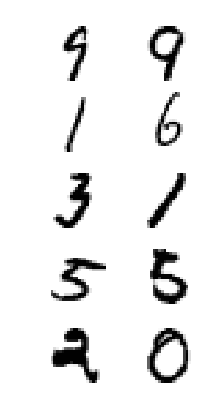

In [174]:
plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

And let's look at the labels (0 means "different", 1 means "same"):

In [175]:
y_batch

array([[1],
       [0],
       [0],
       [1],
       [0]])

Perfect!

### 10.3.
_Exercise: train the DNN on this training set. For each image pair, you can simultaneously feed the first image to DNN A and the second image to DNN B. The whole network will gradually learn to tell whether two images belong to the same class or not._

Let's generate a test set composed of many pairs of images pulled from the MNIST test set:

In [176]:
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

And now, let's train the model. There's really nothing special about this step, except for the fact that we need a fairly large `batch_size`, otherwise the model fails to learn anything and ends up with an accuracy of 50%:

In [177]:
n_epochs = 100
batch_size = 500

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(X_train1) // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        print(epoch, "Train loss:", loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_digit_comparison_model.ckpt")

0 Train loss: 0.693449
0 Test accuracy: 0.5091
1 Train loss: 0.6925517
2 Train loss: 0.6913698
3 Train loss: 0.69394815
4 Train loss: 0.69199574
5 Train loss: 0.6912017
5 Test accuracy: 0.4997
6 Train loss: 0.69237447
7 Train loss: 0.67959845
8 Train loss: 0.58347875
9 Train loss: 0.5501087
10 Train loss: 0.47479486
10 Test accuracy: 0.747
11 Train loss: 0.47786787
12 Train loss: 0.43815765
13 Train loss: 0.4584329
14 Train loss: 0.37488955
15 Train loss: 0.3944795
15 Test accuracy: 0.8408
16 Train loss: 0.35263225
17 Train loss: 0.3779824
18 Train loss: 0.31390512
19 Train loss: 0.34035394
20 Train loss: 0.2987433
20 Test accuracy: 0.8921
21 Train loss: 0.23179962
22 Train loss: 0.23321524
23 Train loss: 0.22762412
24 Train loss: 0.21296309
25 Train loss: 0.19437297
25 Test accuracy: 0.915
26 Train loss: 0.22710522
27 Train loss: 0.19624695
28 Train loss: 0.20233664
29 Train loss: 0.16502927
30 Train loss: 0.19200236
30 Test accuracy: 0.9265
31 Train loss: 0.18807735
32 Train loss: 0.

All right, we reach 97.6% accuracy on this digit comparison task. That's not too bad, this model knows a thing or two about comparing handwritten digits!

Let's see if some of that knowledge can be useful for the regular MNIST classification task.

### 10.4.
_Exercise: now create a new DNN by reusing and freezing the hidden layers of DNN A and adding a softmax output layer on top with 10 neurons. Train this network on split #2 and see if you can achieve high performance despite having only 500 images per class._

Let's create the model, it is pretty straightforward. There are many ways to freeze the lower layers, as explained in the book. In this example, we chose to use the `tf.stop_gradient()` function. Note that we need one `Saver` to restore the pretrained DNN A, and another `Saver` to save the final model: 

In [178]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")
frozen_outputs = tf.stop_gradient(dnn_outputs)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

Now on to training! We first initialize all variables (including the variables in the new output layer), then we restore the pretrained DNN A. Next, we just train the model on the small MNIST dataset (containing just 5,000 images):

In [179]:
n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_digit_comparison_model.ckpt")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_digit_comparison_model.ckpt
0 Test accuracy: 0.9418
10 Test accuracy: 0.96
20 Test accuracy: 0.9644
30 Test accuracy: 0.9641
40 Test accuracy: 0.9636
50 Test accuracy: 0.9636
60 Test accuracy: 0.9636
70 Test accuracy: 0.9636
80 Test accuracy: 0.9635
90 Test accuracy: 0.9634


Well, 96.7% accuracy, that's not the best MNIST model we have trained so far, but recall that we are only using a small training set (just 500 images per digit). Let's compare this result with the same DNN trained from scratch, without using transfer learning:

In [180]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [181]:
n_epochs = 150
batch_size = 50

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

0 Test accuracy: 0.8611
10 Test accuracy: 0.9203
20 Test accuracy: 0.9242
30 Test accuracy: 0.9258
40 Test accuracy: 0.9426
50 Test accuracy: 0.9436
60 Test accuracy: 0.9442
70 Test accuracy: 0.9447
80 Test accuracy: 0.9449
90 Test accuracy: 0.9448
100 Test accuracy: 0.9445
110 Test accuracy: 0.9443
120 Test accuracy: 0.9443
130 Test accuracy: 0.9443
140 Test accuracy: 0.9443


Only 94.8% accuracy... So transfer learning helped us reduce the error rate from 5.2% to 3.3% (that's over 36% error reduction). Moreover, the model using transfer learning reached over 96% accuracy in less than 10 epochs.

Bottom line: transfer learning does not always work (as we saw in exercise 9), but when it does it can make a big difference. So try it out!